<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Siemens/Siemens_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "SIE.de"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High    Low  Close  Adj Close   Volume
Date                                                        
2009-01-02   52.58   53.78  51.97  53.78      36.64  4548970
2009-01-05   54.67   55.37  52.86  53.21      36.25  5350164
2009-01-06   53.59   55.17  53.56  54.45      37.10  5121055
2009-01-07   54.04   54.33  52.97  53.41      36.39  3885695
2009-01-08   52.42   52.72  50.79  51.32      34.97  5158570
...            ...     ...    ...    ...        ...      ...
2018-12-19  100.38  100.64  99.39  99.51      95.72  2623829
2018-12-20   98.32   98.64  97.11  98.39      94.64  3725141
2018-12-21   98.22   98.34  97.11  98.17      94.43  6667022
2018-12-27   98.00   98.06  94.97  95.82      92.17  3107490
2018-12-28   96.33   98.11  96.33  97.38      93.67  1702272

[2539 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2539.000000  2539.000000  2539.000000  2539.000000  2539.000000  2.539000e+03
mean     87.791221    88.605707    86.958834    87.794695    74.173375  3.008274e+06
std      20.000959    20.008590    20.013986    20.007067    23.117720  1.738982e+06
min      37.500000    38.250000    36.160000    37.170000    26.300000  0.000000e+00
25%      73.225000    73.985000    72.385000    73.210000    55.410000  1.894764e+06
50%      89.750000    90.760000    89.140000    89.920000    73.870000  2.599163e+06
75%      99.825000   100.775000    99.125000    99.990000    87.995000  3.588094e+06
max     132.450000   133.500000   132.050000   133.200000   124.250000  2.062244e+07

7

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High    Low  Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama        fama      SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2009-03-13   43.30   43.56  41.87  42.14      29.81  4957991   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  40.407511   39.866510   36.806912  41.418022  40.645263  39.824814      39.965      39.860   37.172032  39.90375  42.455428  39.6705  40.743333  39.90375  42.066667   40.137152               43.886813                 39.90375               35.920687               45.878345                 39.90375               33.929155               47.869877                 39.90375               31.937623               49.861408                 39.90375               29.946092  40.645263  41.825321   39.891023               44.628326                40.645263               36.662200               46.619858                40.645263               34.670668               48.611390                40.645263               32.679136               50.602921                40.645263   
2009-03-16   43.18   43.67  42.43  42.97      30.40  5133808   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  41.688755   40.322071   37.347159  42.164712  41.161871  40.184602      40.135      39.915   37.683069  40.38500  43.150537  40.5240  41.424722  40.38500  42.555000   40.142014               44.781840                 40.38500               35.988160               46.980260                 40.38500               33.789740               49.178680                 40.38500               31.591320               51.377099                 40.38500               29.392901  41.161871  42.683990   39.956222               45.558711                41.161871               36.765031               47.757131                41.161871               34.566611               49.955551                41.161871               32.368192               52.153971                41.161871   
2009-03-17   42.88

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2.489000e+03  2489.000000  2489.000000  2489.000000    2489.000000   2489.000000     2489.000000     2489.000000       2489.000000  2489.000000  2489.000000  2489.000000  2489.000000   2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000   
mean     88.675139    89.487859    87.850888    88.684050    75.053572  2.942407e+06    15.762555     2.002812   185.324628      30.459221      0.031338        0.028124        0.008437          0.008035     6.595822     2.531137    26.959020     2.002812      2.012455    26.959020    88.632705    88.459527     5.291988    88.686152    88.602532    88.535805    88.578017    88.500438    88.266162    88.603189    88.686073    88.603835    88.630920    88.603189    88.664758    88.435213               91.166176                88.603189               86.040202               92.447670                88.603189               84.758708               93.729163                88.603189               83.477215               95.010657                88.603189               82.195721    88.602532    88.667188    88.460131               91.165519                88.602532               86.039545               92.447012                88.602532               84.758051               93.728506   
std      19.183120    19.195921    19.178133    19.177491    22.486846  1.652353e+06     8.711079     1.408087   103.325294       0.787286      0.174264        0.165360        0.091484          0.089297     3.387334     1.104259    14.776277     1.408087      1.413448    14.776277    19.166355    19.192957    90.319230    19.192363    19.181278    19.297451    19.219493    19.217771    19.470668    19.205199    19.187298    19.216641    19.185480    19.205199    19.185543    19.281750               19.375388                19.205199               19.129752               19.495289                19.205199               19.127961               19.637855                19.205199               19.150164               19.802596                19.205199               19.196279    19.181278    19.173579    19.270931               19.352456                19.181278               19.104947               19.472885                19.181278               19.102759               19.615998   
min      40.520000    41.680000    40.

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.030240  0.020475  0.019036  0.021071   0.014505  4957991   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000000  0.647979  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.011996  0.000000  0.000000  0.000000  0.005000  0.000000                0.003862                 0.000000                0.000000                0.019080                 0.000000                0.001437                0.033324                 0.000000                0.003510                0.046649                 0.000000                0.005514  0.000000  0.002568  0.000000                0.015530                 0.000000                0.000000                0.030108                 0.000000                0.001091                0.043748                 0.000000                0.003204                0.056538                 0.000000   
2009-03-16  0.028935  0.021673  0.025128  0.029994   0.020662  5133808   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.014190  0.005102  0.650034  0.008162  0.005684  0.003977    0.001839    0.000599  0.005305  0.005204  0.019570  0.009209  0.007447  0.005204  0.010346  0.000054                0.013456                 0.005204                0.000707                0.030523                 0.005204                0.000000                0.046484                 0.005204                0.000000                0.061405                 0.005204                0.000000  0.005684  0.011986  0.000718                0.025365                 0.005684                0.001096                0.041731                 0.005684                0.000000                0.057043                 0.005684                0.000000                0.071400                 0.005684   
2009-03-17  0.025672  0.018514  0.019471  0.031499  

140208

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         2 hours 9 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_38u2wu
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_144754_mod...  0.518183   7.881810              0.485792  0.622579  0.387605
1  DeepLearning_grid_1_AutoML_20190828_144754_mod...  0.507918   7.330775              0.490257  0.610546  0.372766
2  DeepLearning_grid_1_AutoML_20190828_144754_mod...  0.504432   3.981245              0.500000  0.553665  0.306545
3  DeepLearning_grid_1_AutoML_20190828_144754_mod...  0.500000   0.692199              0.500000  0.499526  0.249526
4  DeepLearning_grid_1_AutoML_20190828_144754_mod...  0.500000   0.692903              0.500000  0.499878  0.249878
5  DeepLearning_grid_1_AutoML_20190828_144754_mod...  0.500000   0.693103              0.500000  0.499978  0.249978
6  DeepLearning_grid_1_AutoML_20190828_144754_mod...  0.497784  11.564772              0.500000  0.673427  0.453504
7  DeepLearning_grid_1_AutoML_20190828_144754_mod...  0.495308  14.472016              0.500000  0.732344  0.536328
8  DeepLearning_grid_1_AutoML_20190828_144754_mod...  0.491202  12.481872              0.500000  0.704987  0.497007
9              DeepLearning_1_AutoML_20190828_144754  0.482632  10.377181              0.500000  0.725166  0.525865

variable  relative_importance  scaled_importance  percentage
0           CDLMORNINGDOJISTAR             1.000000           1.000000    0.002716
1             CDLCOUNTERATTACK             0.999574           0.999574    0.002715
2            CDL3WHITESOLDIERS             0.999451           0.999451    0.002715
3                    CDL2CROWS             0.997168           0.997168    0.002708
4                CDLHIKKAKEMOD             0.987242           0.987242    0.002682
...                        ...                  ...                ...         ...
1035  BBANDS_middleband_30_6_3             0.310863           0.310863    0.000844
1036    BBANDS_upperband_8_8_3             0.310679           0.310679    0.000844
1037   BBANDS_upperband_12_4_4             0.310339           0.310339    0.000843
1038   BBANDS_lowerband_14_5_3             0.309784           0.309784    0.000841
1039                 MAVP_14_5             0.308721           0.308721    0.000839

[1040 rows x 4 columns]

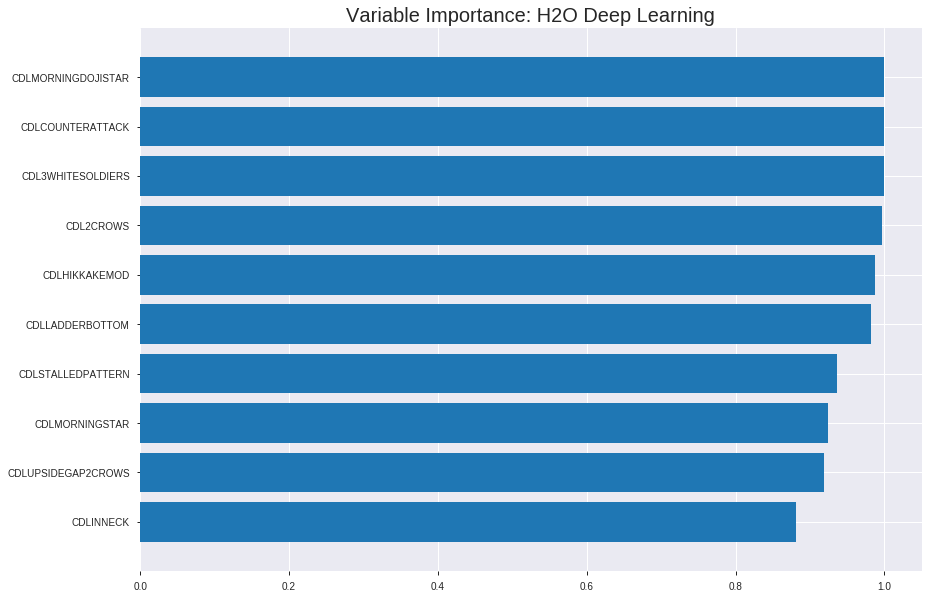

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_144754_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22187142969713683
RMSE: 0.47103230218015496
LogLoss: 0.638766762526097
Mean Per-Class Error: 0.3452500759406738
AUC: 0.7255913467253061
pr_auc: 0.7301050634827703
Gini: 0.45118269345061224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29594088474857816: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      317  529   0.6253   (529.0/846.0)
1      85   810   0.095    (85.0/895.0)
Total  402  1339  0.3527   (614.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.295941     0.725157  292
max f2                       0.0849146    0.858159  366
max f0point5                 0.554938     0.663406  192
max accuracy                 0.445278     0.657668  235
max precision                0.998262     1         0
max recall                   0.0572603    1         375
max specificity              0.998262     1         0
max absolute_mcc             0.295941     0.331769  292
max min_per_class_accuracy   0.597713     0.646572  175
max mean_per_class_accuracy  0.554938     0.65475   192

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 55.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.993108           1.94525   1.94525            1                0.995808   1                           0.995808            0.0201117       0.0201117                  94.5251   94.5251
    2        0.0201034                   0.988282           1.83082   1.88967            0.941176         0.990622   0.971429                    0.993289            0.0178771       0.0379888                  83.0825   88.9673
    3        0.0304423                   0.983518           1.83718   1.87185            0.944444         0.986563   0.962264                    0.991005            0.0189944       0.0569832                  83.7182   87.1846
    4        0.0402068                   0.975819           1.83082   1.86188            0.941176         0.980155   0.957143                    0.98837             0.0178771       0.0748603                  83.0825   86.1883
    5        0.0505457                   0.968283           1.51297   1.79052            0.777778         0.971753   0.920455                    0.984971            0.0156425       0.0905028                  51.2973   79.0515
    6        0.100517                    0.932626           1.63222   1.71182            0.83908          0.951483   0.88                        0.968323            0.0815642       0.172067                   63.2222   71.1821
    7        0.150488                    0.884252           1.52043   1.64827            0.781609         0.90569    0.847328                    0.947525            0.0759777       0.248045                   52.0426   64.8266
    8        0.20046                     0.842435           1.22976   1.54394            0.632184         0.861751   0.793696                    0.926143            0.0614525       0.309497                   22.9757   54.3939
    9        0.300402                    0.779473           1.12914   1.40594            0.58046          0.810233   0.722753                    0.88758             0.112849        0.422346                   12.914    40.5937
    10       0.400345                    0.696894           1.11796   1.33405            0.574713         0.739834   0.685796                    0.850697            0.111732        0.534078                   11.7961   33.4046
    11       0.500287                    0.599092           1.06206   1.27971            0.545977         0.645875   0.657865                    0.809779            0.106145        0.640223                   6.20625   27.9712
    12       0.60023                     0.485399           1.0397    1.23975            0.534483         0.54881    0.637321                    0.766326            0.103911        0.744134                   3.97033   23.9749
    13       0.700172                    0.371229           0.961446  1.20002            0.494253         0.426898   0.616899                    0.717876            0.0960894       0.840223                   -3.85539  20.0024
    14       0.800115                    0.262751           0.804932  1.15067            0.413793         0.317624   0.591529                    0.667881            0.0804469       0.92067                    -19.5068  15.0673
    15       0.900057                    0.124527           0.614878  1.09118            0.316092         0.194104   0.560944                    0.615272            0.0614525       0.982123                   -38.5122  9.1178
    16       1                           0.0016639          0.178874  1                  0.091954         0.0583259  0.514072                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.4281071266616925
RMSE: 0.6542989581694996
LogLoss: 10.080160863460904
Mean Per-Class Error: 0.4913204807614746
AUC: 0.47153343550859084
pr_auc: 0.24339342558331306
Gini: -0.056933128982818326
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26378865807099267: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    240  0.9796   (240.0/245.0)
1      1    252  0.004    (1.0/253.0)
Total  6    492  0.4839   (241.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.263789     0.67651    225
max f2                       0.230811     0.839416   228
max f0point5                 0.263789     0.567312   225
max accuracy                 0.429188     0.516064   211
max precision                0.429188     0.512552   211
max recall                   0.230811     1          228
max specificity              1            0.436735   0
max absolute_mcc             0.230811     0.0791107  228
max min_per_class_accuracy   1            0.436735   0
max mean_per_class_accuracy  0.429188     0.50868    211

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 86.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.522088                    1                  0.938766  0.938766           0.476923         1         0.476923                    1                   0.490119        0.490119                   -6.12344  -6.12344
    2        0.600402                    0.98495            1.00943   0.947982           0.512821         0.996018  0.481605                    0.999481            0.0790514       0.56917                    0.942536  -5.20179
    3        0.698795                    0.817231           1.04445   0.961565           0.530612         0.904852  0.488506                    0.986157            0.102767        0.671937                   4.44462   -3.84353
    4        0.799197                    0.702453           1.2204    0.994081           0.62             0.758893  0.505025                    0.957606            0.12253         0.794466                   22.0395   -0.591892
    5        0.899598                    0.541498           0.98419   0.992977           0.5              0.62009   0.504464                    0.919937            0.0988142       0.893281                   -1.58103  -0.702287
    6        1                           0.214312           1.06292   1                  0.54             0.413651  0.508032                    0.869105            0.106719        1                          6.29249   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 14:52:05  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 14:52:08  5.821 sec         144 obs/sec       0.278576  1             485        0.660707         2.82266             -0.747521      0.531286        0.477012           0.756487         0.485928                         0.718131           12.3951               -1.06338         0.46575           0.207806             0.944558           0.47992
    2019-08-28 14:52:32  30.269 sec        153 obs/sec       2.24469   8             3908       0.643416         2.7016              -0.657251      0.571074        0.451272           1.18876          0.468696                         0.686349           11.6733               -0.884787        0.453731          0.211674             0.943744           0.48996
    2019-08-28 14:52:57  54.597 sec        161 obs/sec       4.40839   16            7675       0.600462         1.58207             -0.44336       0.607496        0.56455            1.51297          0.485928                         0.692542           11.5427               -0.918951        0.536977          0.550014             1.5747             0.491968
    2019-08-28 14:53:23  1 min 20.433 sec  169 obs/sec       6.91327   25            12036      0.575982         1.19726             -0.328072      0.605046        0.601067           1.51297          0.463527                         0.65887            10.9653               -0.736888        0.548189          0.587425             1.96838            0.491968
    2019-08-28 14:53:47  1 min 45.273 sec  175 obs/sec       9.43653   34            16429      0.543198         0.972443            -0.181192      0.643544        0.644642           1.4049           0.471568                         0.68029            11.0202               -0.851655        0.539171          0.552923             1.5747             0.491968
    2019-08-28 14:54:12  2 min 10.279 sec  178 obs/sec       11.9259   43            20763      0.537044         0.952639            -0.154578      0.649896        0.663371           1.72911          0.472717                         0.643599           10.9372               -0.657306        0.547536          0.570446             1.18103            0.491968
    2019-08-28 14:54:38  2 min 35.413 sec  184 obs/sec       14.6967   53            25587      0.526408         0.886573            -0.1093        0.720544        0.754327           1.94525          0.404365                         0.68553            10.7947               -0.880289        0.544995          0.566141             0.787352           0.491968
    2019-08-28 14:55:02  2 min 59.931 sec  189 obs/sec       17.4727   63            30420      0.471032         0.638767            0.111811       0.725591        0.730105           1.94525          0.352671                         0.654299           10.0802               -0.712871        0.471533          0.243393             0.938766           0.483936
    2019-08-28 14:55:26  

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLMORNINGDOJISTAR        1.0                    1.0                  0.0027161555235547113
CDLCOUNTERATTACK          0.9995741844177246     0.9995741844177246   0.0027149989422088983
CDL3WHITESOLDIERS         0.9994506239891052     0.9994506239891052   0.002714663332868211
CDL2CROWS                 0.9971680045127869     0.9971680045127869   0.002708463383369435
CDLHIKKAKEMOD             0.9872415661811829     0.9872415661811829   0.002681501633065824
---                       ---                    ---                  ---
BBANDS_middleband_30_6_3  0.3108629882335663     0.3108629882335663   0.0008443522225593242
BBANDS_upperband_8_8_3    0.31067878007888794    0.31067878007888794  0.0008438518845625109
BBANDS_upperband_12_4_4   0.3103385865688324     0.3103385865688324   0.000842927866081096
BBANDS_lowerband_14_5_3   0.3097843825817108     0.3097843825817108   0.0008414225618602997
MAVP_14_5                 0.3087206184864044     0.3087206184864044   0.000838533213137074


See the whole table with table.as_data_frame()


('accuracy', 0.570281124497992)

('F1', 0.7139107611548556)

('auc', 0.5181830031282586)

('logloss', 7.881809882895741)

('mean_per_class_error', 0.4532390510948905)

('rmse', 0.6225789635925185)

('mse', 0.38760456590793446)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


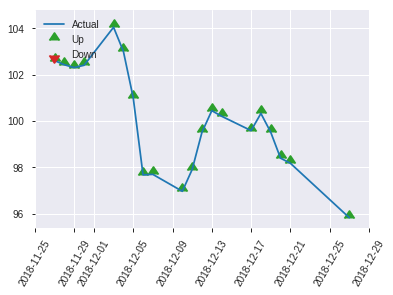


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.38760456590793446
RMSE: 0.6225789635925185
LogLoss: 7.881809882895741
Mean Per-Class Error: 0.4532390510948905
AUC: 0.5181830031282586
pr_auc: 0.294846311801574
Gini: 0.0363660062565172
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.413100432973612: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    108  0.9643   (108.0/112.0)
1      1    136  0.0073   (1.0/137.0)
Total  5    244  0.4378   (109.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4131       0.713911  126
max f2                       0.322896     0.859473  131
max f0point5                 0.838346     0.612829  66
max accuracy                 0.838346     0.570281  66
max precision                0.838346     0.581522  66
max recall                   0.322896     1         131
max specificity              1            0.535714  0
max absolute_mcc             0.838346     0.10593   66
max min_per_class_accuracy   0.999999     0.510949  6
max mean_per_class_accuracy  0.838346     0.546761  66

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 90.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.425703                    1                  0.994491  0.994491           0.54717          1         0.54717                     1                   0.423358        0.423358                   -0.550888  -0.550888
    2        0.502008                    0.999998           1.14791   1.01781            0.631579         1         0.56                        1                   0.0875912       0.510949                   14.7906    1.78102
    3        0.598394                    0.984729           0.984489  1.01244            0.541667         0.99603   0.557047                    0.99936             0.0948905       0.605839                   -1.55109   1.24431
    4        0.698795                    0.885288           1.23591   1.04455            0.68             0.936218  0.574713                    0.990288            0.124088        0.729927                   23.5912    4.45507
    5        0.799197                    0.778964           0.872409  1.02292            0.48             0.829079  0.562814                    0.970036            0.0875912       0.817518                   -12.7591   2.29248
    6        0.899598                    0.654086           0.799708  0.998012           0.44             0.723987  0.549107                    0.942575            0.080292        0.89781                    -20.0292   -0.198775
    7        1                           0.322896           1.01781   1                  0.56             0.519552  0.550201                    0.900103            0.10219         1                          1.78102    0

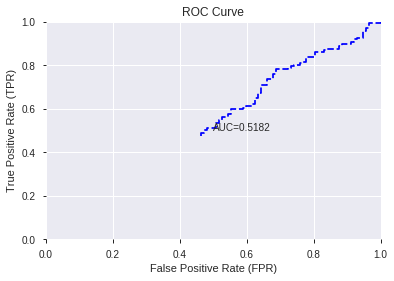

This function is available for GLM models only


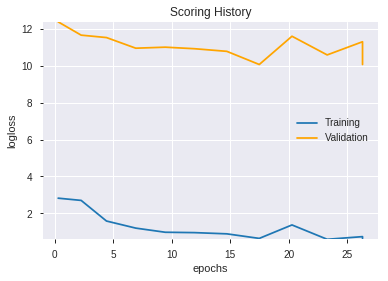

--2019-08-28 15:17:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.20
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.20|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_144754_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_144754_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_151714_model_8  0.506322   0.693645              0.494721  0.500248  0.250248
1  DeepLearning_grid_1_AutoML_20190828_151714_model_9  0.494069   0.688451              0.500000  0.497649  0.247655
2  DeepLearning_grid_1_AutoML_20190828_151714_model_3  0.488725  14.176187              0.500000  0.705442  0.497649
3  DeepLearning_grid_1_AutoML_20190828_151714_model_1  0.488008  14.517078              0.500000  0.715320  0.511683
4  DeepLearning_grid_1_AutoML_20190828_151714_model_6  0.487422  11.159363              0.500000  0.669757  0.448575
5  DeepLearning_grid_1_AutoML_20190828_151714_model_4  0.483251  13.730665              0.500000  0.712726  0.507979
6  DeepLearning_grid_1_AutoML_20190828_151714_model_5  0.481784  11.913022              0.500000  0.676760  0.458004
7  DeepLearning_grid_1_AutoML_20190828_151714_model_7  0.479797   8.715676              0.500000  0.697217  0.486112
8  DeepLearning_grid_1_AutoML_20190828_151714_model_2  0.477385  13.317890              0.500000  0.703986  0.495596
9               DeepLearning_1_AutoML_20190828_151714  0.477288  12.537127              0.500000  0.692205  0.479148

variable  relative_importance  scaled_importance  percentage
0          weekday_name             1.000000           1.000000    0.030810
1                   SIN             0.973879           0.973879    0.030005
2                   day             0.935641           0.935641    0.028827
3         days_in_month             0.820598           0.820598    0.025282
4        STOCHRSI_fastk             0.818132           0.818132    0.025206
5                   BOP             0.795088           0.795088    0.024496
6                   COS             0.789140           0.789140    0.024313
7               weekday             0.787014           0.787014    0.024248
8             dayofweek             0.780971           0.780971    0.024062
9              CORREL_8             0.762325           0.762325    0.023487
10       CDLRICKSHAWMAN             0.748933           0.748933    0.023074
11      CDLHOMINGPIGEON             0.725695           0.725695    0.022359
12       is_month_start             0.681567           0.681567    0.020999
13         is_month_end             0.657719           0.657719    0.020264
14      CDLUNIQUE3RIVER             0.652273           0.652273    0.020096
15              CDLDOJI             0.649446           0.649446    0.020009
16    CDLLONGLEGGEDDOJI             0.649053           0.649053    0.019997
17          CDLPIERCING             0.643374           0.643374    0.019822
18    CDLSTALLEDPATTERN             0.635629           0.635629    0.019584
19                 SINH             0.627500           0.627500    0.019333
20       CDLMORNINGSTAR             0.626805           0.626805    0.019312
21            CDL2CROWS             0.622248           0.622248    0.019171
22      CDLSHOOTINGSTAR             0.617764           0.617764    0.019033
23                 COSH             0.613497           0.613497    0.018902
24     CDLDRAGONFLYDOJI             0.609056           0.609056    0.018765
25            CDLHAMMER             0.605717           0.605717    0.018662
26       CDLMATCHINGLOW             0.604256           0.604256    0.018617
27            CDLONNECK             0.600176           0.600176    0.018491
28       CDLEVENINGSTAR             0.600097           0.600097    0.018489
29         CDLTASUKIGAP             0.594317           0.594317    0.018311
30                  EXP             0.587360           0.587360    0.018096
31   CDLUPSIDEGAP2CROWS             0.582758           0.582758    0.017955
32            CDLTAKURI             0.582707           0.582707    0.017953
33  CDLGAPSIDESIDEWHITE             0.579254           0.579254    0.017847
34       is_quarter_end             0.574153           0.574153    0.017690
35    CDLDARKCLOUDCOVER             0.568134           0.568134    0.017504
36     CDLSTICKSANDWICH             0.563524           0.563524    0.017362
37    CDLINVERTEDHAMMER             0.563151           0.563151    0.017351
38        CDLHANGINGMAN             0.561183           0.561183    0.017290
39    CDL3WHITESOLDIERS             0.560702           0.560702    0.017275
40  CDLXSIDEGAP3METHODS             0.560451           0.560451    0.017267
41      CDLLADDERBOTTOM             0.559874           0.559874    0.017250
42         CDLTHRUSTING             0.557803           0.557803    0.017186
43        CDLHIKKAKEMOD             0.556720           0.556720    0.017152
44    CDLGRAVESTONEDOJI             0.549808           0.549808    0.016939
45     CDLCOUNTERATTACK             0.549035           0.549035    0.016916
46            CDLINNECK             0.547859           0.547859    0.016879
47      CDLADVANCEBLOCK             0.545173           0.545173    0.016797
48   CDLMORNINGDOJISTAR             0.544193           0.544193    0.016766
49     is_quarter_start             0.535479           0.535479    0.016498

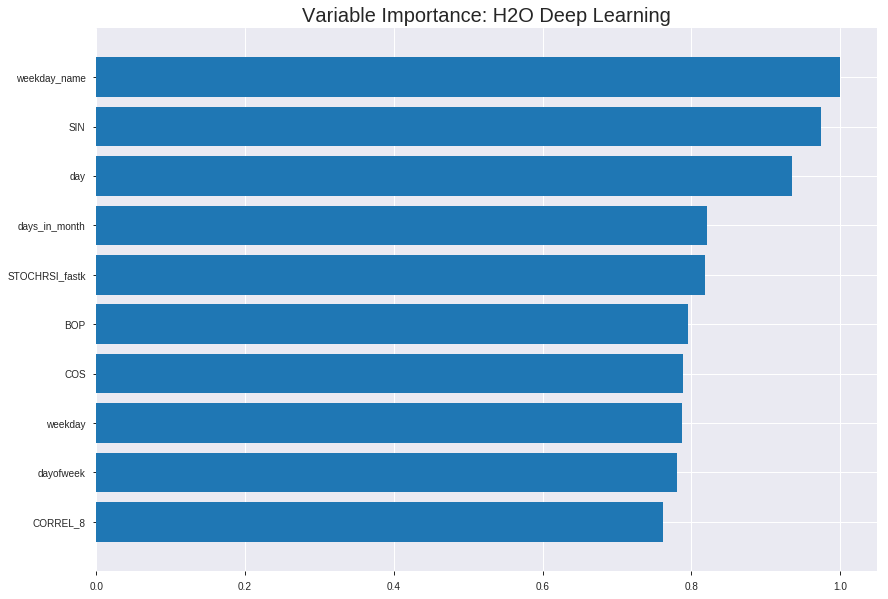

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_151714_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24681586904513506
RMSE: 0.4968056652707727
LogLoss: 0.6862990593508133
Mean Per-Class Error: 0.44351664751640973
AUC: 0.551349762933027
pr_auc: 0.5546190292218203
Gini: 0.10269952586605391
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45992549569752317: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      84   762   0.9007   (762.0/846.0)
1      25   870   0.0279   (25.0/895.0)
Total  109  1632  0.452    (787.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459925     0.688564  292
max f2                       0.316722     0.842304  373
max f0point5                 0.498773     0.592236  92
max accuracy                 0.498773     0.565192  92
max precision                0.501573     1         0
max recall                   0.15659      1         394
max specificity              0.501573     1         0
max absolute_mcc             0.459925     0.147219  292
max min_per_class_accuracy   0.499356     0.315603  58
max mean_per_class_accuracy  0.498773     0.556483  92

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 49.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.500324           1.4049    1.4049             0.722222         0.500833  0.722222                    0.500833            0.0145251       0.0145251                  40.4904   40.4904
    2        0.0201034                   0.499861           1.14427   1.27831            0.588235         0.50002   0.657143                    0.500438            0.0111732       0.0256983                  14.4266   27.8308
    3        0.0304423                   0.499613           1.29683   1.2846             0.666667         0.499728  0.660377                    0.500197            0.0134078       0.0391061                  29.6834   28.46
    4        0.0402068                   0.499479           0.915412  1.19494            0.470588         0.499545  0.614286                    0.500038            0.00893855      0.0480447                  -8.45876  19.494
    5        0.0505457                   0.499387           0.756487  1.10526            0.388889         0.499434  0.568182                    0.499915            0.00782123      0.0558659                  -24.3513  10.5256
    6        0.724871                    0.499356           1.04885   1.05278            0.539182         0.499356  0.541204                    0.499395            0.707263        0.763128                   4.88451   5.27787
    7        0.800115                    0.499216           1.18794   1.06549            0.610687         0.499321  0.547739                    0.499388            0.0893855       0.852514                   18.794    6.54895
    8        0.900057                    0.482751           0.782572  1.03407            0.402299         0.49415   0.531589                    0.498806            0.0782123       0.930726                   -21.7428  3.40743
    9        1                           0.0389639          0.693136  1                  0.356322         0.410465  0.514072                    0.489977            0.0692737       1                          -30.6864  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.251188297906693
RMSE: 0.5011868892007182
LogLoss: 0.6957571490077732
Mean Per-Class Error: 0.4980237154150198
AUC: 0.4948132612728886
pr_auc: 0.500380896941789
Gini: -0.01037347745422279
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20322403321765756: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    245  1        (245.0/245.0)
1      0    253  0        (0.0/253.0)
Total  0    498  0.492    (245.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.203224     0.673768   57
max f2                       0.203224     0.837748   57
max f0point5                 0.203224     0.563474   57
max accuracy                 0.492847     0.508032   33
max precision                0.500593     1          0
max recall                   0.203224     1          57
max specificity              0.500593     1          0
max absolute_mcc             0.480648     0.0522801  40
max min_per_class_accuracy   0.499356     0.0897959  10
max mean_per_class_accuracy  0.500593     0.501976   0

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 49.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.499618           0.787352  0.787352           0.4              0.499968  0.4                         0.499968            0.00790514      0.00790514                 -21.2648   -21.2648
    2        0.0200803                   0.499357           1.18103   0.98419            0.6              0.499494  0.5                         0.499731            0.0118577       0.0197628                  18.1028    -1.58103
    3        0.905622                    0.499356           0.995348  0.995101           0.505669         0.499356  0.505543                    0.499364            0.881423        0.901186                   -0.465166  -0.489908
    4        1                           0.203224           1.04701   1                  0.531915         0.460647  0.508032                    0.49571             0.0988142       1                          4.70103    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:21:40  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:21:42  1 min  3.140 sec  586 obs/sec       0.528432  1             920        0.551432         0.821469            -0.217275      0.513766        0.530232           1.0807           0.478461                         0.647777           10.0469               -0.678893        0.468194          0.240427             0.95459            0.491968
    2019-08-28 15:21:52  1 min 13.758 sec  933 obs/sec       5.99885   11            10444      0.501407         0.695988            -0.00643404    0.53587         0.541127           0.864556         0.477312                         0.61264            8.82501               -0.501696        0.537566          0.544405             1.5747             0.491968
    2019-08-28 15:22:03  1 min 24.190 sec  1059 obs/sec      12.5663   23            21878      0.501545         0.696277            -0.00698829    0.522137        0.745395           1.02169          0.47444                          0.502889           0.698992              -0.011849        0.494604          0.022032             0.994463           0.48996
    2019-08-28 15:22:13  1 min 33.961 sec  1164 obs/sec      19.6887   36            34278      0.496806         0.686299            0.0119539      0.55135         0.554619           1.4049           0.452039                         0.501187           0.695757              -0.00501255      0.494813          0.500381             0.787352           0.491968
    2019-08-28 15:22:23  1 min 44.239 sec  1206 obs/sec      26.8139   49            46683      0.499682         0.692355            0.000481333    0.584362        0.587229           1.72911          0.45606                          0.629108           9.8377                -0.583518        0.531467          0.528627             0.787352           0.491968
    2019-08-28 15:22:33  1 min 54.565 sec  1247 obs/sec      34.4273   63            59938      0.499926         0.692666            -0.000495686   0.586876        0.607092           1.83718          0.449742                         0.621639           9.52933               -0.54614         0.533887          0.52835              0.393676           0.491968
    2019-08-28 15:22:44  2 min  5.031 sec  1309 obs/sec      43.2401   79            75281      0.484804         0.659411            0.0591131      0.59654         0.614825           1.94525          0.424469                         0.639119           10.3437               -0.634316        0.528281          0.525836             1.18103            0.491968
    2019-08-28 15:22:45  2 min  6.045 sec  1308 obs/sec      43.2401   79            75281      0.496806         0.686299            0.0119539      0.55135         0.554619           1.4049           0.452039                         0.501187           0.695757              -0.00501255      0.494813          0.500381             0.787352           0.491968

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
weekday_name        1.0                    1.0                  0.030809774255115902
SIN                 0.9738786816596985     0.9738786816596985   0.03000498233380519
day                 0.9356410503387451     0.9356410503387451   0.02882688954475627
days_in_month       0.8205978274345398     0.8205978274345398   0.025282433817496723
STOCHRSI_fastk      0.8181315064430237     0.8181315064430237   0.02520644702450746
---                 ---                    ---                  ---
CDLCOUNTERATTACK    0.5490347743034363     0.5490347743034363   0.01691563745449738
CDLINNECK           0.5478591322898865     0.5478591322898865   0.01687941618945508
CDLADVANCEBLOCK     0.5451729893684387     0.5451729893684387   0.0167966567324283
CDLMORNINGDOJISTAR  0.5441933870315552     0.5441933870315552   0.016766475405569133
is_quarter_start    0.5354792475700378     0.5354792475700378   0.016497994735932185


See the whole table with table.as_data_frame()


('accuracy', 0.5582329317269076)

('F1', 0.710182767624021)

('auc', 0.5063216892596455)

('logloss', 0.6936452824194381)

('mean_per_class_error', 0.4869981751824817)

('rmse', 0.5002481679161405)

('mse', 0.25024822950345504)

deeplearning prediction progress: |███████████████████████████████████████| 100%


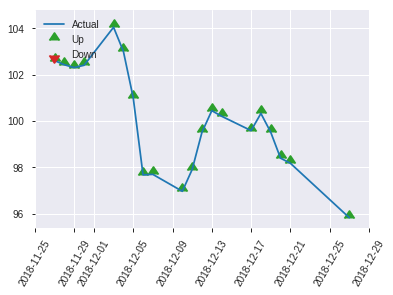


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25024822950345504
RMSE: 0.5002481679161405
LogLoss: 0.6936452824194381
Mean Per-Class Error: 0.4869981751824817
AUC: 0.5063216892596455
pr_auc: 0.03217786933784587
Gini: 0.012643378519290982
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46998952980875974: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    110  0.9821   (110.0/112.0)
1      1    136  0.0073   (1.0/137.0)
Total  3    246  0.4458   (111.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.46999      0.710183   13
max f2                       0.431392     0.859473   16
max f0point5                 0.499281     0.608295   4
max accuracy                 0.499281     0.558233   4
max precision                0.499281     0.556962   4
max recall                   0.431392     1          16
max specificity              0.499356     0.0714286  0
max absolute_mcc             0.499281     0.0604003  4
max min_per_class_accuracy   0.499356     0.0714286  0
max mean_per_class_accuracy  0.499281     0.513002   4

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 49.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.935743                    0.499356           1.00627   1.00627            0.553648         0.499356  0.553648                    0.499356            0.941606        0.941606                   0.626547  0.626547
    2        1                           0.431392           0.908759  1                  0.5              0.483142  0.550201                    0.498314            0.0583942       1                          -9.12409  0

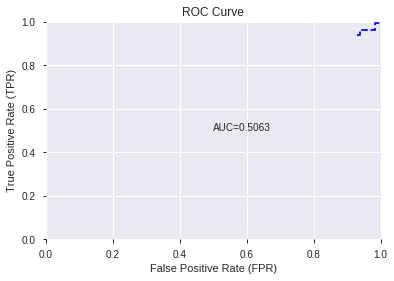

This function is available for GLM models only


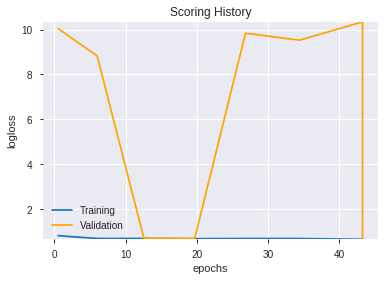

--2019-08-28 15:24:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.236.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.236.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_151714_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_151714_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['weekday_name',
 'SIN',
 'day',
 'days_in_month',
 'STOCHRSI_fastk',
 'BOP',
 'COS',
 'weekday',
 'dayofweek',
 'CORREL_8',
 'CDLRICKSHAWMAN',
 'CDLHOMINGPIGEON',
 'is_month_start',
 'is_month_end',
 'CDLUNIQUE3RIVER',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLPIERCING',
 'CDLSTALLEDPATTERN',
 'SINH',
 'CDLMORNINGSTAR',
 'CDL2CROWS',
 'CDLSHOOTINGSTAR',
 'COSH',
 'CDLDRAGONFLYDOJI',
 'CDLHAMMER',
 'CDLMATCHINGLOW',
 'CDLONNECK',
 'CDLEVENINGSTAR',
 'CDLTASUKIGAP',
 'EXP',
 'CDLUPSIDEGAP2CROWS',
 'CDLTAKURI',
 'CDLGAPSIDESIDEWHITE',
 'is_quarter_end',
 'CDLDARKCLOUDCOVER',
 'CDLSTICKSANDWICH',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDL3WHITESOLDIERS',
 'CDLXSIDEGAP3METHODS',
 'CDLLADDERBOTTOM',
 'CDLTHRUSTING',
 'CDLHIKKAKEMOD',
 'CDLGRAVESTONEDOJI',
 'CDLCOUNTERATTACK',
 'CDLINNECK',
 'CDLADVANCEBLOCK',
 'CDLMORNINGDOJISTAR',
 'is_quarter_start']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_152414_model_1  0.485597  10.679887                   0.5  0.664922  0.442121

variable  relative_importance  scaled_importance  percentage
0                   SIN             0.009067           1.000000    0.053484
1        is_month_start             0.008889           0.980330    0.052432
2           CDLPIERCING             0.007057           0.778332    0.041628
3      is_quarter_start             0.007039           0.776314    0.041520
4    CDLMORNINGDOJISTAR             0.006993           0.771294    0.041252
5        CDLMORNINGSTAR             0.006604           0.728380    0.038956
6                   BOP             0.006340           0.699263    0.037399
7       CDLHOMINGPIGEON             0.006048           0.667039    0.035676
8    CDLUPSIDEGAP2CROWS             0.005710           0.629726    0.033680
9          CDLTASUKIGAP             0.005217           0.575413    0.030775
10                  day             0.004857           0.535690    0.028651
11                  EXP             0.004544           0.501125    0.026802
12                 COSH             0.004543           0.501027    0.026797
13                 SINH             0.004535           0.500136    0.026749
14            CDLTAKURI             0.004475           0.493494    0.026394
15     CDLDRAGONFLYDOJI             0.004465           0.492437    0.026337
16    CDL3WHITESOLDIERS             0.004297           0.473874    0.025345
17      CDLLADDERBOTTOM             0.004261           0.469931    0.025134
18        CDLHIKKAKEMOD             0.004257           0.469511    0.025111
19     CDLCOUNTERATTACK             0.003932           0.433676    0.023195
20            CDLINNECK             0.003824           0.421699    0.022554
21        days_in_month             0.003652           0.402822    0.021544
22         CDLTHRUSTING             0.003480           0.383837    0.020529
23            dayofweek             0.003178           0.350505    0.018746
24              weekday             0.003170           0.349635    0.018700
25       CDLEVENINGSTAR             0.003120           0.344144    0.018406
26      CDLADVANCEBLOCK             0.002778           0.306387    0.016387
27    CDLGRAVESTONEDOJI             0.002676           0.295140    0.015785
28    CDLDARKCLOUDCOVER             0.002522           0.278147    0.014876
29    CDLSTALLEDPATTERN             0.002493           0.274896    0.014702
30       CDLRICKSHAWMAN             0.002391           0.263652    0.014101
31      CDLSHOOTINGSTAR             0.002339           0.257999    0.013799
32     CDLSTICKSANDWICH             0.002174           0.239777    0.012824
33                  COS             0.001992           0.219740    0.011753
34            CDLHAMMER             0.001869           0.206149    0.011026
35        CDLHANGINGMAN             0.001766           0.194741    0.010415
36         is_month_end             0.001762           0.194283    0.010391
37             CORREL_8             0.001676           0.184853    0.009887
38       is_quarter_end             0.001571           0.173283    0.009268
39    CDLINVERTEDHAMMER             0.001481           0.163299    0.008734
40         weekday_name             0.001411           0.155658    0.008325
41      CDLUNIQUE3RIVER             0.001259           0.138830    0.007425
42  CDLXSIDEGAP3METHODS             0.001017           0.112141    0.005998
43       STOCHRSI_fastk             0.000872           0.096141    0.005142
44       CDLMATCHINGLOW             0.000837           0.092293    0.004936
45            CDLONNECK             0.000410           0.045220    0.002419
46              CDLDOJI             0.000312           0.034454    0.001843
47            CDL2CROWS             0.000233           0.025748    0.001377
48  CDLGAPSIDESIDEWHITE             0.000114           0.012619    0.000675
49    CDLLONGLEGGEDDOJI             0.000020           0.002184    0.000117

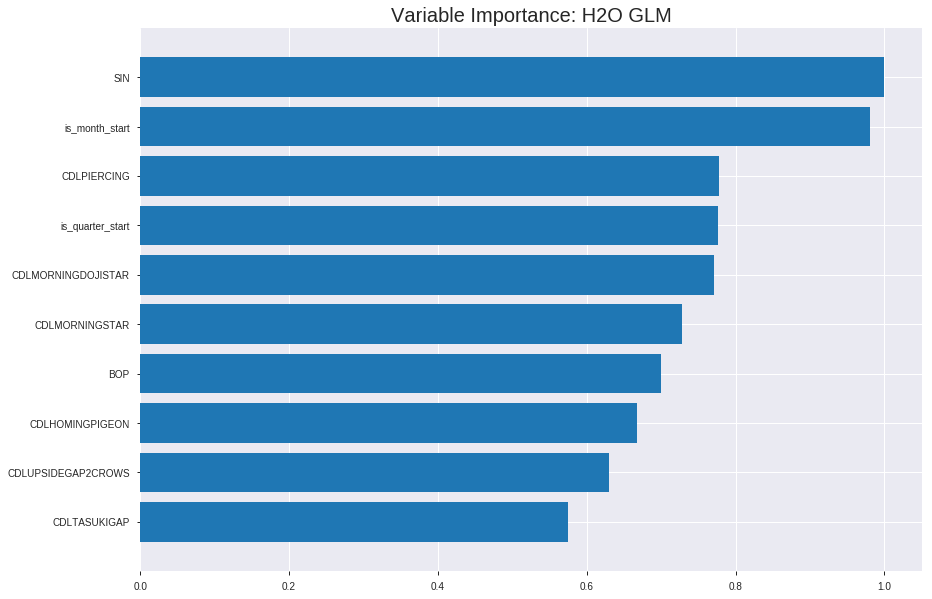

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_152414_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24864099394444
RMSE: 0.498639142009971
LogLoss: 0.6904236874200255
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2412.159208107115
Residual deviance: 2404.0552795965286
AIC: 2506.0552795965286
AUC: 0.5745968540750426
pr_auc: 0.5787566443631725
Gini: 0.14919370815008515
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48934749492187196: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      27   819   0.9681   (819.0/846.0)
1      6    889   0.0067   (6.0/895.0)
Total  33   1708  0.4739   (825.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489347     0.683058  368
max f2                       0.477725     0.842908  387
max f0point5                 0.513941     0.581371  203
max accuracy                 0.513941     0.566341  203
max precision                0.569515     1         0
max recall                   0.477725     1         387
max specificity              0.569515     1         0
max absolute_mcc             0.513941     0.130283  203
max min_per_class_accuracy   0.51464      0.556425  189
max mean_per_class_accuracy  0.514846     0.564814  185

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 51.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.536278           1.62104   1.62104            0.833333         0.542374  0.833333                    0.542374            0.0167598       0.0167598                  62.1043   62.1043
    2        0.0201034                   0.532852           1.02984   1.33389            0.529412         0.534112  0.685714                    0.538361            0.0100559       0.0268156                  2.9839    33.3887
    3        0.0304423                   0.528965           1.4049    1.35801            0.722222         0.530401  0.698113                    0.535658            0.0145251       0.0413408                  40.4904   35.8006
    4        0.0402068                   0.525386           0.800986  1.22273            0.411765         0.526876  0.628571                    0.533525            0.00782123      0.049162                   -19.9014  22.2729
    5        0.0505457                   0.523908           1.29683   1.23789            0.666667         0.524438  0.636364                    0.531666            0.0134078       0.0625698                  29.6834   23.7887
    6        0.100517                    0.520543           1.07324   1.15604            0.551724         0.521973  0.594286                    0.526847            0.0536313       0.116201                   7.32421   15.6035
    7        0.150488                    0.519171           1.14032   1.15082            0.586207         0.519767  0.591603                    0.524496            0.0569832       0.173184                   14.032    15.0817
    8        0.20046                     0.518346           1.16268   1.15377            0.597701         0.518731  0.593123                    0.523059            0.0581006       0.231285                   16.2679   15.3774
    9        0.300402                    0.516838           1.19622   1.16789            0.614943         0.517536  0.600382                    0.521221            0.119553        0.350838                   19.6218   16.7895
    10       0.400345                    0.515642           1.0397    1.13589            0.534483         0.516245  0.583931                    0.519979            0.103911        0.454749                   3.97033   13.5893
    11       0.500287                    0.514546           1.01734   1.11221            0.522989         0.515089  0.571757                    0.519002            0.101676        0.556425                   1.73441   11.221
    12       0.60023                     0.513444           0.916728  1.07966            0.471264         0.514016  0.555024                    0.518172            0.0916201       0.648045                   -8.32723  7.96611
    13       0.700172                    0.512227           0.950266  1.06119            0.488506         0.512813  0.545529                    0.517407            0.0949721       0.743017                   -4.97335  6.11913
    14       0.800115                    0.510719           0.883189  1.03896            0.454023         0.511525  0.534099                    0.516672            0.0882682       0.831285                   -11.6811  3.8957
    15       0.900057                    0.508368           0.927907  1.02663            0.477011         0.509693  0.52776                     0.515897            0.0927374       0.924022                   -7.20927  2.6626
    16       1                           0.399267           0.760213  1                  0.390805         0.497637  0.514072                    0.514072            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38631532620128106
RMSE: 0.62154269861473
LogLoss: 9.504148856690051
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 690.3187923549906
Residual deviance: 173613.81390270314
AIC: 173715.81390270314
AUC: 0.5395014922965233
pr_auc: 0.5369691896883497
Gini: 0.07900298459304667
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.624064886421937e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    245  1        (245.0/245.0)
1      0    253  0        (0.0/253.0)
Total  0    498  0.492    (245.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       6.62406e-49  0.673768  237
max f2                       6.62406e-49  0.837748  237
max f0point5                 6.62406e-49  0.563474  237
max accuracy                 0.499142     0.546185  150
max precision                0.517262     0.612903  30
max recall                   6.62406e-49  1         237
max specificity              0.542218     0.995918  0
max absolute_mcc             0.499142     0.10737   150
max min_per_class_accuracy   2.98825e-44  0.509881  236
max mean_per_class_accuracy  0.499142     0.549359  150

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 19.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.52537            0.393676  0.393676           0.2              0.533024      0.2                         0.533024            0.00395257      0.00395257                 -60.6324  -60.6324
    2        0.0200803                   0.521925           1.5747    0.98419            0.8              0.523852      0.5                         0.528438            0.0158103       0.0197628                  57.4704   -1.58103
    3        0.0301205                   0.519037           0.787352  0.918577           0.4              0.520593      0.466667                    0.525823            0.00790514      0.027668                   -21.2648  -8.14229
    4        0.0401606                   0.518184           1.18103   0.98419            0.6              0.518722      0.5                         0.524048            0.0118577       0.0395257                  18.1028   -1.58103
    5        0.0502008                   0.517517           1.5747    1.10229            0.8              0.51786       0.56                        0.52281             0.0158103       0.055336                   57.4704   10.2292
    6        0.100402                    0.515673           0.944822  1.02356            0.48             0.516589      0.52                        0.519699            0.0474308       0.102767                   -5.51779  2.35573
    7        0.150602                    0.513705           1.25976   1.10229            0.64             0.514588      0.56                        0.517996            0.0632411       0.166008                   25.9763   10.2292
    8        0.200803                    0.51192            1.10229   1.10229            0.56             0.512583      0.56                        0.516642            0.055336        0.221344                   10.2292   10.2292
    9        0.301205                    0.499603           1.25976   1.15478            0.64             0.507733      0.586667                    0.513673            0.126482        0.347826                   25.9763   15.4783
    10       0.399598                    0.18301            0.843591  1.07816            0.428571         0.397814      0.547739                    0.485145            0.083004        0.43083                    -15.6409  7.81576
    11       0.5                         5.02083e-153       0.905455  1.04348            0.46             0.0280544     0.53012                     0.393359            0.0909091       0.521739                   -9.45455  4.34783
    12       1                           0                  0.956522  1                  0.485944         1.00434e-179  0.508032                    0.19668             0.478261        1                          -4.34783  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:24:14  0.000 sec   2            2.6       51            1.38085           348.622
    2019-08-28 15:24:14  0.018 sec   4            1.6       51            1.37876           352.082
    2019-08-28 15:24:14  0.031 sec   6            1         51            1.37614           355.497
    2019-08-28 15:24:14  0.043 sec   8            0.63      51            1.37314           358.732
    2019-08-28 15:24:14  0.056 sec   10           0.39      51            1.37002           360.554

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5502008032128514)

('F1', 0.7098445595854922)

('auc', 0.48559697601668406)

('logloss', 10.679886540993872)

('mean_per_class_error', 0.48015510948905105)

('rmse', 0.6649215156297174)

('mse', 0.44212062194732044)

glm prediction progress: |████████████████████████████████████████████████| 100%


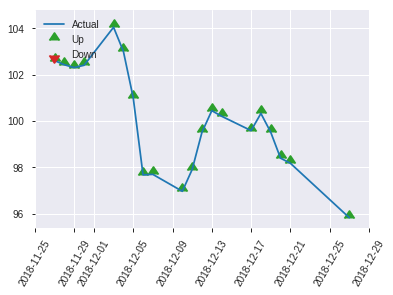


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.44212062194732044
RMSE: 0.6649215156297174
LogLoss: 10.679886540993872
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 343.9770046454541
Residual deviance: 73034.48153244254
AIC: 73136.48153244254
AUC: 0.48559697601668406
pr_auc: 0.5348076591387343
Gini: -0.028806047966631887
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.582535248752859e-53: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    137  0        (0.0/137.0)
Total  0    249  0.4498   (112.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.58254e-53  0.709845  145
max f2                       2.58254e-53  0.859473  145
max f0point5                 2.58254e-53  0.60459   145
max accuracy                 2.58254e-53  0.550201  145
max precision                0.515465     0.666667  20
max recall                   2.58254e-53  1         145
max specificity              0.531934     0.991071  0
max absolute_mcc             0.524165     0.122136  2
max min_per_class_accuracy   3.49051e-13  0.489051  123
max mean_per_class_accuracy  0.515465     0.519845  20

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 18.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.523132           0         0                  0                0.526941     0                           0.526941            0               0                          -100      -100
    2        0.0200803                   0.520634           0.908759  0.363504           0.5              0.521453     0.2                         0.524746            0.00729927      0.00729927                 -9.12409  -63.6496
    3        0.0321285                   0.520002           1.21168   0.681569           0.666667         0.520434     0.375                       0.523129            0.0145985       0.0218978                  21.1679   -31.8431
    4        0.0401606                   0.51959            1.81752   0.908759           1                0.519771     0.5                         0.522457            0.0145985       0.0364964                  81.7518   -9.12409
    5        0.0522088                   0.517731           1.21168   0.978664           0.666667         0.518607     0.538462                    0.521569            0.0145985       0.0510949                  21.1679   -2.13363
    6        0.100402                    0.513373           1.21168   1.09051            0.666667         0.515607     0.6                         0.518707            0.0583942       0.109489                   21.1679   9.05109
    7        0.15261                     0.510839           0.838855  1.00442            0.461538         0.511936     0.552632                    0.516391            0.0437956       0.153285                   -16.1145  0.441798
    8        0.200803                    0.507786           0.605839  0.908759           0.333333         0.50958      0.5                         0.514756            0.0291971       0.182482                   -39.4161  -9.12409
    9        0.301205                    0.476262           0.945109  0.920876           0.52             0.495889     0.506667                    0.508467            0.0948905       0.277372                   -5.48905  -7.91241
    10       0.401606                    0.0592215          1.09051   0.963285           0.6              0.342725     0.53                        0.467032            0.109489        0.386861                   9.05109   -3.67153
    11       0.502008                    1.97858e-13        1.01781   0.97419            0.56             0.00241577   0.536                       0.374108            0.10219         0.489051                   1.78102   -2.58102
    12       0.598394                    1.2701e-56         1.06022   0.988047           0.583333         3.38785e-15  0.543624                    0.313849            0.10219         0.591241                   6.0219    -1.19532
    13       1                           0                  1.01781   1                  0.56             1.26567e-58  0.550201                    0.187805            0.408759        1                          1.78102   0

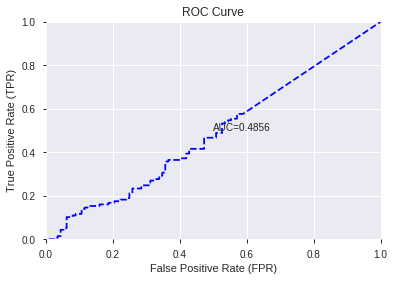

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


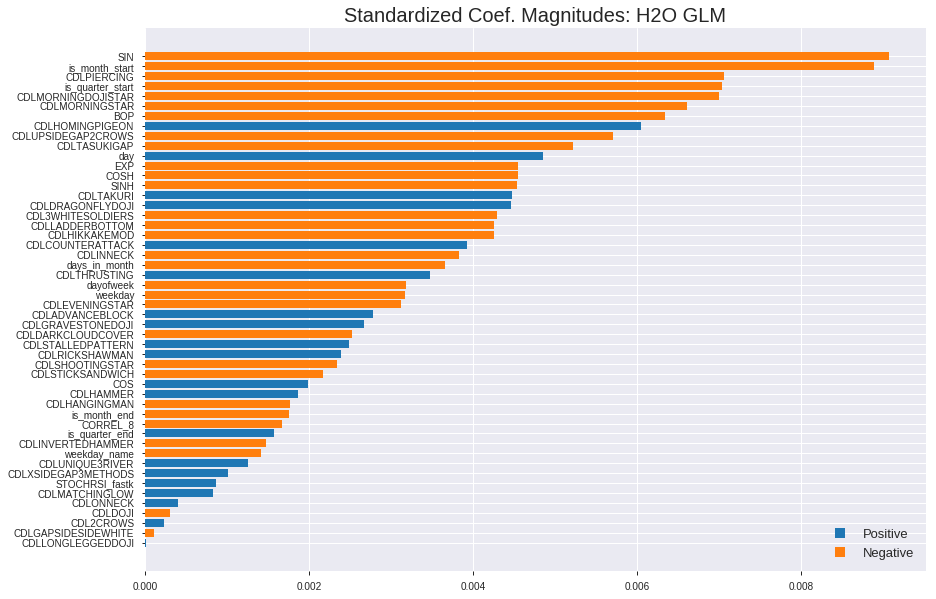

'log_likelihood'
--2019-08-28 15:24:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_152414_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_152414_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['SIN',
 'is_month_start',
 'CDLPIERCING',
 'is_quarter_start',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'BOP',
 'CDLHOMINGPIGEON',
 'CDLUPSIDEGAP2CROWS',
 'CDLTASUKIGAP',
 'day',
 'EXP',
 'COSH',
 'SINH',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDL3WHITESOLDIERS',
 'CDLLADDERBOTTOM',
 'CDLHIKKAKEMOD',
 'CDLCOUNTERATTACK',
 'CDLINNECK',
 'days_in_month',
 'CDLTHRUSTING',
 'dayofweek',
 'weekday',
 'CDLEVENINGSTAR',
 'CDLADVANCEBLOCK',
 'CDLGRAVESTONEDOJI',
 'CDLDARKCLOUDCOVER',
 'CDLSTALLEDPATTERN',
 'CDLRICKSHAWMAN',
 'CDLSHOOTINGSTAR',
 'CDLSTICKSANDWICH',
 'COS',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'is_month_end',
 'CORREL_8',
 'is_quarter_end',
 'CDLINVERTEDHAMMER',
 'weekday_name',
 'CDLUNIQUE3RIVER',
 'CDLXSIDEGAP3METHODS',
 'STOCHRSI_fastk',
 'CDLMATCHINGLOW',
 'CDLONNECK',
 'CDLDOJI',
 'CDL2CROWS',
 'CDLGAPSIDESIDEWHITE',
 'CDLLONGLEGGEDDOJI']

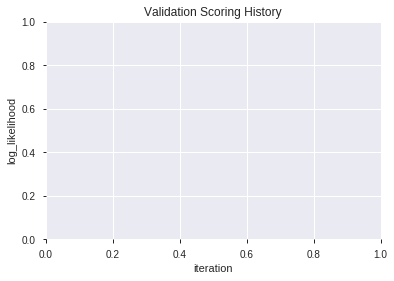

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_152426_model_4  0.535258  0.701747              0.500000  0.504131  0.254148
1  XGBoost_grid_1_AutoML_20190828_152426_model_2  0.525222  0.705848              0.500000  0.506110  0.256148
2  XGBoost_grid_1_AutoML_20190828_152426_model_7  0.519552  0.732929              0.500000  0.517800  0.268117
3  XGBoost_grid_1_AutoML_20190828_152426_model_3  0.516358  0.714000              0.495536  0.509818  0.259914
4               XGBoost_2_AutoML_20190828_152426  0.513947  0.718464              0.485792  0.511906  0.262048
5  XGBoost_grid_1_AutoML_20190828_152426_model_5  0.498110  0.761513              0.500000  0.528833  0.279664
6               XGBoost_3_AutoML_20190828_152426  0.494135  0.726486              0.500000  0.515316  0.265551
7  XGBoost_grid_1_AutoML_20190828_152426_model_1  0.489833  0.721689              0.500000  0.513470  0.263652
8               XGBoost_1_AutoML_20190828_152426  0.486770  0.740409              0.500000  0.521600  0.272067
9  XGBoost_grid_1_AutoML_20190828_152426_model_6  0.476734  0.722040              0.500000  0.513678  0.263865

variable  relative_importance  scaled_importance  percentage
0              SIN           333.504639           1.000000    0.176300
1              COS           301.139465           0.902954    0.159191
2             COSH           267.293488           0.801469    0.141299
3         CORREL_8           236.219513           0.708295    0.124872
4              BOP           222.164963           0.666153    0.117443
5              day           179.298889           0.537620    0.094782
6   STOCHRSI_fastk           175.341385           0.525754    0.092690
7     weekday_name            91.289474           0.273728    0.048258
8        dayofweek            41.190079           0.123507    0.021774
9    days_in_month            40.555153           0.121603    0.021439
10         weekday             3.693031           0.011073    0.001952

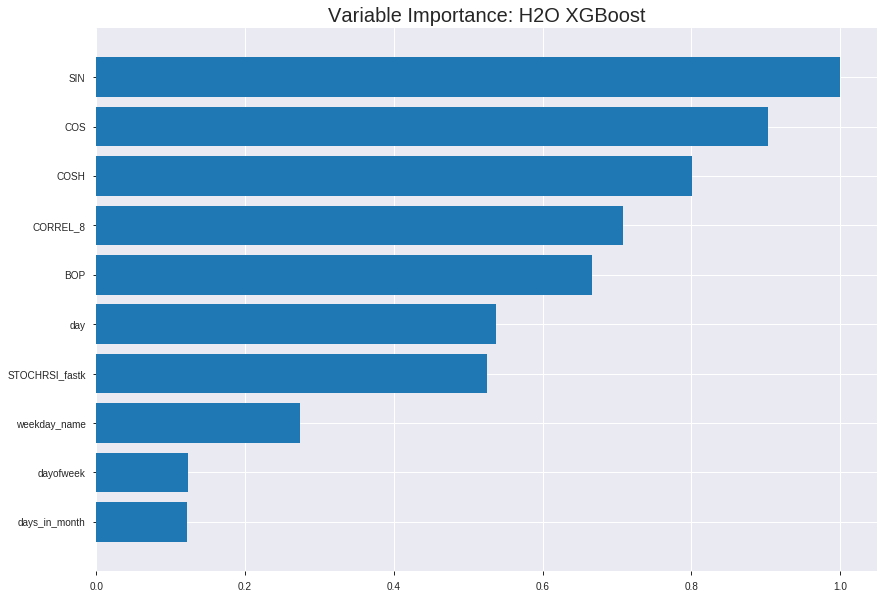

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_152426_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2290697192891378
RMSE: 0.47861228493336627
LogLoss: 0.6506744676249409
Mean Per-Class Error: 0.33380944834053117
AUC: 0.7102453874295073
pr_auc: 0.7052482731235912
Gini: 0.42049077485901454
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46124278008937836: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      325  521   0.6158   (521.0/846.0)
1      116  779   0.1296   (116.0/895.0)
Total  441  1300  0.3659   (637.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461243     0.709795  276
max f2                       0.38233      0.844402  370
max f0point5                 0.504683     0.673138  209
max accuracy                 0.500701     0.668007  217
max precision                0.717815     1         0
max recall                   0.342616     1         395
max specificity              0.717815     1         0
max absolute_mcc             0.492142     0.337855  229
max min_per_class_accuracy   0.512199     0.652482  198
max mean_per_class_accuracy  0.500701     0.666191  217

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 51.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.662549           1.72911   1.72911            0.888889         0.680755  0.888889                    0.680755            0.0178771       0.0178771                  72.9112   72.9112
    2        0.0201034                   0.646767           1.83082   1.77852            0.941176         0.65347   0.914286                    0.667502            0.0178771       0.0357542                  83.0825   77.8516
    3        0.0304423                   0.635395           1.62104   1.72503            0.833333         0.639973  0.886792                    0.658153            0.0167598       0.052514                   62.1043   72.5034
    4        0.0402068                   0.628786           1.60197   1.69515            0.823529         0.631946  0.871429                    0.651788            0.0156425       0.0681564                  60.1972   69.5148
    5        0.0505457                   0.620653           1.29683   1.61367            0.666667         0.624245  0.829545                    0.646154            0.0134078       0.0815642                  29.6834   61.3674
    6        0.100517                    0.601082           1.56514   1.58955            0.804598         0.609899  0.817143                    0.62813             0.0782123       0.159777                   56.5145   58.9548
    7        0.150488                    0.587804           1.34155   1.5072             0.689655         0.59397   0.774809                    0.616787            0.0670391       0.226816                   34.1553   50.7199
    8        0.20046                     0.573985           1.25212   1.44361            0.643678         0.580704  0.74212                     0.607792            0.0625698       0.289385                   25.2116   44.3611
    9        0.300402                    0.550688           1.2633    1.38362            0.649425         0.56191   0.711281                    0.592527            0.126257        0.415642                   26.3295   38.362
    10       0.400345                    0.531023           1.18504   1.33405            0.609195         0.540529  0.685796                    0.579546            0.118436        0.534078                   18.5038   33.4046
    11       0.500287                    0.513295           1.11796   1.29088            0.574713         0.522178  0.663605                    0.568086            0.111732        0.64581                    11.7961   29.0879
    12       0.60023                     0.492841           1.14032   1.26581            0.586207         0.503249  0.650718                    0.55729             0.113966        0.759777                   14.032    26.581
    13       0.700172                    0.471521           0.737854  1.19045            0.37931          0.482854  0.611977                    0.546665            0.073743        0.83352                    -26.2146  19.0449
    14       0.800115                    0.446834           0.726674  1.13252            0.373563         0.459801  0.582197                    0.535815            0.0726257       0.906145                   -27.3326  13.2519
    15       0.900057                    0.415981           0.55898   1.06883            0.287356         0.432503  0.549458                    0.524343            0.0558659       0.962011                   -44.102   6.88331
    16       1                           0.304738           0.380107  1                  0.195402         0.38976   0.514072                    0.510893           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2558588988295048
RMSE: 0.5058249685706556
LogLoss: 0.705125544975185
Mean Per-Class Error: 0.48051948051948057
AUC: 0.49027990642897473
pr_auc: 0.5152777146014355
Gini: -0.019440187142050536
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34058877825737: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    240  0.9796   (240.0/245.0)
1      1    252  0.004    (1.0/253.0)
Total  6    492  0.4839   (241.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.340589     0.67651   393
max f2                       0.329933     0.838859  397
max f0point5                 0.340589     0.567312  393
max accuracy                 0.348691     0.516064  387
max precision                0.65236      1         0
max recall                   0.329933     1         397
max specificity              0.65236      1         0
max absolute_mcc             0.60469      0.093791  7
max min_per_class_accuracy   0.472591     0.486166  199
max mean_per_class_accuracy  0.540813     0.519481  71

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 47.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.616374           1.5747    1.5747             0.8              0.640829  0.8                         0.640829            0.0158103       0.0158103                  57.4704   57.4704
    2        0.0200803                   0.603422           1.18103   1.37787            0.6              0.60711   0.7                         0.62397             0.0118577       0.027668                   18.1028   37.7866
    3        0.0301205                   0.596807           0.787352  1.18103            0.4              0.599104  0.6                         0.615681            0.00790514      0.0355731                  -21.2648  18.1028
    4        0.0401606                   0.587307           1.18103   1.18103            0.6              0.593051  0.6                         0.610023            0.0118577       0.0474308                  18.1028   18.1028
    5        0.0502008                   0.582953           0.393676  1.02356            0.2              0.58561   0.52                        0.605141            0.00395257      0.0513834                  -60.6324  2.35573
    6        0.100402                    0.566294           1.10229   1.06292            0.56             0.574701  0.54                        0.589921            0.055336        0.106719                   10.2292   6.29249
    7        0.150602                    0.544517           1.10229   1.07605            0.56             0.55635   0.546667                    0.578731            0.055336        0.162055                   10.2292   7.60474
    8        0.200803                    0.527455           1.02356   1.06292            0.52             0.535571  0.54                        0.567941            0.0513834       0.213439                   2.35573   6.29249
    9        0.301205                    0.501888           0.944822  1.02356            0.48             0.515836  0.52                        0.550572            0.0948617       0.3083                     -5.51779  2.35573
    10       0.399598                    0.487686           0.843591  0.979244           0.428571         0.494188  0.497487                    0.536689            0.083004        0.391304                   -15.6409  -2.0756
    11       0.5                         0.471455           0.944822  0.972332           0.48             0.480093  0.493976                    0.525324            0.0948617       0.486166                   -5.51779  -2.7668
    12       0.600402                    0.450307           1.06292   0.987481           0.54             0.459439  0.501672                    0.514306            0.106719        0.592885                   6.29249   -1.25187
    13       0.698795                    0.43105            1.00428   0.989846           0.510204         0.44204   0.502874                    0.504131            0.0988142       0.6917                     0.427523  -1.0154
    14       0.799197                    0.408819           0.866087  0.974298           0.44             0.422232  0.494975                    0.493842            0.0869565       0.778656                   -13.3913  -2.57016
    15       0.899598                    0.388719           1.14166   0.992977           0.58             0.39918   0.504464                    0.483277            0.114625        0.893281                   14.166    -0.702287
    16       1                           0.319763           1.06292   1                  0.54             0.363007  0.508032                    0.471202     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:24:33  2.353 sec   0                  0.5              0.693147            0.5             0                  1                0.485928                         0.5                0.693147              0.5               0                    1                  0.491968
    2019-08-28 15:24:33  2.448 sec   5                  0.496378         0.685924            0.64285         0.637362           1.43334          0.443998                         0.500601           0.69435               0.489401          0.488211             0.656126           0.487952
    2019-08-28 15:24:33  2.500 sec   10                 0.493891         0.680977            0.64997         0.645598           1.72911          0.45089                          0.500337           0.693821              0.50513           0.517782             1.5747             0.487952
    2019-08-28 15:24:33  2.556 sec   15                 0.491702         0.676627            0.6568          0.657868           1.72911          0.40896                          0.500825           0.694798              0.50142           0.511123             1.5747             0.481928
    2019-08-28 15:24:33  2.613 sec   20                 0.48966          0.67258             0.668798        0.670288           1.72911          0.368179                         0.501265           0.695686              0.501444          0.507928             1.18103            0.477912
    2019-08-28 15:24:33  2.675 sec   25                 0.487833         0.668968            0.682206        0.681876           1.83718          0.385985                         0.502323           0.69782               0.48815           0.5034               1.18103            0.475904
    2019-08-28 15:24:33  2.744 sec   30                 0.485939         0.665212            0.686586        0.686385           1.94525          0.39058                          0.502177           0.69754               0.503533          0.509095             0.787352           0.481928
    2019-08-28 15:24:33  2.804 sec   35                 0.483785         0.66095             0.696694        0.693908           1.83718          0.399196                         0.5027             0.698604              0.501154          0.51498              1.5747             0.473896
    2019-08-28 15:24:33  2.864 sec   40                 0.482088         0.657579            0.69996         0.696902           1.83718          0.377944                         0.503191           0.699623              0.499968          0.520515             1.5747             0.477912
    2019-08-28 15:24:34  2.931 sec   45                 0.480413         0.654256            0.704727        0.700878           1.72911          0.358989                         0.50418            0.701706              0.498863          0.526873             1.5747             0.483936
    2019-08-28 15:24:34  3.002 sec   50                 0.478612         0.650674            0.710245        0.705248           1.72911          0.365882                         0.505825           0.705126              0.49028           0.515278             1.5747             0.483936

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
SIN             333.505                1                    0.1763
COS             301.139                0.902954             0.159191
COSH            267.293                0.801469             0.141299
CORREL_8        236.22                 0.708295             0.124872
BOP             222.165                0.666153             0.117443
day             179.299                0.53762              0.0947824
STOCHRSI_fastk  175.341                0.525754             0.0926903
weekday_name    91.2895                0.273728             0.0482582
dayofweek       41.1901                0.123507             0.0217742
days_in_month   40.5552                0.121603             0.0214386
weekday         3.69303                0.0110734            0.00195224

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5542168674698795)

('F1', 0.7098445595854922)

('auc', 0.5352580813347237)

('logloss', 0.7017474384691205)

('mean_per_class_error', 0.4506647549530761)

('rmse', 0.5041307043986508)

('mse', 0.2541477671174799)

xgboost prediction progress: |████████████████████████████████████████████| 100%


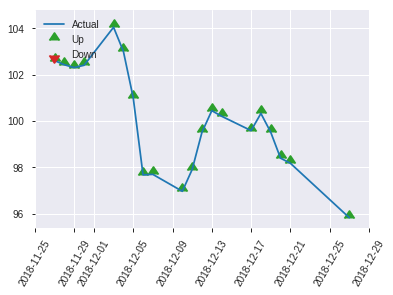


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2541477671174799
RMSE: 0.5041307043986508
LogLoss: 0.7017474384691205
Mean Per-Class Error: 0.4506647549530761
AUC: 0.5352580813347237
pr_auc: 0.5996682286590419
Gini: 0.07051616266944749
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3372286558151245: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    137  0        (0.0/137.0)
Total  0    249  0.4498   (112.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337229     0.709845  248
max f2                       0.337229     0.859473  248
max f0point5                 0.337229     0.60459   248
max accuracy                 0.421388     0.554217  185
max precision                0.63602      1         0
max recall                   0.337229     1         248
max specificity              0.63602      1         0
max absolute_mcc             0.590345     0.14383   9
max min_per_class_accuracy   0.46197      0.526786  125
max mean_per_class_accuracy  0.479714     0.549335  97

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 46.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.604535           1.81752   1.81752            1                0.61773   1                           0.61773             0.0218978       0.0218978                  81.7518   81.7518
    2        0.0200803                   0.59798            0.908759  1.45401            0.5              0.599245  0.8                         0.610336            0.00729927      0.0291971                  -9.12409  45.4015
    3        0.0321285                   0.593336           1.81752   1.59033            1                0.596488  0.875                       0.605143            0.0218978       0.0510949                  81.7518   59.0328
    4        0.0401606                   0.589066           1.81752   1.63577            1                0.591588  0.9                         0.602432            0.0145985       0.0656934                  81.7518   63.5766
    5        0.0522088                   0.578501           0.605839  1.39809            0.333333         0.585232  0.769231                    0.598463            0.00729927      0.0729927                  -39.4161  39.8091
    6        0.100402                    0.556362           0.908759  1.16321            0.5              0.566059  0.64                        0.582909            0.0437956       0.116788                   -9.12409  16.3212
    7        0.15261                     0.54162            1.11847   1.14791            0.615385         0.549301  0.631579                    0.571412            0.0583942       0.175182                   11.8473   14.7906
    8        0.200803                    0.529951           0.908759  1.09051            0.5              0.533654  0.6                         0.56235             0.0437956       0.218978                   -9.12409  9.05109
    9        0.301205                    0.501922           1.16321   1.11474            0.64             0.5147    0.613333                    0.546466            0.116788        0.335766                   16.3212   11.4745
    10       0.401606                    0.479418           1.01781   1.09051            0.56             0.489747  0.6                         0.532287            0.10219         0.437956                   1.78102   9.05109
    11       0.502008                    0.46399            0.872409  1.04689            0.48             0.471265  0.576                       0.520082            0.0875912       0.525547                   -12.7591  4.68905
    12       0.598394                    0.444502           0.833029  1.01244            0.458333         0.453693  0.557047                    0.509389            0.080292        0.605839                   -16.6971  1.24431
    13       0.698795                    0.428068           0.945109  1.00277            0.52             0.436711  0.551724                    0.498947            0.0948905       0.70073                    -5.48905  0.276869
    14       0.799197                    0.412957           1.09051   1.01379            0.6              0.421341  0.557789                    0.489197            0.109489        0.810219                   9.05109   1.37916
    15       0.899598                    0.394178           0.799708  0.989898           0.44             0.403476  0.544643                    0.47963             0.080292        0.890511                   -20.0292  -1.01017
    16       1                           0.337229           1.09051   1                  0.6              0.369821  0.550201                    0.468605       

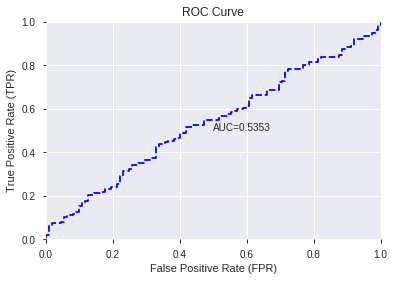

This function is available for GLM models only


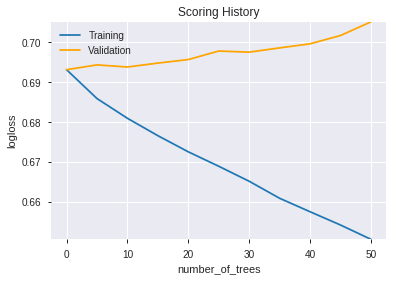

--2019-08-28 15:24:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.160.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.160.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_152426_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_152426_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SIN',
 'COS',
 'COSH',
 'CORREL_8',
 'BOP',
 'day',
 'STOCHRSI_fastk',
 'weekday_name',
 'dayofweek',
 'days_in_month',
 'weekday']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_152452_model_1  0.488725  9.856274                   0.5  0.661545  0.437642

variable  relative_importance  scaled_importance  percentage
0              is_month_start             0.005756           1.000000    0.008961
1                         SIN             0.005731           0.995630    0.008922
2                  aroonup_30             0.005643           0.980443    0.008786
3          CDLCLOSINGMARUBOZU             0.005159           0.896367    0.008032
4                 CDLPIERCING             0.004653           0.808365    0.007244
...                       ...                  ...                ...         ...
1035                MAVP_24_6             0.000006           0.001048    0.000009
1036                MAVP_14_6             0.000005           0.000909    0.000008
1037                     High             0.000003           0.000509    0.000005
1038  BBANDS_upperband_30_1_3             0.000002           0.000376    0.000003
1039                     CEIL             0.000001           0.000219    0.000002

[1040 rows x 4 columns]

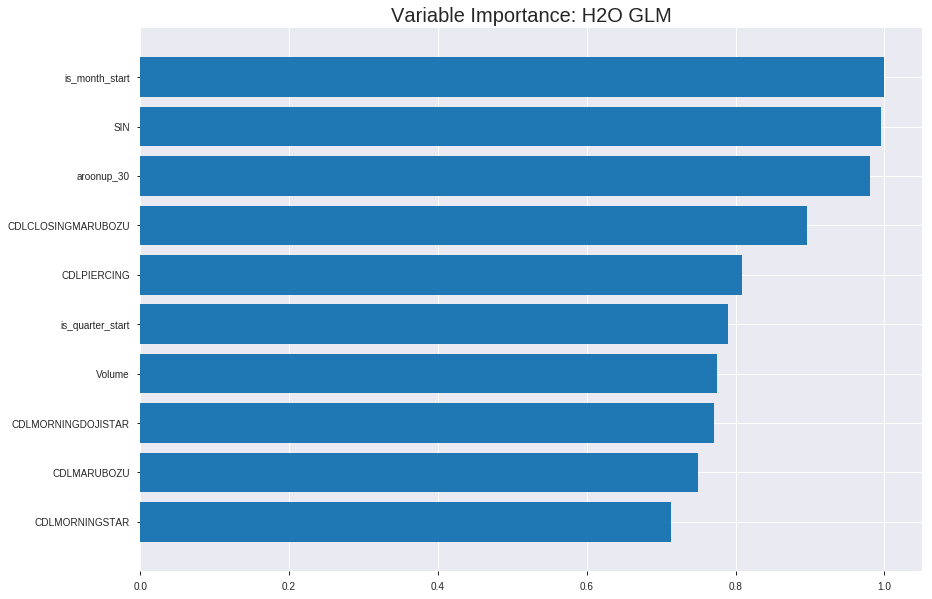

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_152452_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24637256882497915
RMSE: 0.4963593142321187
LogLoss: 0.6858611130121873
Null degrees of freedom: 1740
Residual degrees of freedom: 700
Null deviance: 2412.159208107115
Residual deviance: 2388.168395508436
AIC: 4470.168395508435
AUC: 0.5739913097454997
pr_auc: 0.5712132681722863
Gini: 0.14798261949099945
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4500326272092743: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      27   819   0.9681   (819.0/846.0)
1      7    888   0.0078   (7.0/895.0)
Total  34   1707  0.4744   (826.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450033     0.682552  375
max f2                       0.442715     0.841817  385
max f0point5                 0.496998     0.581653  254
max accuracy                 0.49998      0.562321  245
max precision                0.630116     1         0
max recall                   0.419792     1         397
max specificity              0.630116     1         0
max absolute_mcc             0.499766     0.121493  246
max min_per_class_accuracy   0.512575     0.548603  207
max mean_per_class_accuracy  0.49998      0.558997  245

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 51.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.601341           1.18876   1.18876            0.611111         0.60742   0.611111                    0.60742             0.0122905       0.0122905                  18.8765   18.8765
    2        0.0201034                   0.589986           1.02984   1.11157            0.529412         0.5967    0.571429                    0.602213            0.0100559       0.0223464                  2.9839    11.1572
    3        0.0304423                   0.583446           1.4049    1.21119            0.722222         0.586835  0.622642                    0.59699             0.0145251       0.0368715                  40.4904   21.1194
    4        0.0402068                   0.579842           1.14427   1.19494            0.588235         0.581692  0.614286                    0.593275            0.0111732       0.0480447                  14.4266   19.494
    5        0.0505457                   0.575983           1.4049    1.23789            0.722222         0.578222  0.636364                    0.590196            0.0145251       0.0625698                  40.4904   23.7887
    6        0.100517                    0.5623             1.07324   1.15604            0.551724         0.569457  0.594286                    0.579886            0.0536313       0.116201                   7.32421   15.6035
    7        0.150488                    0.552094           1.25212   1.18794            0.643678         0.556377  0.610687                    0.572079            0.0625698       0.178771                   25.2116   18.794
    8        0.20046                     0.545366           1.14032   1.17607            0.586207         0.54866   0.604585                    0.566241            0.0569832       0.235754                   14.032    17.6069
    9        0.300402                    0.533386           1.11796   1.15674            0.574713         0.539481  0.594646                    0.557338            0.111732        0.347486                   11.7961   15.6736
    10       0.400345                    0.522651           1.06206   1.1331             0.545977         0.527883  0.582496                    0.549985            0.106145        0.453631                   6.20625   13.3102
    11       0.500287                    0.512574           0.950266  1.09658            0.488506         0.517703  0.56372                     0.543536            0.0949721       0.548603                   -4.97335  9.65768
    12       0.60023                     0.50174            1.02852   1.08525            0.528736         0.507308  0.557895                    0.537504            0.102793        0.651397                   2.85237   8.52455
    13       0.700172                    0.492213           0.883189  1.0564             0.454023         0.496873  0.543068                    0.531704            0.0882682       0.739665                   -11.6811  5.6404
    14       0.800115                    0.481872           0.927907  1.04035            0.477011         0.487097  0.534817                    0.526132            0.0927374       0.832402                   -7.20927  4.03534
    15       0.900057                    0.468199           0.927907  1.02787            0.477011         0.475954  0.528398                    0.520561            0.0927374       0.92514                    -7.20927  2.78674
    16       1                           0.368908           0.749034  1                  0.385057         0.455641  0.514072                    0.514072            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38538084011961943
RMSE: 0.6207904961576163
LogLoss: 9.363174997612457
Null degrees of freedom: 497
Residual degrees of freedom: -543
Null deviance: 690.3187923549906
Residual deviance: 169277.61536286192
AIC: 171359.61536286192
AUC: 0.5441800435589255
pr_auc: 0.5764310650709894
Gini: 0.08836008711785093
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.23409166528372e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    245  1        (245.0/245.0)
1      0    253  0        (0.0/253.0)
Total  0    498  0.492    (245.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.23409e-48  0.673768  242
max f2                       1.23409e-48  0.837748  242
max f0point5                 1.23409e-48  0.563474  242
max accuracy                 0.47016      0.544177  109
max precision                0.545356     1         0
max recall                   1.23409e-48  1         242
max specificity              0.545356     1         0
max absolute_mcc             0.486735     0.133982  67
max min_per_class_accuracy   3.08684e-22  0.509881  237
max mean_per_class_accuracy  0.47016      0.548673  109

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 19.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.521423           1.96838   1.96838            1                0.531424     1                           0.531424            0.0197628       0.0197628                  96.8379   96.8379
    2        0.0200803                   0.517459           1.5747    1.77154            0.8              0.519787     0.9                         0.525605            0.0158103       0.0355731                  57.4704   77.1542
    3        0.0301205                   0.508544           1.18103   1.5747             0.6              0.512085     0.8                         0.521098            0.0118577       0.0474308                  18.1028   57.4704
    4        0.0401606                   0.507074           0.787352  1.37787            0.4              0.508186     0.7                         0.51787             0.00790514      0.055336                   -21.2648  37.7866
    5        0.0502008                   0.502856           1.5747    1.41723            0.8              0.505066     0.72                        0.515309            0.0158103       0.0711462                  57.4704   41.7233
    6        0.100402                    0.493032           1.18103   1.29913            0.6              0.496495     0.66                        0.505902            0.0592885       0.130435                   18.1028   29.913
    7        0.150602                    0.484534           1.18103   1.25976            0.6              0.488369     0.64                        0.500058            0.0592885       0.189723                   18.1028   25.9763
    8        0.200803                    0.474761           1.10229   1.2204             0.56             0.47904      0.62                        0.494803            0.055336        0.245059                   10.2292   22.0395
    9        0.301205                    0.455819           0.866087  1.10229            0.44             0.464803     0.56                        0.484803            0.0869565       0.332016                   -13.3913  10.2292
    10       0.399598                    0.253983           1.04445   1.08805            0.530612         0.391984     0.552764                    0.461948            0.102767        0.434783                   4.44462   8.80489
    11       0.5                         4.74624e-76        0.866087  1.04348            0.44             0.061638     0.53012                     0.381565            0.0869565       0.521739                   -13.3913  4.34783
    12       1                           0                  0.956522  1                  0.485944         2.79064e-90  0.508032                    0.190782            0.478261        1                          -4.34783  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:24:56  0.000 sec   2            4.3       1041          1.37172           339.915
    2019-08-28 15:24:59  2.393 sec   4            3.1       1041          1.36941           342.627
    2019-08-28 15:25:01  4.673 sec   6            2.3       1041          1.36666           345.857
    2019-08-28 15:25:03  6.984 sec   8            1.6       1041          1.36347           348.691
    2019-08-28 15:25:06  9.252 sec   10           1.2       1041          1.35981           350.728

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5502008032128514)

('F1', 0.7098445595854922)

('auc', 0.4887252346193952)

('logloss', 9.856273904894909)

('mean_per_class_error', 0.48419577685088633)

('rmse', 0.6615448414630845)

('mse', 0.4376415772664176)

glm prediction progress: |████████████████████████████████████████████████| 100%


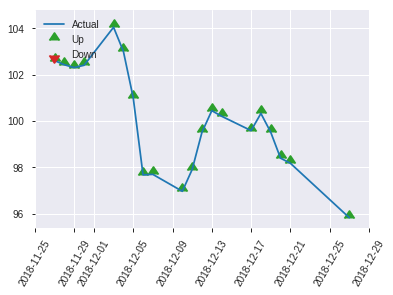


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.4376415772664176
RMSE: 0.6615448414630845
LogLoss: 9.856273904894909
Null degrees of freedom: 248
Residual degrees of freedom: -792
Null deviance: 343.9770046454541
Residual deviance: 65719.00309191078
AIC: 67801.00309191078
AUC: 0.4887252346193952
pr_auc: 0.5429167787157182
Gini: -0.02254953076120958
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.9242596555573696e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    137  0        (0.0/137.0)
Total  0    249  0.4498   (112.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.92426e-48  0.709845   154
max f2                       2.92426e-48  0.859473   154
max f0point5                 2.92426e-48  0.60459    154
max accuracy                 2.92426e-48  0.550201   154
max precision                0.517143     0.75       7
max recall                   2.92426e-48  1          154
max specificity              0.538131     0.991071   0
max absolute_mcc             0.536509     0.0995217  1
max min_per_class_accuracy   6.87235e-07  0.489051   123
max mean_per_class_accuracy  0.515206     0.515804   10

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 19.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.524647           0.605839  0.605839           0.333333         0.534338      0.333333                    0.534338            0.00729927      0.00729927                 -39.4161  -39.4161
    2        0.0200803                   0.519174           1.81752   1.09051            1                0.520152      0.6                         0.528664            0.0145985       0.0218978                  81.7518   9.05109
    3        0.0321285                   0.517089           1.81752   1.36314            1                0.517819      0.75                        0.524597            0.0218978       0.0437956                  81.7518   36.3139
    4        0.0401606                   0.515215           0.908759  1.27226            0.5              0.516172      0.7                         0.522912            0.00729927      0.0510949                  -9.12409  27.2263
    5        0.0522088                   0.513749           1.21168   1.25828            0.666667         0.514568      0.692308                    0.520986            0.0145985       0.0656934                  21.1679   25.8282
    6        0.100402                    0.496294           0.30292   0.799708           0.166667         0.503395      0.44                        0.512543            0.0145985       0.080292                   -69.708   -20.0292
    7        0.15261                     0.491547           1.39809   1.00442            0.769231         0.49382       0.552632                    0.506137            0.0729927       0.153285                   39.8091   0.441798
    8        0.200803                    0.483074           0.908759  0.98146            0.5              0.487367      0.54                        0.501633            0.0437956       0.19708                    -9.12409  -1.85401
    9        0.301205                    0.467888           0.872409  0.945109           0.48             0.477652      0.52                        0.493639            0.0875912       0.284672                   -12.7591  -5.48905
    10       0.401606                    0.176865           1.01781   0.963285           0.56             0.388281      0.53                        0.467299            0.10219         0.386861                   1.78102   -3.67153
    11       0.502008                    4.66626e-07        1.01781   0.97419            0.56             0.0243803     0.536                       0.378716            0.10219         0.489051                   1.78102   -2.58102
    12       0.598394                    2.03876e-28        1.06022   0.988047           0.583333         2.50313e-08   0.543624                    0.317714            0.10219         0.591241                   6.0219    -1.19532
    13       0.698795                    2.08847e-158       0.945109  0.981878           0.52             7.74313e-30   0.54023                     0.272066            0.0948905       0.686131                   -5.48905  -1.81223
    14       1                           0                  1.04204   1                  0.573333         7.23601e-173  0.550201                    0.190118            0.313869        1                          4.20438   0

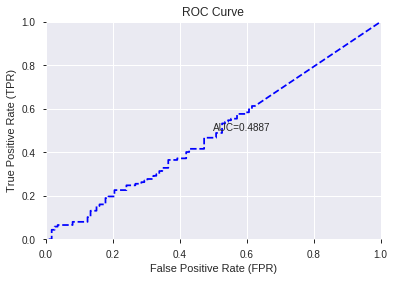

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


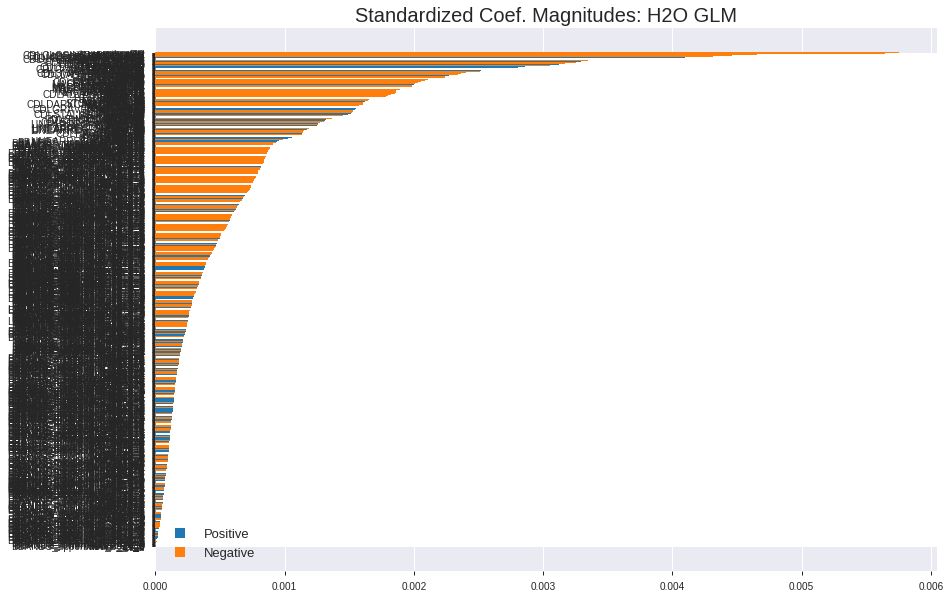

'log_likelihood'
--2019-08-28 15:25:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.224
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.224|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_152452_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_152452_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

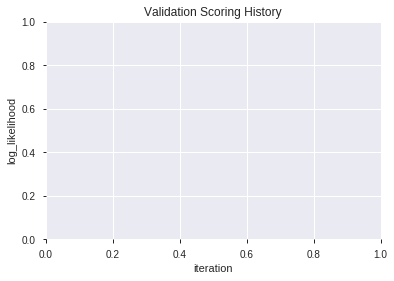

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_152539_model_4  0.540798  0.708169              0.500000  0.507280  0.257333
1  XGBoost_grid_1_AutoML_20190828_152539_model_2  0.538386  0.704063              0.485792  0.505325  0.255353
2  XGBoost_grid_1_AutoML_20190828_152539_model_6  0.534672  0.717625              0.500000  0.511352  0.261481
3  XGBoost_grid_1_AutoML_20190828_152539_model_1  0.534509  0.729127              0.495536  0.516385  0.266653
4  XGBoost_grid_1_AutoML_20190828_152539_model_3  0.520529  0.720357              0.500000  0.512673  0.262834
5               XGBoost_1_AutoML_20190828_152539  0.514664  0.731599              0.491071  0.517620  0.267930
6               XGBoost_2_AutoML_20190828_152539  0.509776  0.723071              0.481328  0.514280  0.264484
7  XGBoost_grid_1_AutoML_20190828_152539_model_5  0.502737  0.750725              0.495536  0.525835  0.276503
8               XGBoost_3_AutoML_20190828_152539  0.494851  0.722980              0.500000  0.513329  0.263506
9  XGBoost_grid_1_AutoML_20190828_152539_model_7  0.488269  0.760812              0.486607  0.530720  0.281664

variable  relative_importance  scaled_importance  percentage
0                        TAN           104.906929           1.000000    0.029838
1                        SIN           104.417671           0.995336    0.029699
2                    BETA_12            87.895676           0.837844    0.025000
3       HT_PHASOR_quadrature            71.970062           0.686037    0.020470
4               STOCHF_fastk            70.552391           0.672524    0.020067
..                       ...                  ...                ...         ...
173                    DX_30             6.015530           0.057342    0.001711
174   BBANDS_lowerband_8_3_5             5.553355           0.052936    0.001580
175  BBANDS_lowerband_30_2_3             5.396399           0.051440    0.001535
176              MINUS_DI_30             4.796150           0.045718    0.001364
177               MINUS_DI_8             4.734477           0.045130    0.001347

[178 rows x 4 columns]

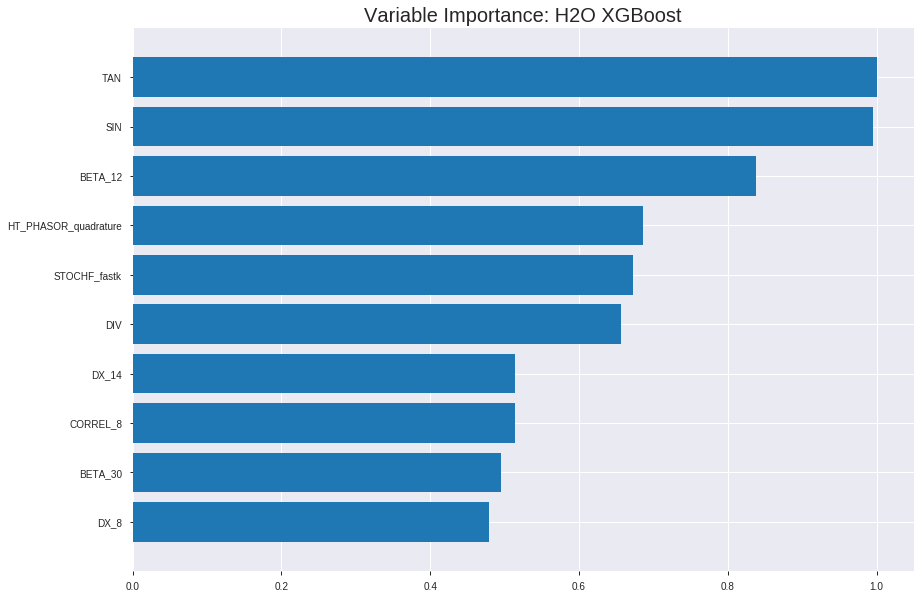

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_152539_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2106712128283329
RMSE: 0.4589893384691336
LogLoss: 0.6130958373650378
Mean Per-Class Error: 0.24935021197353302
AUC: 0.8326029821572434
pr_auc: 0.8385663645533614
Gini: 0.6652059643144868
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47853539139032364: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      499  347   0.4102   (347.0/846.0)
1      117  778   0.1307   (117.0/895.0)
Total  616  1125  0.2665   (464.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478535     0.770297  246
max f2                       0.434328     0.862898  302
max f0point5                 0.529532     0.774446  176
max accuracy                 0.509921     0.750718  204
max precision                0.72571      1         0
max recall                   0.372652     1         369
max specificity              0.72571      1         0
max absolute_mcc             0.529532     0.502954  176
max min_per_class_accuracy   0.510602     0.749409  203
max mean_per_class_accuracy  0.509921     0.75065   204

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 51.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.677578           1.94525   1.94525            1                0.695583  1                           0.695583            0.0201117       0.0201117                  94.5251   94.5251
    2        0.0201034                   0.663346           1.94525   1.94525            1                0.669023  1                           0.682683            0.0189944       0.0391061                  94.5251   94.5251
    3        0.0304423                   0.655264           1.94525   1.94525            1                0.659174  1                           0.674698            0.0201117       0.0592179                  94.5251   94.5251
    4        0.0402068                   0.648456           1.83082   1.91746            0.941176         0.652227  0.985714                    0.669241            0.0178771       0.077095                   83.0825   91.7462
    5        0.0505457                   0.642424           1.83718   1.90104            0.944444         0.645247  0.977273                    0.664333            0.0189944       0.0960894                  83.7182   90.1041
    6        0.100517                    0.618089           1.78874   1.84521            0.91954          0.629144  0.948571                    0.646839            0.0893855       0.185475                   78.8737   84.521
    7        0.150488                    0.601494           1.67694   1.78933            0.862069         0.6082    0.919847                    0.634009            0.0837989       0.269274                   67.6941   78.9334
    8        0.20046                     0.585195           1.74402   1.77804            0.896552         0.592753  0.91404                     0.623724            0.0871508       0.356425                   74.4018   77.8038
    9        0.300402                    0.554609           1.49807   1.68489            0.770115         0.569835  0.866157                    0.605796            0.149721        0.506145                   49.8067   68.4893
    10       0.400345                    0.533234           1.29683   1.58802            0.666667         0.543454  0.816356                    0.590233            0.129609        0.635754                   29.6834   58.8017
    11       0.500287                    0.51132            1.06206   1.48295            0.545977         0.523062  0.762342                    0.576814            0.106145        0.741899                   6.20625   48.2947
    12       0.60023                     0.488274           0.905548  1.38681            0.465517         0.499946  0.712919                    0.564015            0.0905028       0.832402                   -9.44519  38.6806
    13       0.700172                    0.464921           0.704315  1.28939            0.362069         0.476882  0.662838                    0.551577            0.0703911       0.902793                   -29.5685  28.9387
    14       0.800115                    0.437657           0.55898   1.19815            0.287356         0.452102  0.615937                    0.539152            0.0558659       0.958659                   -44.102   19.8152
    15       0.900057                    0.40147            0.301849  1.09863            0.155172         0.420171  0.564773                    0.52594             0.0301676       0.988827                   -69.8151  9.86263
    16       1                           0.300908           0.111796  1                  0.0574713        0.377505  0.514072                    0.511105          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2527695219296486
RMSE: 0.502761893871889
LogLoss: 0.698957019696793
Mean Per-Class Error: 0.45259336936355565
AUC: 0.5264580140356538
pr_auc: 0.5566964686195185
Gini: 0.052916028071307686
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33768200874328613: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   235  0.9592   (235.0/245.0)
1      3    250  0.0119   (3.0/253.0)
Total  13   485  0.4779   (238.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337682     0.677507  386
max f2                       0.310274     0.837748  399
max f0point5                 0.337682     0.569995  386
max accuracy                 0.518587     0.542169  80
max precision                0.605339     0.8       9
max recall                   0.310274     1         399
max specificity              0.649549     0.995918  0
max absolute_mcc             0.56263      0.129144  34
max min_per_class_accuracy   0.448676     0.514286  201
max mean_per_class_accuracy  0.518587     0.547407  80

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 45.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.613625           1.18103   1.18103            0.6              0.634859  0.6                         0.634859            0.0118577       0.0118577                  18.1028   18.1028
    2        0.0200803                   0.602052           1.96838   1.5747             1                0.609977  0.8                         0.622418            0.0197628       0.0316206                  96.8379   57.4704
    3        0.0301205                   0.593618           1.18103   1.44348            0.6              0.599642  0.733333                    0.614826            0.0118577       0.0434783                  18.1028   44.3478
    4        0.0401606                   0.579378           1.5747    1.47628            0.8              0.585168  0.75                        0.607411            0.0158103       0.0592885                  57.4704   47.6285
    5        0.0502008                   0.573469           1.5747    1.49597            0.8              0.576441  0.76                        0.601217            0.0158103       0.0750988                  57.4704   49.5968
    6        0.100402                    0.550335           1.02356   1.25976            0.52             0.562038  0.64                        0.581628            0.0513834       0.126482                   2.35573   25.9763
    7        0.150602                    0.526647           1.3385    1.28601            0.68             0.537851  0.653333                    0.567036            0.0671937       0.193676                   33.8498   28.6008
    8        0.200803                    0.508689           0.866087  1.18103            0.44             0.517762  0.6                         0.554717            0.0434783       0.237154                   -13.3913  18.1028
    9        0.301205                    0.486238           1.06292   1.14166            0.54             0.497418  0.58                        0.535617            0.106719        0.343874                   6.29249   14.166
    10       0.399598                    0.467611           0.80342   1.05837            0.408163         0.476987  0.537688                    0.521181            0.0790514       0.422925                   -19.658   5.83749
    11       0.5                         0.448854           0.905455  1.02767            0.46             0.458979  0.522088                    0.508691            0.0909091       0.513834                   -9.45455  2.7668
    12       0.600402                    0.433108           0.866087  1.00065            0.44             0.440869  0.508361                    0.497349            0.0869565       0.600791                   -13.3913  0.0647745
    13       0.698795                    0.41422            0.964104  0.995502           0.489796         0.423023  0.505747                    0.486884            0.0948617       0.695652                   -3.58958  -0.449775
    14       0.799197                    0.398452           0.98419   0.994081           0.5              0.405826  0.505025                    0.476701            0.0988142       0.794466                   -1.58103  -0.591892
    15       0.899598                    0.36897            1.14166   1.01055            0.58             0.385079  0.513393                    0.466475            0.114625        0.909091                   14.166    1.05519
    16       1                           0.310274           0.905455  1                  0.46             0.348744  0.508032                    0.454655     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:26:09  13.047 sec  0                  0.5              0.693147            0.5             0                  1                0.485928                         0.5                0.693147              0.5               0                    1                  0.491968
    2019-08-28 15:26:11  14.385 sec  5                  0.494451         0.6821              0.68542         0.682597           1.51297          0.391729                         0.499715           0.692576              0.528781          0.532727             1.31225            0.491968
    2019-08-28 15:26:11  14.873 sec  10                 0.489781         0.672861            0.710397        0.725497           1.72911          0.383688                         0.499486           0.69212               0.529749          0.54291              1.18103            0.481928
    2019-08-28 15:26:12  15.263 sec  15                 0.485011         0.663477            0.740561        0.751484           1.83718          0.375646                         0.499426           0.691995              0.541018          0.546989             1.5747             0.477912
    2019-08-28 15:26:12  15.643 sec  20                 0.480706         0.655063            0.766014        0.772412           1.94525          0.32108                          0.500402           0.69398               0.522812          0.538504             1.18103            0.491968
    2019-08-28 15:26:12  16.052 sec  25                 0.476522         0.646885            0.774517        0.785004           1.94525          0.314187                         0.500206           0.693598              0.527708          0.545738             0.787352           0.487952
    2019-08-28 15:26:13  16.453 sec  30                 0.472972         0.639993            0.787803        0.799213           1.94525          0.3027                           0.50105            0.695326              0.524345          0.544428             1.18103            0.48996
    2019-08-28 15:26:13  16.863 sec  35                 0.469246         0.63277             0.798224        0.810873           1.94525          0.302125                         0.501738           0.696761              0.522941          0.547006             1.5747             0.48996
    2019-08-28 15:26:14  17.283 sec  40                 0.465321         0.625235            0.816388        0.82713            1.94525          0.256175                         0.50112            0.695507              0.531669          0.55595              1.5747             0.471888
    2019-08-28 15:26:14  17.673 sec  45                 0.462312         0.61945             0.823902        0.832255           1.94525          0.258472                         0.501719           0.696802              0.531951          0.559383             1.18103            0.47992
    2019-08-28 15:26:14  18.080 sec  50                 0.458989         0.613096            0.832603        0.838566           1.94525          0.266513                         0.502762           0.698957              0.526458          0.556696             1.18103            0.477912

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
TAN                      104.90692901611328     1.0                   0.029838363907548578
SIN                      104.41767120361328     0.9953362678987119    0.029699205771943026
BETA_12                  87.89567565917969      0.8378443300506802    0.024999904017928433
HT_PHASOR_quadrature     71.97006225585938      0.6860372611308169    0.020470229451759244
STOCHF_fastk             70.5523910522461       0.6725236522881108    0.020067005473406316
---                      ---                    ---                   ---
DX_30                    6.015529632568359      0.05734158543182975   0.0017109790931507222
BBANDS_lowerband_8_3_5   5.5533552169799805     0.052936019279784724  0.0015795242070872242
BBANDS_lowerband_30_2_3  5.396398544311523      0.05143986765147475   0.0015348814903408399
MINUS_DI_30              4.796149730682373      0.045718140600090426  0.0013641545164019694
MINUS_DI_8               4.734476566314697      0.04513025603473247   0.0013466130028051877


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5742971887550201)

('F1', 0.7098445595854922)

('auc', 0.5407977059436914)

('logloss', 0.7081685481058)

('mean_per_class_error', 0.451055787278415)

('rmse', 0.507280376539527)

('mse', 0.25733338042208426)

xgboost prediction progress: |████████████████████████████████████████████| 100%


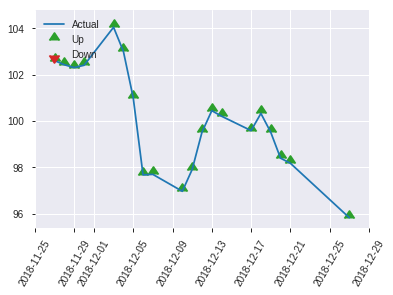


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25733338042208426
RMSE: 0.507280376539527
LogLoss: 0.7081685481058
Mean Per-Class Error: 0.451055787278415
AUC: 0.5407977059436914
pr_auc: 0.5836103647786676
Gini: 0.08159541188738273
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30598345398902893: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    137  0        (0.0/137.0)
Total  0    249  0.4498   (112.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.305983     0.709845  248
max f2                       0.305983     0.859473  248
max f0point5                 0.403846     0.616062  192
max accuracy                 0.404379     0.574297  190
max precision                0.606761     1         0
max recall                   0.305983     1         248
max specificity              0.606761     1         0
max absolute_mcc             0.404379     0.112904  190
max min_per_class_accuracy   0.445391     0.5       124
max mean_per_class_accuracy  0.464307     0.548944  88

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 44.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.564602           1.21168   1.21168            0.666667         0.580907  0.666667                    0.580907            0.0145985       0.0145985                  21.1679   21.1679
    2        0.0200803                   0.553356           0.908759  1.09051            0.5              0.560206  0.6                         0.572626            0.00729927      0.0218978                  -9.12409  9.05109
    3        0.0321285                   0.542568           1.81752   1.36314            1                0.548579  0.75                        0.563609            0.0218978       0.0437956                  81.7518   36.3139
    4        0.0401606                   0.538442           0.908759  1.27226            0.5              0.539949  0.7                         0.558877            0.00729927      0.0510949                  -9.12409  27.2263
    5        0.0522088                   0.535193           1.21168   1.25828            0.666667         0.536683  0.692308                    0.553755            0.0145985       0.0656934                  21.1679   25.8282
    6        0.100402                    0.522011           0.908759  1.09051            0.5              0.530243  0.6                         0.542469            0.0437956       0.109489                   -9.12409  9.05109
    7        0.15261                     0.502749           0.978664  1.05225            0.538462         0.509911  0.578947                    0.531331            0.0510949       0.160584                   -2.13363  5.22474
    8        0.200803                    0.487777           1.21168   1.09051            0.666667         0.495164  0.6                         0.522651            0.0583942       0.218978                   21.1679   9.05109
    9        0.301205                    0.473447           1.01781   1.06628            0.56             0.479376  0.586667                    0.508226            0.10219         0.321168                   1.78102   6.62774
    10       0.401606                    0.459253           1.01781   1.05416            0.56             0.465325  0.58                        0.497501            0.10219         0.423358                   1.78102   5.41606
    11       0.502008                    0.445391           0.799708  1.00327            0.44             0.45088   0.552                       0.488177            0.080292        0.50365                    -20.0292  0.327007
    12       0.598394                    0.430597           1.28741   1.04904            0.708333         0.438203  0.577181                    0.480127            0.124088        0.627737                   28.7409   4.90374
    13       0.698795                    0.417934           1.09051   1.055              0.6              0.424554  0.58046                     0.472142            0.109489        0.737226                   9.05109   5.49962
    14       0.799197                    0.400067           0.872409  1.03206            0.48             0.407085  0.567839                    0.463969            0.0875912       0.824818                   -12.7591  3.20581
    15       0.899598                    0.380651           0.872409  1.01424            0.48             0.390743  0.558036                    0.455797            0.0875912       0.912409                   -12.7591  1.42401
    16       1                           0.305983           0.872409  1                  0.48             0.355698  0.550201                    0.445747        

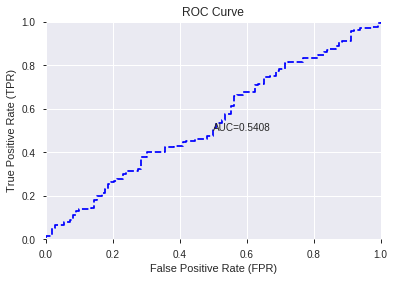

This function is available for GLM models only


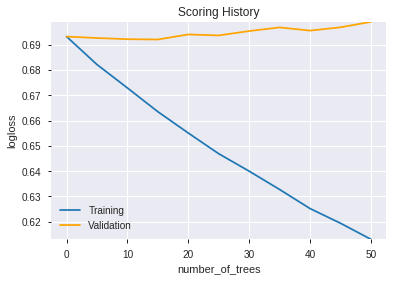

--2019-08-28 15:26:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.201.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.201.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_152539_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_152539_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_152643_model_8  0.541417   0.691061              0.471585  0.498957  0.248958
1  DeepLearning_grid_1_AutoML_20190828_152643_model_9  0.503650   0.688096              0.500000  0.497472  0.247479
2  DeepLearning_grid_1_AutoML_20190828_152643_model_1  0.494330  14.861343              0.500000  0.709304  0.503112
3  DeepLearning_grid_1_AutoML_20190828_152643_model_3  0.492310  14.300831              0.500000  0.706020  0.498464
4  DeepLearning_grid_1_AutoML_20190828_152643_model_7  0.489214  10.422599              0.500000  0.694992  0.483014
5  DeepLearning_grid_1_AutoML_20190828_152643_model_4  0.488139  12.682680              0.500000  0.693434  0.480851
6  DeepLearning_grid_1_AutoML_20190828_152643_model_6  0.487422  10.532219              0.500000  0.666358  0.444033
7  DeepLearning_grid_1_AutoML_20190828_152643_model_2  0.486216  14.034939              0.500000  0.707283  0.500249
8  DeepLearning_grid_1_AutoML_20190828_152643_model_5  0.479731  11.178799              0.500000  0.670349  0.449368
9               DeepLearning_1_AutoML_20190828_152643  0.478884  11.034816              0.500000  0.680262  0.462757

variable  relative_importance  scaled_importance  percentage
0                   SIN             1.000000           1.000000    0.036093
1                   day             0.854509           0.854509    0.030842
2                   BOP             0.850435           0.850435    0.030695
3          weekday_name             0.809940           0.809940    0.029233
4                   COS             0.806153           0.806153    0.029096
5        STOCHRSI_fastk             0.738040           0.738040    0.026638
6         days_in_month             0.673799           0.673799    0.024319
7        is_month_start             0.644421           0.644421    0.023259
8               CDLDOJI             0.643959           0.643959    0.023242
9             dayofweek             0.636976           0.636976    0.022990
10             CORREL_8             0.625922           0.625922    0.022591
11              weekday             0.622689           0.622689    0.022475
12       CDLRICKSHAWMAN             0.595947           0.595947    0.021509
13    CDLGRAVESTONEDOJI             0.580029           0.580029    0.020935
14    CDLLONGLEGGEDDOJI             0.566507           0.566507    0.020447
15     is_quarter_start             0.546544           0.546544    0.019726
16       CDLMATCHINGLOW             0.544914           0.544914    0.019668
17      CDLSHOOTINGSTAR             0.528336           0.528336    0.019069
18       CDLEVENINGSTAR             0.523740           0.523740    0.018903
19         is_month_end             0.522035           0.522035    0.018842
20    CDLSTALLEDPATTERN             0.518667           0.518667    0.018720
21       CDLMORNINGSTAR             0.517295           0.517295    0.018671
22         CDLTHRUSTING             0.515974           0.515974    0.018623
23    CDLINVERTEDHAMMER             0.513064           0.513064    0.018518
24   CDLMORNINGDOJISTAR             0.510074           0.510074    0.018410
25     CDLCOUNTERATTACK             0.508322           0.508322    0.018347
26         CDLTASUKIGAP             0.506571           0.506571    0.018284
27     CDLSTICKSANDWICH             0.499359           0.499359    0.018023
28                 COSH             0.497597           0.497597    0.017960
29                 SINH             0.496915           0.496915    0.017935
30   CDLUPSIDEGAP2CROWS             0.494832           0.494832    0.017860
31            CDLHAMMER             0.489811           0.489811    0.017679
32        CDLHANGINGMAN             0.487613           0.487613    0.017599
33                  EXP             0.486581           0.486581    0.017562
34  CDLGAPSIDESIDEWHITE             0.482289           0.482289    0.017407
35     CDLDRAGONFLYDOJI             0.480535           0.480535    0.017344
36            CDL2CROWS             0.479276           0.479276    0.017298
37  CDLXSIDEGAP3METHODS             0.478783           0.478783    0.017281
38      CDLHOMINGPIGEON             0.478509           0.478509    0.017271
39            CDLTAKURI             0.470303           0.470303    0.016975
40      CDLUNIQUE3RIVER             0.468898           0.468898    0.016924
41      CDLLADDERBOTTOM             0.468887           0.468887    0.016923
42          CDLPIERCING             0.462106           0.462106    0.016679
43      CDLADVANCEBLOCK             0.456322           0.456322    0.016470
44        CDLHIKKAKEMOD             0.448873           0.448873    0.016201
45            CDLINNECK             0.446803           0.446803    0.016126
46    CDL3WHITESOLDIERS             0.444895           0.444895    0.016058
47       is_quarter_end             0.437074           0.437074    0.015775
48            CDLONNECK             0.431457           0.431457    0.015573
49    CDLDARKCLOUDCOVER             0.413678           0.413678    0.014931

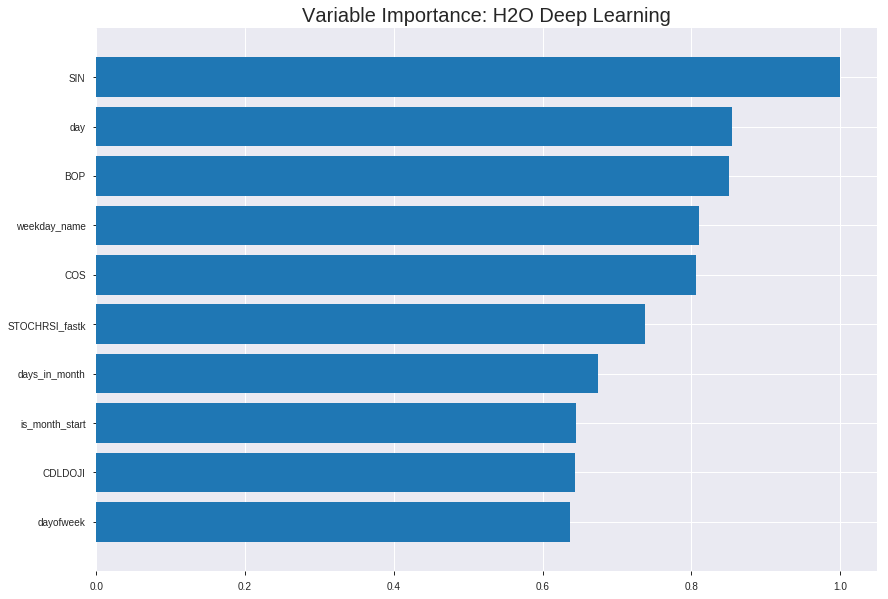

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_152643_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24735172805953895
RMSE: 0.4973446773210094
LogLoss: 0.6878054525878805
Mean Per-Class Error: 0.4492749316533935
AUC: 0.5654522762391537
pr_auc: 0.5853750938524029
Gini: 0.13090455247830746
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49583465488090306: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      37   809   0.9563   (809.0/846.0)
1      11   884   0.0123   (11.0/895.0)
Total  48   1693  0.471    (820.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495835     0.683153  353
max f2                       0.397743     0.841491  390
max f0point5                 0.509775     0.57897   314
max accuracy                 0.511101     0.547961  297
max precision                0.67636      1         0
max recall                   0.372814     1         396
max specificity              0.67636      1         0
max absolute_mcc             0.528145     0.134246  146
max min_per_class_accuracy   0.509951     0.475978  311
max mean_per_class_accuracy  0.511101     0.550725  297

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 51.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103389                   0.589205           1.4049    1.4049             0.722222         0.618195  0.722222                    0.618195            0.0145251       0.0145251                  40.4904    40.4904
    2        0.0201034                   0.571007           1.48755   1.44504            0.764706         0.579357  0.742857                    0.599331            0.0145251       0.0290503                  48.7545    44.5044
    3        0.0304423                   0.560468           1.51297   1.46811            0.777778         0.564483  0.754717                    0.587496            0.0156425       0.0446927                  51.2973    46.8114
    4        0.0402068                   0.550453           1.37312   1.44504            0.705882         0.553595  0.742857                    0.579263            0.0134078       0.0581006                  37.3119    44.5044
    5        0.0505457                   0.544188           0.972626  1.34841            0.5              0.5475    0.693182                    0.572766            0.0100559       0.0681564                  -2.73743   34.8413
    6        0.100517                    0.531314           1.31919   1.33389            0.678161         0.536313  0.685714                    0.554644            0.0659218       0.134078                   31.9193    33.3887
    7        0.150488                    0.525014           1.2074    1.29188            0.62069          0.527611  0.664122                    0.545667            0.0603352       0.194413                   20.7397    29.1885
    8        0.20046                     0.521841           0.939087  1.20394            0.482759         0.523397  0.618911                    0.540116            0.0469274       0.241341                   -6.09131   20.3938
    9        0.300402                    0.515641           0.994985  1.13442            0.511494         0.518557  0.583174                    0.532943            0.0994413       0.340782                   -0.501509  13.442
    10       0.400345                    0.511159           1.07324   1.11915            0.551724         0.513443  0.575323                    0.528075            0.107263        0.448045                   7.32421    11.9148
    11       0.869615                    0.509877           0.952387  1.02916            0.489596         0.509925  0.529062                    0.518281            0.446927        0.894972                   -4.76125   2.91588
    12       0.900057                    0.50963            0.954274  1.02663            0.490566         0.50974   0.52776                     0.517992            0.0290503       0.924022                   -4.57257   2.6626
    13       1                           0.365607           0.760213  1                  0.390805         0.489788  0.514072                    0.515173            0.0759777       1                          -23.9787   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2503529119334344
RMSE: 0.5003527874744322
LogLoss: 0.6938676356694335
Mean Per-Class Error: 0.4939017504234896
AUC: 0.49749132854722916
pr_auc: 0.5094358877057295
Gini: -0.005017342905541677
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5061076692853526: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    241  0.9837   (241.0/245.0)
1      2    251  0.0079   (2.0/253.0)
Total  6    492  0.488    (243.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.506108     0.673826   76
max f2                       0.364099     0.837748   82
max f0point5                 0.506108     0.565061   76
max accuracy                 0.506108     0.512048   76
max precision                0.535306     0.555556   8
max recall                   0.364099     1          82
max specificity              0.568594     0.995918   0
max absolute_mcc             0.562692     0.0791107  2
max min_per_class_accuracy   0.51072      0.126482   59
max mean_per_class_accuracy  0.51072      0.506098   59

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 51.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.546126           0.787352  0.787352           0.4              0.558814  0.4                         0.558814            0.00790514      0.00790514                 -21.2648  -21.2648
    2        0.0200803                   0.533075           1.18103   0.98419            0.6              0.539404  0.5                         0.549109            0.0118577       0.0197628                  18.1028   -1.58103
    3        0.0301205                   0.52889            0.787352  0.918577           0.4              0.531151  0.466667                    0.543123            0.00790514      0.027668                   -21.2648  -8.14229
    4        0.0401606                   0.526663           0.787352  0.885771           0.4              0.52797   0.45                        0.539335            0.00790514      0.0355731                  -21.2648  -11.4229
    5        0.0502008                   0.523259           0.393676  0.787352           0.2              0.525074  0.4                         0.536483            0.00395257      0.0395257                  -60.6324  -21.2648
    6        0.100402                    0.513904           1.25976   1.02356            0.64             0.517523  0.52                        0.527003            0.0632411       0.102767                   25.9763   2.35573
    7        0.955823                    0.509877           0.98881   0.99246            0.502347         0.509938  0.504202                    0.51173             0.84585         0.948617                   -1.11897  -0.753977
    8        1                           0.364099           1.16313   1                  0.590909         0.492254  0.508032                    0.51087             0.0513834       1                          16.3133   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:31:27  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:31:28  1 min  3.176 sec  622 obs/sec       0.554854  1             966        0.627186         1.17947             -0.574697      0.514435        0.525808           1.0807           0.481333                         0.649728           9.90539               -0.689022        0.534274          0.537759             0.787352           0.491968
    2019-08-28 15:31:39  1 min 14.085 sec  1122 obs/sec      7.39115   13            12868      0.499879         0.692905            -0.000308886   0.534078        0.547759           1.4049           0.480758                         0.617458           9.10972               -0.525411        0.533831          0.527224             0.787352           0.491968
    2019-08-28 15:31:49  1 min 24.036 sec  1221 obs/sec      14.3222   25            24935      0.508866         0.711598            -0.0365994     0.560872        0.566242           1.4049           0.479609                         0.61244            8.66849               -0.500718        0.534339          0.54048              1.5747             0.491968
    2019-08-28 15:31:59  1 min 34.337 sec  1277 obs/sec      21.8196   38            37988      0.497345         0.687805            0.00980873     0.565452        0.585375           1.4049           0.470994                         0.500353           0.693868              -0.00167014      0.497491          0.509436             0.787352           0.487952
    2019-08-28 15:32:10  1 min 44.413 sec  1363 obs/sec      30.3866   53            52903      0.493797         0.679339            0.0238839      0.580431        0.608715           1.94525          0.466973                         0.628158           9.97913               -0.578738        0.538985          0.549458             1.18103            0.491968
    2019-08-28 15:32:20  1 min 54.654 sec  1456 obs/sec      40.2022   70            69992      0.489997         0.670466            0.0388501      0.593011        0.628116           1.94525          0.445721                         0.628501           9.89379               -0.58046         0.53646           0.530321             1.18103            0.491968
    2019-08-28 15:32:30  2 min  4.999 sec  1535 obs/sec      50.61     88            88112      0.485914         0.661476            0.0548015      0.602355        0.670432           1.94525          0.443998                         0.631268           9.99462               -0.59441         0.538646          0.536101             0.787352           0.491968
    2019-08-28 15:32:31  2 min  6.005 sec  1534 obs/sec      50.61     88            88112      0.497345         0.687805            0.00980873     0.565452        0.585375           1.4049           0.470994                         0.500353           0.693868              -0.00167014      0.497491          0.509436             0.787352           0.487952

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
SIN                1.0                    1.0                  0.03609293278087067
day                0.8545085191726685     0.8545085191726685   0.03084171854318046
BOP                0.8504345417022705     0.8504345417022705   0.030694676748190604
weekday_name       0.8099397420883179     0.8099397420883179   0.029233100667749385
COS                0.8061525821685791     0.8061525821685791   0.029096410959335843
---                ---                    ---                  ---
CDLINNECK          0.4468029737472534     0.4468029737472534   0.01612642969775274
CDL3WHITESOLDIERS  0.444895476102829      0.444895476102829    0.01605758251349286
is_quarter_end     0.43707385659217834    0.43707385659217834  0.0157752773262574
CDLONNECK          0.4314570128917694     0.4314570128917694   0.015572548964137883
CDLDARKCLOUDCOVER  0.41367819905281067    0.41367819905281067  0.014930859431324732


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5783132530120482)

('F1', 0.7180851063829787)

('auc', 0.5414168404588112)

('logloss', 0.6910606545368163)

('mean_per_class_error', 0.4654913972888425)

('rmse', 0.49895667034218316)

('mse', 0.24895775887895802)

deeplearning prediction progress: |███████████████████████████████████████| 100%


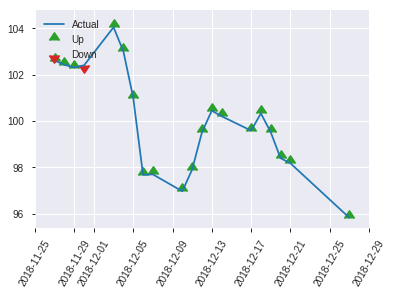


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24895775887895802
RMSE: 0.49895667034218316
LogLoss: 0.6910606545368163
Mean Per-Class Error: 0.4654913972888425
AUC: 0.5414168404588112
pr_auc: 0.6082430555065055
Gini: 0.08283368091762244
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5096456223429211: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    104  0.9286   (104.0/112.0)
1      2    135  0.0146   (2.0/137.0)
Total  10   239  0.4257   (106.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.509646     0.718085   23
max f2                       0.482545     0.859473   33
max f0point5                 0.509825     0.619758   18
max accuracy                 0.509825     0.578313   18
max precision                0.548377     1          0
max recall                   0.482545     1          33
max specificity              0.548377     1          0
max absolute_mcc             0.509825     0.144302   18
max min_per_class_accuracy   0.509877     0.0982143  17
max mean_per_class_accuracy  0.509825     0.534509   18

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 51.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.530287           1.21168   1.21168            0.666667         0.541442  0.666667                    0.541442            0.0145985       0.0145985                  21.1679   21.1679
    2        0.0200803                   0.51947            1.81752   1.45401            1                0.524947  0.8                         0.534844            0.0145985       0.0291971                  81.7518   45.4015
    3        0.0321285                   0.517939           0.605839  1.13595            0.333333         0.518978  0.625                       0.528894            0.00729927      0.0364964                  -39.4161  13.5949
    4        0.0401606                   0.514786           1.81752   1.27226            1                0.516343  0.7                         0.526384            0.0145985       0.0510949                  81.7518   27.2263
    5        0.0522088                   0.513868           0.605839  1.11847            0.333333         0.514272  0.615385                    0.523589            0.00729927      0.0583942                  -39.4161  11.8473
    6        0.935743                    0.509877           1.02442   1.02967            0.563636         0.509914  0.566524                    0.510677            0.905109        0.963504                   2.44194   2.9667
    7        1                           0.482545           0.567974  1                  0.3125           0.506982  0.550201                    0.510439            0.0364964       1                          -43.2026  0

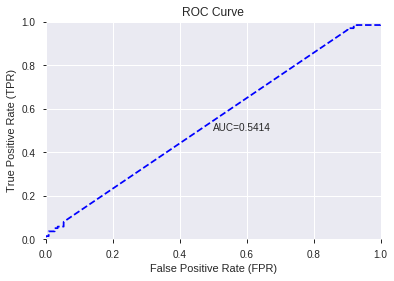

This function is available for GLM models only


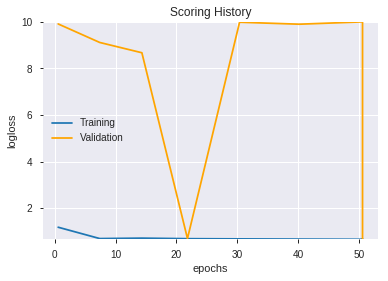

--2019-08-28 15:33:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_152643_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_152643_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['SIN',
 'day',
 'BOP',
 'weekday_name',
 'COS',
 'STOCHRSI_fastk',
 'days_in_month',
 'is_month_start',
 'CDLDOJI',
 'dayofweek',
 'CORREL_8',
 'weekday',
 'CDLRICKSHAWMAN',
 'CDLGRAVESTONEDOJI',
 'CDLLONGLEGGEDDOJI',
 'is_quarter_start',
 'CDLMATCHINGLOW',
 'CDLSHOOTINGSTAR',
 'CDLEVENINGSTAR',
 'is_month_end',
 'CDLSTALLEDPATTERN',
 'CDLMORNINGSTAR',
 'CDLTHRUSTING',
 'CDLINVERTEDHAMMER',
 'CDLMORNINGDOJISTAR',
 'CDLCOUNTERATTACK',
 'CDLTASUKIGAP',
 'CDLSTICKSANDWICH',
 'COSH',
 'SINH',
 'CDLUPSIDEGAP2CROWS',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'EXP',
 'CDLGAPSIDESIDEWHITE',
 'CDLDRAGONFLYDOJI',
 'CDL2CROWS',
 'CDLXSIDEGAP3METHODS',
 'CDLHOMINGPIGEON',
 'CDLTAKURI',
 'CDLUNIQUE3RIVER',
 'CDLLADDERBOTTOM',
 'CDLPIERCING',
 'CDLADVANCEBLOCK',
 'CDLHIKKAKEMOD',
 'CDLINNECK',
 'CDL3WHITESOLDIERS',
 'is_quarter_end',
 'CDLONNECK',
 'CDLDARKCLOUDCOVER']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_153355_model_1  0.485597  10.679887                   0.5  0.664922  0.442121

variable  relative_importance  scaled_importance  percentage
0                   SIN             0.009067           1.000000    0.053484
1        is_month_start             0.008889           0.980330    0.052432
2           CDLPIERCING             0.007057           0.778332    0.041628
3      is_quarter_start             0.007039           0.776314    0.041520
4    CDLMORNINGDOJISTAR             0.006993           0.771294    0.041252
5        CDLMORNINGSTAR             0.006604           0.728380    0.038956
6                   BOP             0.006340           0.699263    0.037399
7       CDLHOMINGPIGEON             0.006048           0.667039    0.035676
8    CDLUPSIDEGAP2CROWS             0.005710           0.629726    0.033680
9          CDLTASUKIGAP             0.005217           0.575413    0.030775
10                  day             0.004857           0.535690    0.028651
11                  EXP             0.004544           0.501125    0.026802
12                 COSH             0.004543           0.501027    0.026797
13                 SINH             0.004535           0.500136    0.026749
14            CDLTAKURI             0.004475           0.493494    0.026394
15     CDLDRAGONFLYDOJI             0.004465           0.492437    0.026337
16    CDL3WHITESOLDIERS             0.004297           0.473874    0.025345
17      CDLLADDERBOTTOM             0.004261           0.469931    0.025134
18        CDLHIKKAKEMOD             0.004257           0.469511    0.025111
19     CDLCOUNTERATTACK             0.003932           0.433676    0.023195
20            CDLINNECK             0.003824           0.421699    0.022554
21        days_in_month             0.003652           0.402822    0.021544
22         CDLTHRUSTING             0.003480           0.383837    0.020529
23            dayofweek             0.003178           0.350505    0.018746
24              weekday             0.003170           0.349635    0.018700
25       CDLEVENINGSTAR             0.003120           0.344144    0.018406
26      CDLADVANCEBLOCK             0.002778           0.306387    0.016387
27    CDLGRAVESTONEDOJI             0.002676           0.295140    0.015785
28    CDLDARKCLOUDCOVER             0.002522           0.278147    0.014876
29    CDLSTALLEDPATTERN             0.002493           0.274896    0.014702
30       CDLRICKSHAWMAN             0.002391           0.263652    0.014101
31      CDLSHOOTINGSTAR             0.002339           0.257999    0.013799
32     CDLSTICKSANDWICH             0.002174           0.239777    0.012824
33                  COS             0.001992           0.219740    0.011753
34            CDLHAMMER             0.001869           0.206149    0.011026
35        CDLHANGINGMAN             0.001766           0.194741    0.010415
36         is_month_end             0.001762           0.194283    0.010391
37             CORREL_8             0.001676           0.184853    0.009887
38       is_quarter_end             0.001571           0.173283    0.009268
39    CDLINVERTEDHAMMER             0.001481           0.163299    0.008734
40         weekday_name             0.001411           0.155658    0.008325
41      CDLUNIQUE3RIVER             0.001259           0.138830    0.007425
42  CDLXSIDEGAP3METHODS             0.001017           0.112141    0.005998
43       STOCHRSI_fastk             0.000872           0.096141    0.005142
44       CDLMATCHINGLOW             0.000837           0.092293    0.004936
45            CDLONNECK             0.000410           0.045220    0.002419
46              CDLDOJI             0.000312           0.034454    0.001843
47            CDL2CROWS             0.000233           0.025748    0.001377
48  CDLGAPSIDESIDEWHITE             0.000114           0.012619    0.000675
49    CDLLONGLEGGEDDOJI             0.000020           0.002184    0.000117

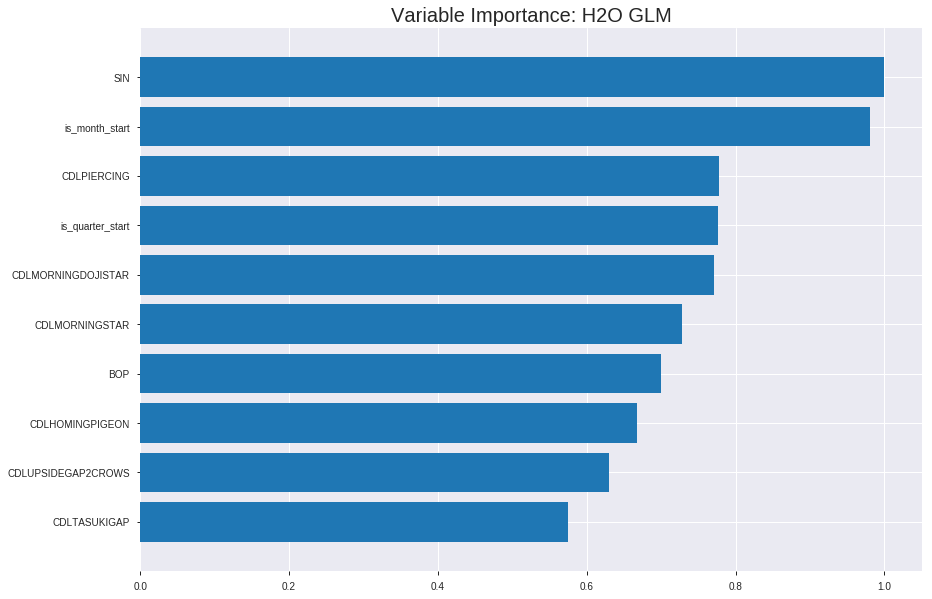

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_153355_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24864099394444
RMSE: 0.498639142009971
LogLoss: 0.6904236874200255
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2412.159208107115
Residual deviance: 2404.0552795965286
AIC: 2506.0552795965286
AUC: 0.5745968540750426
pr_auc: 0.5787566443631725
Gini: 0.14919370815008515
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48934749492187196: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      27   819   0.9681   (819.0/846.0)
1      6    889   0.0067   (6.0/895.0)
Total  33   1708  0.4739   (825.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489347     0.683058  368
max f2                       0.477725     0.842908  387
max f0point5                 0.513941     0.581371  203
max accuracy                 0.513941     0.566341  203
max precision                0.569515     1         0
max recall                   0.477725     1         387
max specificity              0.569515     1         0
max absolute_mcc             0.513941     0.130283  203
max min_per_class_accuracy   0.51464      0.556425  189
max mean_per_class_accuracy  0.514846     0.564814  185

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 51.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.536278           1.62104   1.62104            0.833333         0.542374  0.833333                    0.542374            0.0167598       0.0167598                  62.1043   62.1043
    2        0.0201034                   0.532852           1.02984   1.33389            0.529412         0.534112  0.685714                    0.538361            0.0100559       0.0268156                  2.9839    33.3887
    3        0.0304423                   0.528965           1.4049    1.35801            0.722222         0.530401  0.698113                    0.535658            0.0145251       0.0413408                  40.4904   35.8006
    4        0.0402068                   0.525386           0.800986  1.22273            0.411765         0.526876  0.628571                    0.533525            0.00782123      0.049162                   -19.9014  22.2729
    5        0.0505457                   0.523908           1.29683   1.23789            0.666667         0.524438  0.636364                    0.531666            0.0134078       0.0625698                  29.6834   23.7887
    6        0.100517                    0.520543           1.07324   1.15604            0.551724         0.521973  0.594286                    0.526847            0.0536313       0.116201                   7.32421   15.6035
    7        0.150488                    0.519171           1.14032   1.15082            0.586207         0.519767  0.591603                    0.524496            0.0569832       0.173184                   14.032    15.0817
    8        0.20046                     0.518346           1.16268   1.15377            0.597701         0.518731  0.593123                    0.523059            0.0581006       0.231285                   16.2679   15.3774
    9        0.300402                    0.516838           1.19622   1.16789            0.614943         0.517536  0.600382                    0.521221            0.119553        0.350838                   19.6218   16.7895
    10       0.400345                    0.515642           1.0397    1.13589            0.534483         0.516245  0.583931                    0.519979            0.103911        0.454749                   3.97033   13.5893
    11       0.500287                    0.514546           1.01734   1.11221            0.522989         0.515089  0.571757                    0.519002            0.101676        0.556425                   1.73441   11.221
    12       0.60023                     0.513444           0.916728  1.07966            0.471264         0.514016  0.555024                    0.518172            0.0916201       0.648045                   -8.32723  7.96611
    13       0.700172                    0.512227           0.950266  1.06119            0.488506         0.512813  0.545529                    0.517407            0.0949721       0.743017                   -4.97335  6.11913
    14       0.800115                    0.510719           0.883189  1.03896            0.454023         0.511525  0.534099                    0.516672            0.0882682       0.831285                   -11.6811  3.8957
    15       0.900057                    0.508368           0.927907  1.02663            0.477011         0.509693  0.52776                     0.515897            0.0927374       0.924022                   -7.20927  2.6626
    16       1                           0.399267           0.760213  1                  0.390805         0.497637  0.514072                    0.514072            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38631532620128106
RMSE: 0.62154269861473
LogLoss: 9.504148856690051
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 690.3187923549906
Residual deviance: 173613.81390270314
AIC: 173715.81390270314
AUC: 0.5395014922965233
pr_auc: 0.5369691896883497
Gini: 0.07900298459304667
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.624064886421937e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    245  1        (245.0/245.0)
1      0    253  0        (0.0/253.0)
Total  0    498  0.492    (245.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       6.62406e-49  0.673768  237
max f2                       6.62406e-49  0.837748  237
max f0point5                 6.62406e-49  0.563474  237
max accuracy                 0.499142     0.546185  150
max precision                0.517262     0.612903  30
max recall                   6.62406e-49  1         237
max specificity              0.542218     0.995918  0
max absolute_mcc             0.499142     0.10737   150
max min_per_class_accuracy   2.98825e-44  0.509881  236
max mean_per_class_accuracy  0.499142     0.549359  150

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 19.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.52537            0.393676  0.393676           0.2              0.533024      0.2                         0.533024            0.00395257      0.00395257                 -60.6324  -60.6324
    2        0.0200803                   0.521925           1.5747    0.98419            0.8              0.523852      0.5                         0.528438            0.0158103       0.0197628                  57.4704   -1.58103
    3        0.0301205                   0.519037           0.787352  0.918577           0.4              0.520593      0.466667                    0.525823            0.00790514      0.027668                   -21.2648  -8.14229
    4        0.0401606                   0.518184           1.18103   0.98419            0.6              0.518722      0.5                         0.524048            0.0118577       0.0395257                  18.1028   -1.58103
    5        0.0502008                   0.517517           1.5747    1.10229            0.8              0.51786       0.56                        0.52281             0.0158103       0.055336                   57.4704   10.2292
    6        0.100402                    0.515673           0.944822  1.02356            0.48             0.516589      0.52                        0.519699            0.0474308       0.102767                   -5.51779  2.35573
    7        0.150602                    0.513705           1.25976   1.10229            0.64             0.514588      0.56                        0.517996            0.0632411       0.166008                   25.9763   10.2292
    8        0.200803                    0.51192            1.10229   1.10229            0.56             0.512583      0.56                        0.516642            0.055336        0.221344                   10.2292   10.2292
    9        0.301205                    0.499603           1.25976   1.15478            0.64             0.507733      0.586667                    0.513673            0.126482        0.347826                   25.9763   15.4783
    10       0.399598                    0.18301            0.843591  1.07816            0.428571         0.397814      0.547739                    0.485145            0.083004        0.43083                    -15.6409  7.81576
    11       0.5                         5.02083e-153       0.905455  1.04348            0.46             0.0280544     0.53012                     0.393359            0.0909091       0.521739                   -9.45455  4.34783
    12       1                           0                  0.956522  1                  0.485944         1.00434e-179  0.508032                    0.19668             0.478261        1                          -4.34783  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:33:55  0.000 sec   2            2.6       51            1.38085           348.622
    2019-08-28 15:33:55  0.007 sec   4            1.6       51            1.37876           352.082
    2019-08-28 15:33:55  0.014 sec   6            1         51            1.37614           355.497
    2019-08-28 15:33:55  0.020 sec   8            0.63      51            1.37314           358.732
    2019-08-28 15:33:55  0.030 sec   10           0.39      51            1.37002           360.554

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5502008032128514)

('F1', 0.7098445595854922)

('auc', 0.48559697601668406)

('logloss', 10.679886540993872)

('mean_per_class_error', 0.48015510948905105)

('rmse', 0.6649215156297174)

('mse', 0.44212062194732044)

glm prediction progress: |████████████████████████████████████████████████| 100%


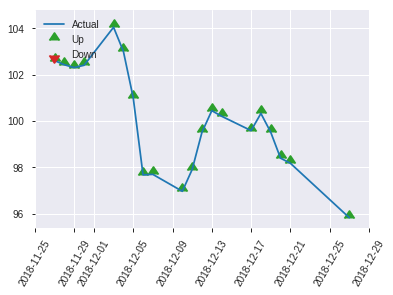


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.44212062194732044
RMSE: 0.6649215156297174
LogLoss: 10.679886540993872
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 343.9770046454541
Residual deviance: 73034.48153244254
AIC: 73136.48153244254
AUC: 0.48559697601668406
pr_auc: 0.5348076591387343
Gini: -0.028806047966631887
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.582535248752859e-53: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    137  0        (0.0/137.0)
Total  0    249  0.4498   (112.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.58254e-53  0.709845  145
max f2                       2.58254e-53  0.859473  145
max f0point5                 2.58254e-53  0.60459   145
max accuracy                 2.58254e-53  0.550201  145
max precision                0.515465     0.666667  20
max recall                   2.58254e-53  1         145
max specificity              0.531934     0.991071  0
max absolute_mcc             0.524165     0.122136  2
max min_per_class_accuracy   3.49051e-13  0.489051  123
max mean_per_class_accuracy  0.515465     0.519845  20

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 18.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.523132           0         0                  0                0.526941     0                           0.526941            0               0                          -100      -100
    2        0.0200803                   0.520634           0.908759  0.363504           0.5              0.521453     0.2                         0.524746            0.00729927      0.00729927                 -9.12409  -63.6496
    3        0.0321285                   0.520002           1.21168   0.681569           0.666667         0.520434     0.375                       0.523129            0.0145985       0.0218978                  21.1679   -31.8431
    4        0.0401606                   0.51959            1.81752   0.908759           1                0.519771     0.5                         0.522457            0.0145985       0.0364964                  81.7518   -9.12409
    5        0.0522088                   0.517731           1.21168   0.978664           0.666667         0.518607     0.538462                    0.521569            0.0145985       0.0510949                  21.1679   -2.13363
    6        0.100402                    0.513373           1.21168   1.09051            0.666667         0.515607     0.6                         0.518707            0.0583942       0.109489                   21.1679   9.05109
    7        0.15261                     0.510839           0.838855  1.00442            0.461538         0.511936     0.552632                    0.516391            0.0437956       0.153285                   -16.1145  0.441798
    8        0.200803                    0.507786           0.605839  0.908759           0.333333         0.50958      0.5                         0.514756            0.0291971       0.182482                   -39.4161  -9.12409
    9        0.301205                    0.476262           0.945109  0.920876           0.52             0.495889     0.506667                    0.508467            0.0948905       0.277372                   -5.48905  -7.91241
    10       0.401606                    0.0592215          1.09051   0.963285           0.6              0.342725     0.53                        0.467032            0.109489        0.386861                   9.05109   -3.67153
    11       0.502008                    1.97858e-13        1.01781   0.97419            0.56             0.00241577   0.536                       0.374108            0.10219         0.489051                   1.78102   -2.58102
    12       0.598394                    1.2701e-56         1.06022   0.988047           0.583333         3.38785e-15  0.543624                    0.313849            0.10219         0.591241                   6.0219    -1.19532
    13       1                           0                  1.01781   1                  0.56             1.26567e-58  0.550201                    0.187805            0.408759        1                          1.78102   0

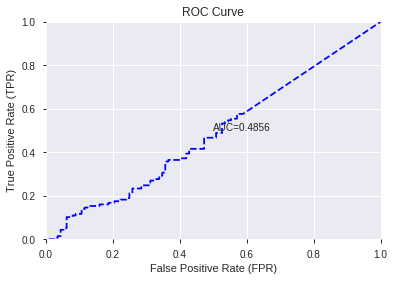

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


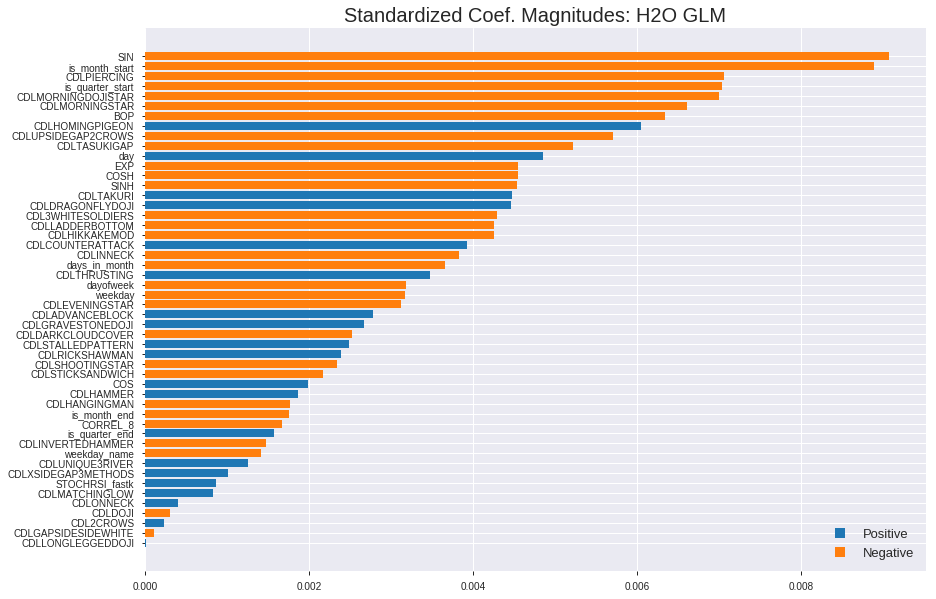

'log_likelihood'
--2019-08-28 15:34:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_153355_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_153355_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['SIN',
 'is_month_start',
 'CDLPIERCING',
 'is_quarter_start',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'BOP',
 'CDLHOMINGPIGEON',
 'CDLUPSIDEGAP2CROWS',
 'CDLTASUKIGAP',
 'day',
 'EXP',
 'COSH',
 'SINH',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDL3WHITESOLDIERS',
 'CDLLADDERBOTTOM',
 'CDLHIKKAKEMOD',
 'CDLCOUNTERATTACK',
 'CDLINNECK',
 'days_in_month',
 'CDLTHRUSTING',
 'dayofweek',
 'weekday',
 'CDLEVENINGSTAR',
 'CDLADVANCEBLOCK',
 'CDLGRAVESTONEDOJI',
 'CDLDARKCLOUDCOVER',
 'CDLSTALLEDPATTERN',
 'CDLRICKSHAWMAN',
 'CDLSHOOTINGSTAR',
 'CDLSTICKSANDWICH',
 'COS',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'is_month_end',
 'CORREL_8',
 'is_quarter_end',
 'CDLINVERTEDHAMMER',
 'weekday_name',
 'CDLUNIQUE3RIVER',
 'CDLXSIDEGAP3METHODS',
 'STOCHRSI_fastk',
 'CDLMATCHINGLOW',
 'CDLONNECK',
 'CDLDOJI',
 'CDL2CROWS',
 'CDLGAPSIDESIDEWHITE',
 'CDLLONGLEGGEDDOJI']

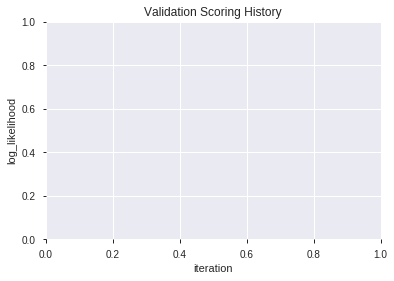

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_153411_model_4  0.535258  0.701747              0.500000  0.504131  0.254148
1  XGBoost_grid_1_AutoML_20190828_153411_model_2  0.525222  0.705848              0.500000  0.506110  0.256148
2  XGBoost_grid_1_AutoML_20190828_153411_model_7  0.519552  0.732929              0.500000  0.517800  0.268117
3  XGBoost_grid_1_AutoML_20190828_153411_model_3  0.516358  0.714000              0.495536  0.509818  0.259914
4               XGBoost_2_AutoML_20190828_153411  0.513947  0.718464              0.485792  0.511906  0.262048
5  XGBoost_grid_1_AutoML_20190828_153411_model_5  0.498110  0.761513              0.500000  0.528833  0.279664
6               XGBoost_3_AutoML_20190828_153411  0.494135  0.726486              0.500000  0.515316  0.265551
7  XGBoost_grid_1_AutoML_20190828_153411_model_1  0.489833  0.721689              0.500000  0.513470  0.263652
8               XGBoost_1_AutoML_20190828_153411  0.486770  0.740409              0.500000  0.521600  0.272067
9  XGBoost_grid_1_AutoML_20190828_153411_model_6  0.476734  0.722040              0.500000  0.513678  0.263865

variable  relative_importance  scaled_importance  percentage
0              SIN           333.504639           1.000000    0.176300
1              COS           301.139465           0.902954    0.159191
2             COSH           267.293488           0.801469    0.141299
3         CORREL_8           236.219513           0.708295    0.124872
4              BOP           222.164963           0.666153    0.117443
5              day           179.298889           0.537620    0.094782
6   STOCHRSI_fastk           175.341385           0.525754    0.092690
7     weekday_name            91.289474           0.273728    0.048258
8        dayofweek            41.190079           0.123507    0.021774
9    days_in_month            40.555153           0.121603    0.021439
10         weekday             3.693031           0.011073    0.001952

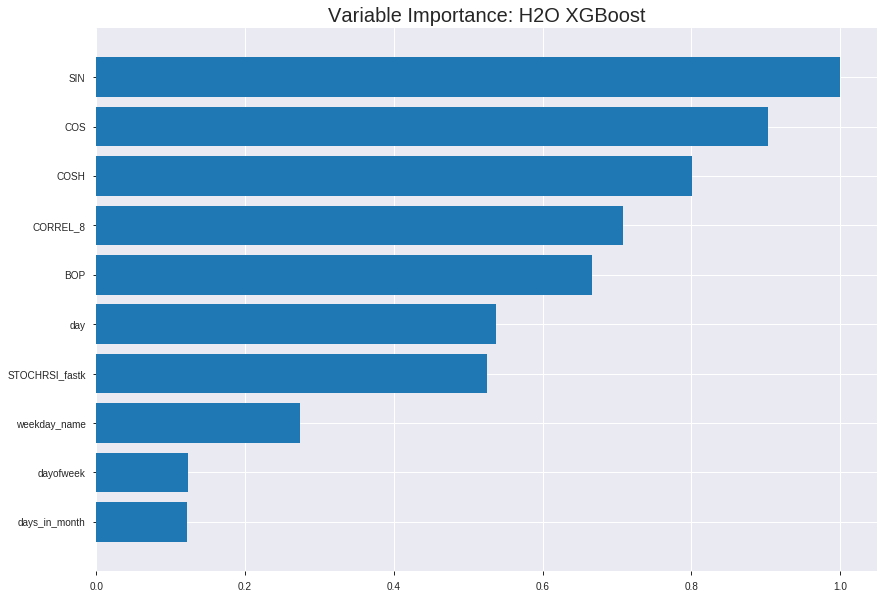

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_153411_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2290697192891378
RMSE: 0.47861228493336627
LogLoss: 0.6506744676249409
Mean Per-Class Error: 0.33380944834053117
AUC: 0.7102453874295073
pr_auc: 0.7052482731235912
Gini: 0.42049077485901454
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46124278008937836: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      325  521   0.6158   (521.0/846.0)
1      116  779   0.1296   (116.0/895.0)
Total  441  1300  0.3659   (637.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461243     0.709795  276
max f2                       0.38233      0.844402  370
max f0point5                 0.504683     0.673138  209
max accuracy                 0.500701     0.668007  217
max precision                0.717815     1         0
max recall                   0.342616     1         395
max specificity              0.717815     1         0
max absolute_mcc             0.492142     0.337855  229
max min_per_class_accuracy   0.512199     0.652482  198
max mean_per_class_accuracy  0.500701     0.666191  217

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 51.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.662549           1.72911   1.72911            0.888889         0.680755  0.888889                    0.680755            0.0178771       0.0178771                  72.9112   72.9112
    2        0.0201034                   0.646767           1.83082   1.77852            0.941176         0.65347   0.914286                    0.667502            0.0178771       0.0357542                  83.0825   77.8516
    3        0.0304423                   0.635395           1.62104   1.72503            0.833333         0.639973  0.886792                    0.658153            0.0167598       0.052514                   62.1043   72.5034
    4        0.0402068                   0.628786           1.60197   1.69515            0.823529         0.631946  0.871429                    0.651788            0.0156425       0.0681564                  60.1972   69.5148
    5        0.0505457                   0.620653           1.29683   1.61367            0.666667         0.624245  0.829545                    0.646154            0.0134078       0.0815642                  29.6834   61.3674
    6        0.100517                    0.601082           1.56514   1.58955            0.804598         0.609899  0.817143                    0.62813             0.0782123       0.159777                   56.5145   58.9548
    7        0.150488                    0.587804           1.34155   1.5072             0.689655         0.59397   0.774809                    0.616787            0.0670391       0.226816                   34.1553   50.7199
    8        0.20046                     0.573985           1.25212   1.44361            0.643678         0.580704  0.74212                     0.607792            0.0625698       0.289385                   25.2116   44.3611
    9        0.300402                    0.550688           1.2633    1.38362            0.649425         0.56191   0.711281                    0.592527            0.126257        0.415642                   26.3295   38.362
    10       0.400345                    0.531023           1.18504   1.33405            0.609195         0.540529  0.685796                    0.579546            0.118436        0.534078                   18.5038   33.4046
    11       0.500287                    0.513295           1.11796   1.29088            0.574713         0.522178  0.663605                    0.568086            0.111732        0.64581                    11.7961   29.0879
    12       0.60023                     0.492841           1.14032   1.26581            0.586207         0.503249  0.650718                    0.55729             0.113966        0.759777                   14.032    26.581
    13       0.700172                    0.471521           0.737854  1.19045            0.37931          0.482854  0.611977                    0.546665            0.073743        0.83352                    -26.2146  19.0449
    14       0.800115                    0.446834           0.726674  1.13252            0.373563         0.459801  0.582197                    0.535815            0.0726257       0.906145                   -27.3326  13.2519
    15       0.900057                    0.415981           0.55898   1.06883            0.287356         0.432503  0.549458                    0.524343            0.0558659       0.962011                   -44.102   6.88331
    16       1                           0.304738           0.380107  1                  0.195402         0.38976   0.514072                    0.510893           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2558588988295048
RMSE: 0.5058249685706556
LogLoss: 0.705125544975185
Mean Per-Class Error: 0.48051948051948057
AUC: 0.49027990642897473
pr_auc: 0.5152777146014355
Gini: -0.019440187142050536
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34058877825737: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    240  0.9796   (240.0/245.0)
1      1    252  0.004    (1.0/253.0)
Total  6    492  0.4839   (241.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.340589     0.67651   393
max f2                       0.329933     0.838859  397
max f0point5                 0.340589     0.567312  393
max accuracy                 0.348691     0.516064  387
max precision                0.65236      1         0
max recall                   0.329933     1         397
max specificity              0.65236      1         0
max absolute_mcc             0.60469      0.093791  7
max min_per_class_accuracy   0.472591     0.486166  199
max mean_per_class_accuracy  0.540813     0.519481  71

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 47.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.616374           1.5747    1.5747             0.8              0.640829  0.8                         0.640829            0.0158103       0.0158103                  57.4704   57.4704
    2        0.0200803                   0.603422           1.18103   1.37787            0.6              0.60711   0.7                         0.62397             0.0118577       0.027668                   18.1028   37.7866
    3        0.0301205                   0.596807           0.787352  1.18103            0.4              0.599104  0.6                         0.615681            0.00790514      0.0355731                  -21.2648  18.1028
    4        0.0401606                   0.587307           1.18103   1.18103            0.6              0.593051  0.6                         0.610023            0.0118577       0.0474308                  18.1028   18.1028
    5        0.0502008                   0.582953           0.393676  1.02356            0.2              0.58561   0.52                        0.605141            0.00395257      0.0513834                  -60.6324  2.35573
    6        0.100402                    0.566294           1.10229   1.06292            0.56             0.574701  0.54                        0.589921            0.055336        0.106719                   10.2292   6.29249
    7        0.150602                    0.544517           1.10229   1.07605            0.56             0.55635   0.546667                    0.578731            0.055336        0.162055                   10.2292   7.60474
    8        0.200803                    0.527455           1.02356   1.06292            0.52             0.535571  0.54                        0.567941            0.0513834       0.213439                   2.35573   6.29249
    9        0.301205                    0.501888           0.944822  1.02356            0.48             0.515836  0.52                        0.550572            0.0948617       0.3083                     -5.51779  2.35573
    10       0.399598                    0.487686           0.843591  0.979244           0.428571         0.494188  0.497487                    0.536689            0.083004        0.391304                   -15.6409  -2.0756
    11       0.5                         0.471455           0.944822  0.972332           0.48             0.480093  0.493976                    0.525324            0.0948617       0.486166                   -5.51779  -2.7668
    12       0.600402                    0.450307           1.06292   0.987481           0.54             0.459439  0.501672                    0.514306            0.106719        0.592885                   6.29249   -1.25187
    13       0.698795                    0.43105            1.00428   0.989846           0.510204         0.44204   0.502874                    0.504131            0.0988142       0.6917                     0.427523  -1.0154
    14       0.799197                    0.408819           0.866087  0.974298           0.44             0.422232  0.494975                    0.493842            0.0869565       0.778656                   -13.3913  -2.57016
    15       0.899598                    0.388719           1.14166   0.992977           0.58             0.39918   0.504464                    0.483277            0.114625        0.893281                   14.166    -0.702287
    16       1                           0.319763           1.06292   1                  0.54             0.363007  0.508032                    0.471202     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:34:18  2.327 sec   0                  0.5              0.693147            0.5             0                  1                0.485928                         0.5                0.693147              0.5               0                    1                  0.491968
    2019-08-28 15:34:18  2.423 sec   5                  0.496378         0.685924            0.64285         0.637362           1.43334          0.443998                         0.500601           0.69435               0.489401          0.488211             0.656126           0.487952
    2019-08-28 15:34:18  2.477 sec   10                 0.493891         0.680977            0.64997         0.645598           1.72911          0.45089                          0.500337           0.693821              0.50513           0.517782             1.5747             0.487952
    2019-08-28 15:34:18  2.529 sec   15                 0.491702         0.676627            0.6568          0.657868           1.72911          0.40896                          0.500825           0.694798              0.50142           0.511123             1.5747             0.481928
    2019-08-28 15:34:18  2.588 sec   20                 0.48966          0.67258             0.668798        0.670288           1.72911          0.368179                         0.501265           0.695686              0.501444          0.507928             1.18103            0.477912
    2019-08-28 15:34:18  2.642 sec   25                 0.487833         0.668968            0.682206        0.681876           1.83718          0.385985                         0.502323           0.69782               0.48815           0.5034               1.18103            0.475904
    2019-08-28 15:34:18  2.699 sec   30                 0.485939         0.665212            0.686586        0.686385           1.94525          0.39058                          0.502177           0.69754               0.503533          0.509095             0.787352           0.481928
    2019-08-28 15:34:18  2.766 sec   35                 0.483785         0.66095             0.696694        0.693908           1.83718          0.399196                         0.5027             0.698604              0.501154          0.51498              1.5747             0.473896
    2019-08-28 15:34:18  2.835 sec   40                 0.482088         0.657579            0.69996         0.696902           1.83718          0.377944                         0.503191           0.699623              0.499968          0.520515             1.5747             0.477912
    2019-08-28 15:34:18  2.902 sec   45                 0.480413         0.654256            0.704727        0.700878           1.72911          0.358989                         0.50418            0.701706              0.498863          0.526873             1.5747             0.483936
    2019-08-28 15:34:18  2.979 sec   50                 0.478612         0.650674            0.710245        0.705248           1.72911          0.365882                         0.505825           0.705126              0.49028           0.515278             1.5747             0.483936

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
SIN             333.505                1                    0.1763
COS             301.139                0.902954             0.159191
COSH            267.293                0.801469             0.141299
CORREL_8        236.22                 0.708295             0.124872
BOP             222.165                0.666153             0.117443
day             179.299                0.53762              0.0947824
STOCHRSI_fastk  175.341                0.525754             0.0926903
weekday_name    91.2895                0.273728             0.0482582
dayofweek       41.1901                0.123507             0.0217742
days_in_month   40.5552                0.121603             0.0214386
weekday         3.69303                0.0110734            0.00195224

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5542168674698795)

('F1', 0.7098445595854922)

('auc', 0.5352580813347237)

('logloss', 0.7017474384691205)

('mean_per_class_error', 0.4506647549530761)

('rmse', 0.5041307043986508)

('mse', 0.2541477671174799)

xgboost prediction progress: |████████████████████████████████████████████| 100%


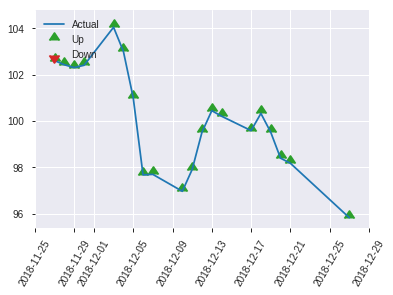


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2541477671174799
RMSE: 0.5041307043986508
LogLoss: 0.7017474384691205
Mean Per-Class Error: 0.4506647549530761
AUC: 0.5352580813347237
pr_auc: 0.5996682286590419
Gini: 0.07051616266944749
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3372286558151245: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    137  0        (0.0/137.0)
Total  0    249  0.4498   (112.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337229     0.709845  248
max f2                       0.337229     0.859473  248
max f0point5                 0.337229     0.60459   248
max accuracy                 0.421388     0.554217  185
max precision                0.63602      1         0
max recall                   0.337229     1         248
max specificity              0.63602      1         0
max absolute_mcc             0.590345     0.14383   9
max min_per_class_accuracy   0.46197      0.526786  125
max mean_per_class_accuracy  0.479714     0.549335  97

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 46.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.604535           1.81752   1.81752            1                0.61773   1                           0.61773             0.0218978       0.0218978                  81.7518   81.7518
    2        0.0200803                   0.59798            0.908759  1.45401            0.5              0.599245  0.8                         0.610336            0.00729927      0.0291971                  -9.12409  45.4015
    3        0.0321285                   0.593336           1.81752   1.59033            1                0.596488  0.875                       0.605143            0.0218978       0.0510949                  81.7518   59.0328
    4        0.0401606                   0.589066           1.81752   1.63577            1                0.591588  0.9                         0.602432            0.0145985       0.0656934                  81.7518   63.5766
    5        0.0522088                   0.578501           0.605839  1.39809            0.333333         0.585232  0.769231                    0.598463            0.00729927      0.0729927                  -39.4161  39.8091
    6        0.100402                    0.556362           0.908759  1.16321            0.5              0.566059  0.64                        0.582909            0.0437956       0.116788                   -9.12409  16.3212
    7        0.15261                     0.54162            1.11847   1.14791            0.615385         0.549301  0.631579                    0.571412            0.0583942       0.175182                   11.8473   14.7906
    8        0.200803                    0.529951           0.908759  1.09051            0.5              0.533654  0.6                         0.56235             0.0437956       0.218978                   -9.12409  9.05109
    9        0.301205                    0.501922           1.16321   1.11474            0.64             0.5147    0.613333                    0.546466            0.116788        0.335766                   16.3212   11.4745
    10       0.401606                    0.479418           1.01781   1.09051            0.56             0.489747  0.6                         0.532287            0.10219         0.437956                   1.78102   9.05109
    11       0.502008                    0.46399            0.872409  1.04689            0.48             0.471265  0.576                       0.520082            0.0875912       0.525547                   -12.7591  4.68905
    12       0.598394                    0.444502           0.833029  1.01244            0.458333         0.453693  0.557047                    0.509389            0.080292        0.605839                   -16.6971  1.24431
    13       0.698795                    0.428068           0.945109  1.00277            0.52             0.436711  0.551724                    0.498947            0.0948905       0.70073                    -5.48905  0.276869
    14       0.799197                    0.412957           1.09051   1.01379            0.6              0.421341  0.557789                    0.489197            0.109489        0.810219                   9.05109   1.37916
    15       0.899598                    0.394178           0.799708  0.989898           0.44             0.403476  0.544643                    0.47963             0.080292        0.890511                   -20.0292  -1.01017
    16       1                           0.337229           1.09051   1                  0.6              0.369821  0.550201                    0.468605       

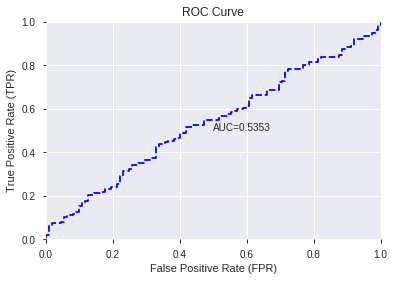

This function is available for GLM models only


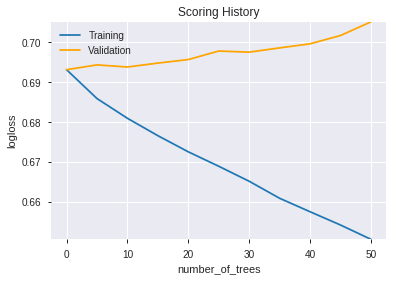

--2019-08-28 15:34:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.230.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.230.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_153411_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_153411_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SIN',
 'COS',
 'COSH',
 'CORREL_8',
 'BOP',
 'day',
 'STOCHRSI_fastk',
 'weekday_name',
 'dayofweek',
 'days_in_month',
 'weekday']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [893 906] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_153438_model_7  0.520203   8.176443              0.495536  0.611950  0.374483
1  DeepLearning_grid_1_AutoML_20190828_153438_model_5  0.500000   0.691431              0.500000  0.499141  0.249142
2  DeepLearning_grid_1_AutoML_20190828_153438_model_9  0.500000   0.691595              0.500000  0.499223  0.249224
3               DeepLearning_1_AutoML_20190828_153438  0.492896   6.736349              0.500000  0.653868  0.427543
4  DeepLearning_grid_1_AutoML_20190828_153438_model_4  0.488530  12.445839              0.500000  0.692354  0.479354
5  DeepLearning_grid_1_AutoML_20190828_153438_model_1  0.485401  14.525283              0.500000  0.736780  0.542844
6  DeepLearning_grid_1_AutoML_20190828_153438_model_6  0.481556   6.720638              0.500000  0.619350  0.383594
7  DeepLearning_grid_1_AutoML_20190828_153438_model_2  0.476277  10.740889              0.500000  0.671592  0.451036
8  DeepLearning_grid_1_AutoML_20190828_153438_model_3  0.473573  12.298109              0.500000  0.701065  0.491492
9  DeepLearning_grid_1_AutoML_20190828_153438_model_8  0.469988   0.689096              0.500000  0.497972  0.247976

variable  relative_importance  scaled_importance  percentage
0                 weekday_name             1.000000           1.000000    0.001309
1               CDLRICKSHAWMAN             0.931116           0.931116    0.001219
2                          COS             0.911095           0.911095    0.001192
3                     CORREL_8             0.893227           0.893227    0.001169
4                          SIN             0.890252           0.890252    0.001165
...                        ...                  ...                ...         ...
1035                  WILLR_30             0.673354           0.673354    0.000881
1036  BBANDS_middleband_24_2_5             0.672109           0.672109    0.000880
1037                 MAVP_14_5             0.670517           0.670517    0.000878
1038   BBANDS_upperband_30_5_4             0.668538           0.668538    0.000875
1039              aroondown_14             0.668365           0.668365    0.000875

[1040 rows x 4 columns]

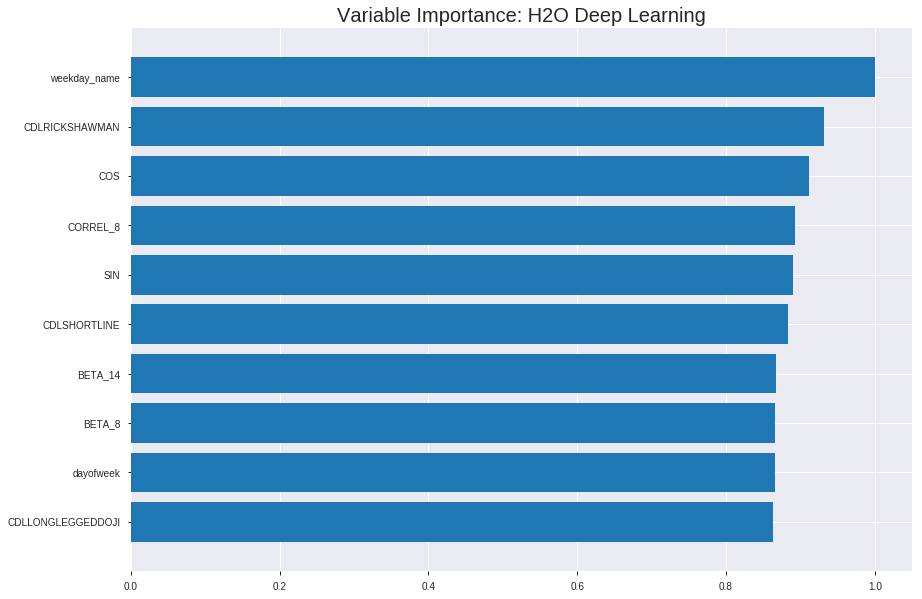

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_153438_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23626884035148557
RMSE: 0.4860749328565356
LogLoss: 0.6502305160050659
Mean Per-Class Error: 0.36592839124635157
AUC: 0.7255147456977957
pr_auc: 0.7674696548388628
Gini: 0.45102949139559145
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.634773174338187: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      241  605   0.7151   (605.0/846.0)
1      26   869   0.0291   (26.0/895.0)
Total  267  1474  0.3624   (631.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.634773     0.733643  246
max f2                       0.438715     0.866458  293
max f0point5                 0.754334     0.64608   182
max accuracy                 0.689908     0.640437  225
max precision                0.999981     1         0
max recall                   0.0458945    1         360
max specificity              0.999981     1         0
max absolute_mcc             0.634773     0.354835  246
max min_per_class_accuracy   0.747715     0.334515  186
max mean_per_class_accuracy  0.754334     0.634072  182

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 69.29 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103389                   0.999961           1.94525    1.94525            1                0.999983  1                           0.999983            0.0201117       0.0201117                  94.5251    94.5251
    2        0.0201034                   0.999837           1.94525    1.94525            1                0.999877  1                           0.999932            0.0189944       0.0391061                  94.5251    94.5251
    3        0.0304423                   0.999308           1.94525    1.94525            1                0.999607  1                           0.999821            0.0201117       0.0592179                  94.5251    94.5251
    4        0.0402068                   0.99802            1.94525    1.94525            1                0.998732  1                           0.999557            0.0189944       0.0782123                  94.5251    94.5251
    5        0.0505457                   0.996783           1.94525    1.94525            1                0.99732   1                           0.999099            0.0201117       0.098324                   94.5251    94.5251
    6        0.100517                    0.95534            1.8111     1.87856            0.931034         0.982124  0.965714                    0.99066             0.0905028       0.188827                   81.1096    87.8557
    7        0.150488                    0.854869           1.45335    1.73736            0.747126         0.907779  0.89313                     0.963138            0.0726257       0.261453                   45.3349    73.7362
    8        0.20046                     0.752188           1.38627    1.64984            0.712644         0.796295  0.848138                    0.921547            0.0692737       0.330726                   38.6271    64.9841
    9        0.79954                     0.747715           0.994074   1.15849            0.511026         0.747724  0.595546                    0.791304            0.595531        0.926257                   -0.592618  15.8487
    10       0.800115                    0.746678           0          1.15765            0                0.746678  0.595118                    0.791272            0               0.926257                   -100       15.7655
    11       0.900057                    0.215617           0.670776   1.10359            0.344828         0.567512  0.567326                    0.766426            0.0670391       0.993296                   -32.9224   10.3592
    12       1                           1.66569e-08        0.0670776  1                  0.0344828        0.030477  0.514072                    0.692873            0.00670391      1                          -93.2922   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.40741705179551085
RMSE: 0.6382922933856485
LogLoss: 10.005425377619758
Mean Per-Class Error: 0.46803258852948293
AUC: 0.4934822941034121
pr_auc: 0.2457801328833609
Gini: -0.0130354117931758
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6290794221512181: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      22   223  0.9102   (223.0/245.0)
1      10   243  0.0395   (10.0/253.0)
Total  32   466  0.4679   (233.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.629079     0.675939  54
max f2                       0.0326952    0.837748  86
max f0point5                 0.747715     0.575112  29
max accuracy                 0.747715     0.538153  29
max precision                0.747715     0.526077  29
max recall                   0.0326952    1         86
max specificity              1            0.432653  0
max absolute_mcc             0.629079     0.102491  54
max min_per_class_accuracy   1            0.432653  0
max mean_per_class_accuracy  0.747715     0.531967  29

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 86.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.536145                    1                  0.951015  0.951015           0.483146         1         0.483146                    1                   0.509881        0.509881                   -4.89852  -4.89852
    2        0.885542                    0.747715           1.16519   1.03552            0.591954         0.772491  0.526077                    0.910234            0.407115        0.916996                   16.519    3.55193
    3        0.899598                    0.73142            0.562394  1.02813            0.285714         0.742893  0.522321                    0.90762             0.00790514      0.924901                   -43.7606  2.81268
    4        1                           0.0326952          0.747984  1                  0.38             0.451007  0.508032                    0.861775            0.0750988       1                          -25.2016  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:48:59  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 15:49:03  6.543 sec         114 obs/sec       0.240092  1             418        0.645481         1.77488             -0.667903      0.531016        0.510149           0.864556         0.48363                          0.689047           11.4055               -0.899631        0.473518          0.213797             0.953327           0.491968
    2019-08-28 15:49:31  34.942 sec        168 obs/sec       2.81562   12            4902       0.508543         0.715957            -0.0352856     0.577496        0.575068           1.4049           0.466399                         0.649214           10.2007               -0.686352        0.466798          0.229138             0.955029           0.483936
    2019-08-28 15:50:01  1 min  4.202 sec  213 obs/sec       6.834     29            11898      0.493929         0.683285            0.0233644      0.613265        0.647047           1.94525          0.435956                         0.647167           10.2467               -0.675732        0.463338          0.227532             0.955029           0.491968
    2019-08-28 15:50:29  1 min 32.699 sec  245 obs/sec       11.4888   49            20002      0.522047         0.75773             -0.0909969     0.644779        0.684789           1.83718          0.412407                         0.654353           10.4021               -0.713153        0.471001          0.225732             0.962638           0.491968
    2019-08-28 15:50:57  2 min  1.027 sec  264 obs/sec       16.2194   69            28238      0.50524          0.705196            -0.0218776     0.654303        0.692954           1.94525          0.394026                         0.646983           10.545                -0.674779        0.484077          0.229761             0.970029           0.47992
    2019-08-28 15:51:26  2 min 29.844 sec  274 obs/sec       20.9529   89            36479      0.444458         0.558656            0.209201       0.7179          0.751937           1.94525          0.358415                         0.642151           10.0433               -0.649858        0.46817           0.239722             0.95459            0.48996
    2019-08-28 15:51:55  2 min 58.873 sec  280 obs/sec       25.6226   109           44609      0.486075         0.650231            0.0541754      0.725515        0.76747            1.94525          0.362435                         0.638292           10.0054               -0.630089        0.493482          0.24578              0.951015           0.467871

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
weekday_name              1.0                    1.0                  0.0013087825579528951
CDLRICKSHAWMAN            0.9311157464981079     0.9311157464981079   0.001218628048452013
COS                       0.911094605922699      0.911094605922699    0.0011924247288765948
CORREL_8                  0.8932265043258667     0.8932265043258667   0.0011690392691629304
SIN                       0.8902524709701538     0.8902524709701538   0.0011651469061802033
---                       ---                    ---                  ---
WILLR_30                  0.67335444688797       0.67335444688797     0.0008812745554069941
BBANDS_middleband_24_2_5  0.6721086502075195     0.6721086502075195   0.000879644078440865
MAVP_14_5                 0.6705173850059509     0.6705173850059509   0.0008775614582999746
BBANDS_upperband_30_5_4   0.6685382127761841     0.6685382127761841   0.0008749711522064711
aroondown_14              0.6683652997016907     0.6683652997016907   0.000874744846590532


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5582329317269076)

('F1', 0.7116883116883117)

('auc', 0.5202033368091762)

('logloss', 8.176442836244219)

('mean_per_class_error', 0.4722367049009384)

('rmse', 0.6119503925052933)

('mse', 0.3744832828873824)

deeplearning prediction progress: |███████████████████████████████████████| 100%


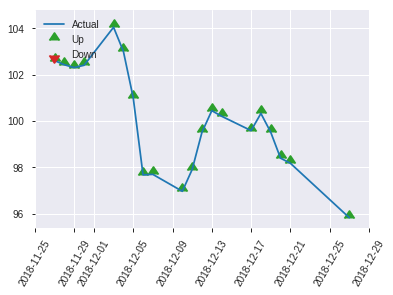


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3744832828873824
RMSE: 0.6119503925052933
LogLoss: 8.176442836244219
Mean Per-Class Error: 0.4722367049009384
AUC: 0.5202033368091762
pr_auc: 0.26521800692968206
Gini: 0.04040667361835237
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3543699970586602: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    111  0.9911   (111.0/112.0)
1      0    137  0        (0.0/137.0)
Total  1    248  0.4458   (111.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.35437      0.711688   32
max f2                       0.35437      0.860553   32
max f0point5                 0.707676     0.608538   25
max accuracy                 0.746143     0.558233   21
max precision                0.982344     0.574468   12
max recall                   0.35437      1          32
max specificity              1            0.508929   0
max absolute_mcc             0.35437      0.0702304  32
max min_per_class_accuracy   1            0.508929   0
max mean_per_class_accuracy  0.982344     0.527763   12

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 88.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.473896                    1                  1.00118   1.00118            0.550847         1         0.550847                    1                   0.474453        0.474453                   0.117531   0.117531
    2        0.502008                    1                  1.29823   1.01781            0.714286         1         0.56                        1                   0.0364964       0.510949                   29.8227    1.78102
    3        0.947791                    0.747715           0.998816  1.00888            0.54955          0.79282   0.555085                    0.902555            0.445255        0.956204                   -0.118367  0.887665
    4        1                           0.204217           0.838855  1                  0.461538         0.615176  0.550201                    0.887551            0.0437956       1                          -16.1145   0

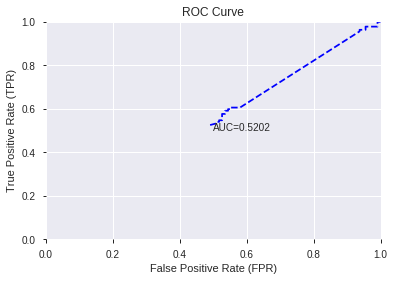

This function is available for GLM models only


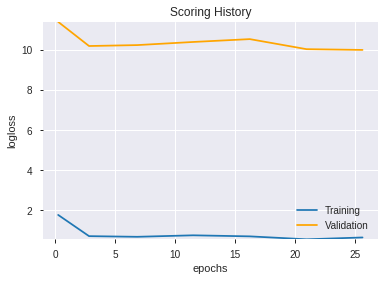

--2019-08-28 15:58:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.48
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.48|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_153438_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_153438_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['weekday_name',
 'CDLRICKSHAWMAN',
 'COS',
 'CORREL_8',
 'SIN',
 'CDLSHORTLINE',
 'BETA_14',
 'BETA_8',
 'dayofweek',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLSPINNINGTOP',
 'BOP',
 'CDLHIKKAKE',
 'BETA_24',
 'CDLHAMMER',
 'SUB',
 'HT_PHASOR_quadrature',
 'ADX_24',
 'CORREL_12',
 'CDLCLOSINGMARUBOZU',
 'ADOSC',
 'weekday',
 'CDLADVANCEBLOCK',
 'STOCHRSI_fastk',
 'CCI_8',
 'STOCHRSI_fastd',
 'ADXR_14',
 'CDLDARKCLOUDCOVER',
 'month',
 'CORREL_14',
 'aroonup_12',
 'Volume',
 'CDLLONGLINE',
 'day',
 'DX_8',
 'aroondown_12',
 'BETA_30',
 'PLUS_DM_8',
 'DX_14',
 'CORREL_24',
 'STOCHF_fastd',
 'is_quarter_end',
 'ADXR_12',
 'MACDEXT_hist',
 'DIV',
 'CORREL_30',
 'is_month_end',
 'AD',
 'TRANGE',
 'STOCH_slowd',
 'ADX_20',
 'BETA_12',
 'CCI_12',
 'days_in_month',
 'HT_TRENDMODE',
 'dayofyear',
 'aroondown_30',
 'CDLBELTHOLD',
 'aroonup_24',
 'BBANDS_lowerband_8_6_4',
 'CDLMARUBOZU',
 'is_month_start',
 'ULTOSC',
 'week',
 'BBANDS_middleband_14_1_4',
 'CDLHIGHWAVE',
 'STOCH_slowk',
 'aroonup_14

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_155836_model_1  0.488725  9.856274                   0.5  0.661545  0.437642

variable  relative_importance  scaled_importance  percentage
0              is_month_start             0.005756           1.000000    0.008961
1                         SIN             0.005731           0.995630    0.008922
2                  aroonup_30             0.005643           0.980443    0.008786
3          CDLCLOSINGMARUBOZU             0.005159           0.896367    0.008032
4                 CDLPIERCING             0.004653           0.808365    0.007244
...                       ...                  ...                ...         ...
1035                MAVP_24_6             0.000006           0.001048    0.000009
1036                MAVP_14_6             0.000005           0.000909    0.000008
1037                     High             0.000003           0.000509    0.000005
1038  BBANDS_upperband_30_1_3             0.000002           0.000376    0.000003
1039                     CEIL             0.000001           0.000219    0.000002

[1040 rows x 4 columns]

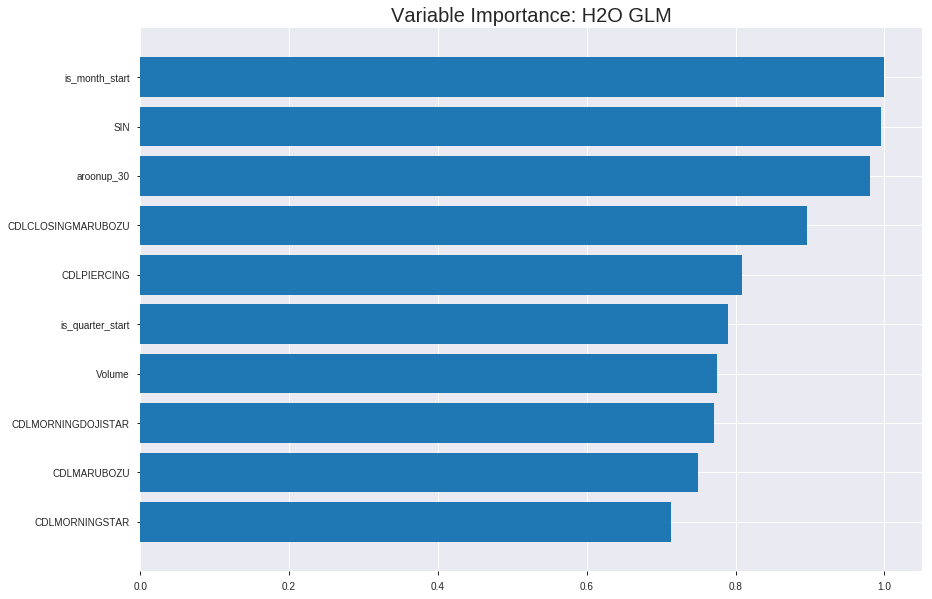

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_155836_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24637256882497915
RMSE: 0.4963593142321187
LogLoss: 0.6858611130121873
Null degrees of freedom: 1740
Residual degrees of freedom: 700
Null deviance: 2412.159208107115
Residual deviance: 2388.168395508436
AIC: 4470.168395508435
AUC: 0.5739913097454997
pr_auc: 0.5712132681722863
Gini: 0.14798261949099945
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4500326272092743: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      27   819   0.9681   (819.0/846.0)
1      7    888   0.0078   (7.0/895.0)
Total  34   1707  0.4744   (826.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450033     0.682552  375
max f2                       0.442715     0.841817  385
max f0point5                 0.496998     0.581653  254
max accuracy                 0.49998      0.562321  245
max precision                0.630116     1         0
max recall                   0.419792     1         397
max specificity              0.630116     1         0
max absolute_mcc             0.499766     0.121493  246
max min_per_class_accuracy   0.512575     0.548603  207
max mean_per_class_accuracy  0.49998      0.558997  245

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 51.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.601341           1.18876   1.18876            0.611111         0.60742   0.611111                    0.60742             0.0122905       0.0122905                  18.8765   18.8765
    2        0.0201034                   0.589986           1.02984   1.11157            0.529412         0.5967    0.571429                    0.602213            0.0100559       0.0223464                  2.9839    11.1572
    3        0.0304423                   0.583446           1.4049    1.21119            0.722222         0.586835  0.622642                    0.59699             0.0145251       0.0368715                  40.4904   21.1194
    4        0.0402068                   0.579842           1.14427   1.19494            0.588235         0.581692  0.614286                    0.593275            0.0111732       0.0480447                  14.4266   19.494
    5        0.0505457                   0.575983           1.4049    1.23789            0.722222         0.578222  0.636364                    0.590196            0.0145251       0.0625698                  40.4904   23.7887
    6        0.100517                    0.5623             1.07324   1.15604            0.551724         0.569457  0.594286                    0.579886            0.0536313       0.116201                   7.32421   15.6035
    7        0.150488                    0.552094           1.25212   1.18794            0.643678         0.556377  0.610687                    0.572079            0.0625698       0.178771                   25.2116   18.794
    8        0.20046                     0.545366           1.14032   1.17607            0.586207         0.54866   0.604585                    0.566241            0.0569832       0.235754                   14.032    17.6069
    9        0.300402                    0.533386           1.11796   1.15674            0.574713         0.539481  0.594646                    0.557338            0.111732        0.347486                   11.7961   15.6736
    10       0.400345                    0.522651           1.06206   1.1331             0.545977         0.527883  0.582496                    0.549985            0.106145        0.453631                   6.20625   13.3102
    11       0.500287                    0.512574           0.950266  1.09658            0.488506         0.517703  0.56372                     0.543536            0.0949721       0.548603                   -4.97335  9.65768
    12       0.60023                     0.50174            1.02852   1.08525            0.528736         0.507308  0.557895                    0.537504            0.102793        0.651397                   2.85237   8.52455
    13       0.700172                    0.492213           0.883189  1.0564             0.454023         0.496873  0.543068                    0.531704            0.0882682       0.739665                   -11.6811  5.6404
    14       0.800115                    0.481872           0.927907  1.04035            0.477011         0.487097  0.534817                    0.526132            0.0927374       0.832402                   -7.20927  4.03534
    15       0.900057                    0.468199           0.927907  1.02787            0.477011         0.475954  0.528398                    0.520561            0.0927374       0.92514                    -7.20927  2.78674
    16       1                           0.368908           0.749034  1                  0.385057         0.455641  0.514072                    0.514072            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38538084011961943
RMSE: 0.6207904961576163
LogLoss: 9.363174997612457
Null degrees of freedom: 497
Residual degrees of freedom: -543
Null deviance: 690.3187923549906
Residual deviance: 169277.61536286192
AIC: 171359.61536286192
AUC: 0.5441800435589255
pr_auc: 0.5764310650709894
Gini: 0.08836008711785093
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.23409166528372e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    245  1        (245.0/245.0)
1      0    253  0        (0.0/253.0)
Total  0    498  0.492    (245.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.23409e-48  0.673768  242
max f2                       1.23409e-48  0.837748  242
max f0point5                 1.23409e-48  0.563474  242
max accuracy                 0.47016      0.544177  109
max precision                0.545356     1         0
max recall                   1.23409e-48  1         242
max specificity              0.545356     1         0
max absolute_mcc             0.486735     0.133982  67
max min_per_class_accuracy   3.08684e-22  0.509881  237
max mean_per_class_accuracy  0.47016      0.548673  109

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 19.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.521423           1.96838   1.96838            1                0.531424     1                           0.531424            0.0197628       0.0197628                  96.8379   96.8379
    2        0.0200803                   0.517459           1.5747    1.77154            0.8              0.519787     0.9                         0.525605            0.0158103       0.0355731                  57.4704   77.1542
    3        0.0301205                   0.508544           1.18103   1.5747             0.6              0.512085     0.8                         0.521098            0.0118577       0.0474308                  18.1028   57.4704
    4        0.0401606                   0.507074           0.787352  1.37787            0.4              0.508186     0.7                         0.51787             0.00790514      0.055336                   -21.2648  37.7866
    5        0.0502008                   0.502856           1.5747    1.41723            0.8              0.505066     0.72                        0.515309            0.0158103       0.0711462                  57.4704   41.7233
    6        0.100402                    0.493032           1.18103   1.29913            0.6              0.496495     0.66                        0.505902            0.0592885       0.130435                   18.1028   29.913
    7        0.150602                    0.484534           1.18103   1.25976            0.6              0.488369     0.64                        0.500058            0.0592885       0.189723                   18.1028   25.9763
    8        0.200803                    0.474761           1.10229   1.2204             0.56             0.47904      0.62                        0.494803            0.055336        0.245059                   10.2292   22.0395
    9        0.301205                    0.455819           0.866087  1.10229            0.44             0.464803     0.56                        0.484803            0.0869565       0.332016                   -13.3913  10.2292
    10       0.399598                    0.253983           1.04445   1.08805            0.530612         0.391984     0.552764                    0.461948            0.102767        0.434783                   4.44462   8.80489
    11       0.5                         4.74624e-76        0.866087  1.04348            0.44             0.061638     0.53012                     0.381565            0.0869565       0.521739                   -13.3913  4.34783
    12       1                           0                  0.956522  1                  0.485944         2.79064e-90  0.508032                    0.190782            0.478261        1                          -4.34783  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 15:58:39  0.000 sec   2            4.3       1041          1.37172           339.915
    2019-08-28 15:58:42  2.269 sec   4            3.1       1041          1.36941           342.627
    2019-08-28 15:58:44  4.563 sec   6            2.3       1041          1.36666           345.857
    2019-08-28 15:58:46  6.831 sec   8            1.6       1041          1.36347           348.691
    2019-08-28 15:58:49  9.092 sec   10           1.2       1041          1.35981           350.728

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5502008032128514)

('F1', 0.7098445595854922)

('auc', 0.4887252346193952)

('logloss', 9.856273904894909)

('mean_per_class_error', 0.48419577685088633)

('rmse', 0.6615448414630845)

('mse', 0.4376415772664176)

glm prediction progress: |████████████████████████████████████████████████| 100%


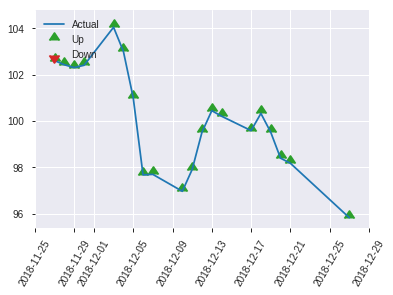


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.4376415772664176
RMSE: 0.6615448414630845
LogLoss: 9.856273904894909
Null degrees of freedom: 248
Residual degrees of freedom: -792
Null deviance: 343.9770046454541
Residual deviance: 65719.00309191078
AIC: 67801.00309191078
AUC: 0.4887252346193952
pr_auc: 0.5429167787157182
Gini: -0.02254953076120958
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.9242596555573696e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    137  0        (0.0/137.0)
Total  0    249  0.4498   (112.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.92426e-48  0.709845   154
max f2                       2.92426e-48  0.859473   154
max f0point5                 2.92426e-48  0.60459    154
max accuracy                 2.92426e-48  0.550201   154
max precision                0.517143     0.75       7
max recall                   2.92426e-48  1          154
max specificity              0.538131     0.991071   0
max absolute_mcc             0.536509     0.0995217  1
max min_per_class_accuracy   6.87235e-07  0.489051   123
max mean_per_class_accuracy  0.515206     0.515804   10

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 19.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.524647           0.605839  0.605839           0.333333         0.534338      0.333333                    0.534338            0.00729927      0.00729927                 -39.4161  -39.4161
    2        0.0200803                   0.519174           1.81752   1.09051            1                0.520152      0.6                         0.528664            0.0145985       0.0218978                  81.7518   9.05109
    3        0.0321285                   0.517089           1.81752   1.36314            1                0.517819      0.75                        0.524597            0.0218978       0.0437956                  81.7518   36.3139
    4        0.0401606                   0.515215           0.908759  1.27226            0.5              0.516172      0.7                         0.522912            0.00729927      0.0510949                  -9.12409  27.2263
    5        0.0522088                   0.513749           1.21168   1.25828            0.666667         0.514568      0.692308                    0.520986            0.0145985       0.0656934                  21.1679   25.8282
    6        0.100402                    0.496294           0.30292   0.799708           0.166667         0.503395      0.44                        0.512543            0.0145985       0.080292                   -69.708   -20.0292
    7        0.15261                     0.491547           1.39809   1.00442            0.769231         0.49382       0.552632                    0.506137            0.0729927       0.153285                   39.8091   0.441798
    8        0.200803                    0.483074           0.908759  0.98146            0.5              0.487367      0.54                        0.501633            0.0437956       0.19708                    -9.12409  -1.85401
    9        0.301205                    0.467888           0.872409  0.945109           0.48             0.477652      0.52                        0.493639            0.0875912       0.284672                   -12.7591  -5.48905
    10       0.401606                    0.176865           1.01781   0.963285           0.56             0.388281      0.53                        0.467299            0.10219         0.386861                   1.78102   -3.67153
    11       0.502008                    4.66626e-07        1.01781   0.97419            0.56             0.0243803     0.536                       0.378716            0.10219         0.489051                   1.78102   -2.58102
    12       0.598394                    2.03876e-28        1.06022   0.988047           0.583333         2.50313e-08   0.543624                    0.317714            0.10219         0.591241                   6.0219    -1.19532
    13       0.698795                    2.08847e-158       0.945109  0.981878           0.52             7.74313e-30   0.54023                     0.272066            0.0948905       0.686131                   -5.48905  -1.81223
    14       1                           0                  1.04204   1                  0.573333         7.23601e-173  0.550201                    0.190118            0.313869        1                          4.20438   0

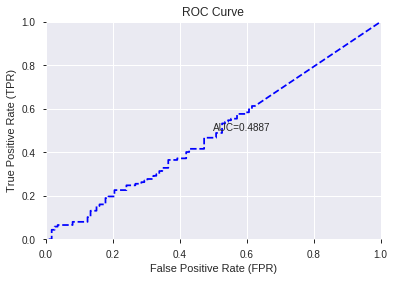

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


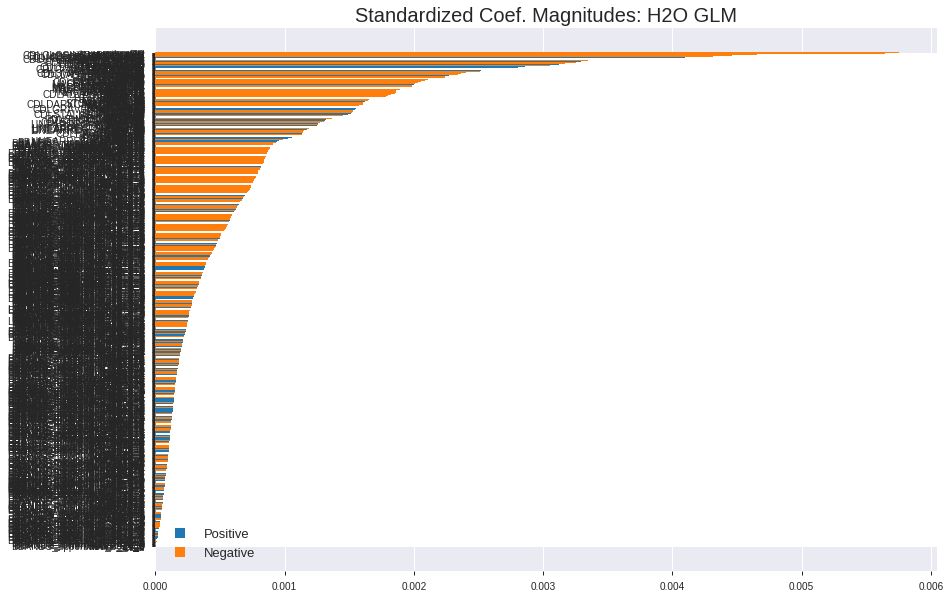

'log_likelihood'
--2019-08-28 15:59:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_155836_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_155836_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['is_month_start',
 'SIN',
 'aroonup_30',
 'CDLCLOSINGMARUBOZU',
 'CDLPIERCING',
 'is_quarter_start',
 'Volume',
 'CDLMORNINGDOJISTAR',
 'CDLMARUBOZU',
 'CDLMORNINGSTAR',
 'CDLSEPARATINGLINES',
 'TAN',
 'CDLTASUKIGAP',
 'CDLUPSIDEGAP2CROWS',
 'PLUS_DM_30',
 'CDLSPINNINGTOP',
 'SUB',
 'BOP',
 'CDLDOJISTAR',
 'CDLHOMINGPIGEON',
 'PLUS_DM_24',
 'CDLENGULFING',
 'CDLHIKKAKEMOD',
 'DIV',
 'BETA_30',
 'day',
 'aroonup_24',
 'PLUS_DM_20',
 'CDLLONGLINE',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLHARAMI',
 'PLUS_DM_14',
 'CCI_12',
 'CDLCOUNTERATTACK',
 'TRANGE',
 'AROONOSC_30',
 'CDLINNECK',
 'CDLSHORTLINE',
 'CCI_14',
 'PLUS_DM_12',
 'CDL3WHITESOLDIERS',
 'aroonup_14',
 'OBV',
 'CDLLADDERBOTTOM',
 'aroonup_8',
 'PLUS_DI_30',
 'CDLHIGHWAVE',
 'STOCHF_fastd',
 'STOCH_slowk',
 'ADOSC',
 'SINH',
 'COSH',
 'EXP',
 'PLUS_DM_8',
 'PLUS_DI_24',
 'CORREL_24',
 'VAR_30',
 'ATR_8',
 'days_in_month',
 'CDL3OUTSIDE',
 'CDLEVENINGSTAR',
 'CDLTHRUSTING',
 'PLUS_DI_20',
 'MACDFIX_signal_20',
 'ATR_30',
 'weekd

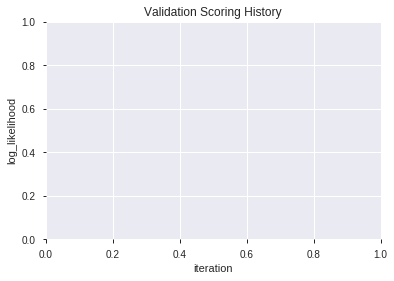

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_155920_model_4  0.540798  0.708169              0.500000  0.507280  0.257333
1  XGBoost_grid_1_AutoML_20190828_155920_model_2  0.538386  0.704063              0.485792  0.505325  0.255353
2  XGBoost_grid_1_AutoML_20190828_155920_model_6  0.534672  0.717625              0.500000  0.511352  0.261481
3  XGBoost_grid_1_AutoML_20190828_155920_model_1  0.534509  0.729127              0.495536  0.516385  0.266653
4  XGBoost_grid_1_AutoML_20190828_155920_model_3  0.520529  0.720357              0.500000  0.512673  0.262834
5               XGBoost_1_AutoML_20190828_155920  0.514664  0.731599              0.491071  0.517620  0.267930
6               XGBoost_2_AutoML_20190828_155920  0.509776  0.723071              0.481328  0.514280  0.264484
7  XGBoost_grid_1_AutoML_20190828_155920_model_5  0.502737  0.750725              0.495536  0.525835  0.276503
8               XGBoost_3_AutoML_20190828_155920  0.494851  0.722980              0.500000  0.513329  0.263506
9  XGBoost_grid_1_AutoML_20190828_155920_model_7  0.488269  0.760812              0.486607  0.530720  0.281664

variable  relative_importance  scaled_importance  percentage
0                        TAN           104.906929           1.000000    0.029838
1                        SIN           104.417671           0.995336    0.029699
2                    BETA_12            87.895676           0.837844    0.025000
3       HT_PHASOR_quadrature            71.970062           0.686037    0.020470
4               STOCHF_fastk            70.552391           0.672524    0.020067
..                       ...                  ...                ...         ...
173                    DX_30             6.015530           0.057342    0.001711
174   BBANDS_lowerband_8_3_5             5.553355           0.052936    0.001580
175  BBANDS_lowerband_30_2_3             5.396399           0.051440    0.001535
176              MINUS_DI_30             4.796150           0.045718    0.001364
177               MINUS_DI_8             4.734477           0.045130    0.001347

[178 rows x 4 columns]

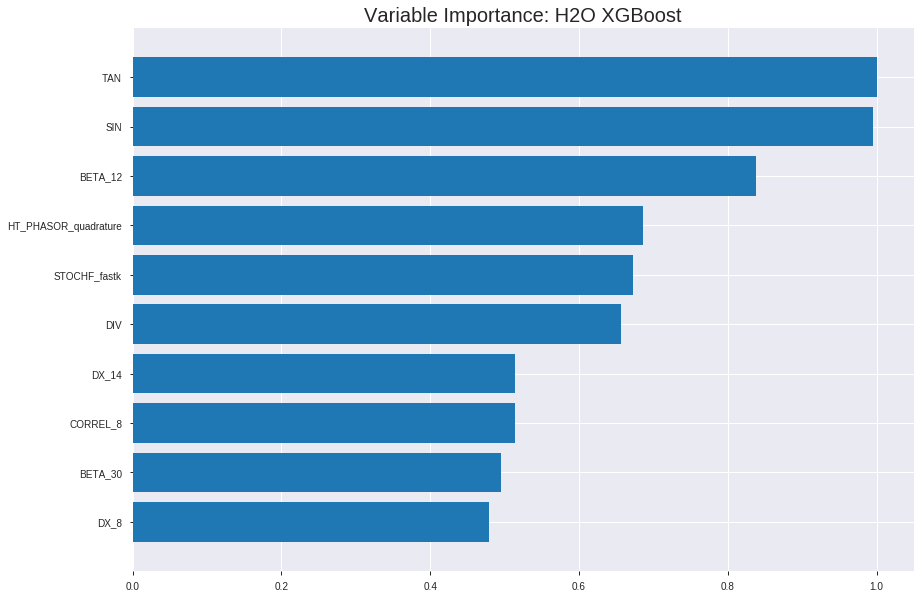

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_155920_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2106712128283329
RMSE: 0.4589893384691336
LogLoss: 0.6130958373650378
Mean Per-Class Error: 0.24935021197353302
AUC: 0.8326029821572434
pr_auc: 0.8385663645533614
Gini: 0.6652059643144868
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47853539139032364: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      499  347   0.4102   (347.0/846.0)
1      117  778   0.1307   (117.0/895.0)
Total  616  1125  0.2665   (464.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478535     0.770297  246
max f2                       0.434328     0.862898  302
max f0point5                 0.529532     0.774446  176
max accuracy                 0.509921     0.750718  204
max precision                0.72571      1         0
max recall                   0.372652     1         369
max specificity              0.72571      1         0
max absolute_mcc             0.529532     0.502954  176
max min_per_class_accuracy   0.510602     0.749409  203
max mean_per_class_accuracy  0.509921     0.75065   204

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 51.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.677578           1.94525   1.94525            1                0.695583  1                           0.695583            0.0201117       0.0201117                  94.5251   94.5251
    2        0.0201034                   0.663346           1.94525   1.94525            1                0.669023  1                           0.682683            0.0189944       0.0391061                  94.5251   94.5251
    3        0.0304423                   0.655264           1.94525   1.94525            1                0.659174  1                           0.674698            0.0201117       0.0592179                  94.5251   94.5251
    4        0.0402068                   0.648456           1.83082   1.91746            0.941176         0.652227  0.985714                    0.669241            0.0178771       0.077095                   83.0825   91.7462
    5        0.0505457                   0.642424           1.83718   1.90104            0.944444         0.645247  0.977273                    0.664333            0.0189944       0.0960894                  83.7182   90.1041
    6        0.100517                    0.618089           1.78874   1.84521            0.91954          0.629144  0.948571                    0.646839            0.0893855       0.185475                   78.8737   84.521
    7        0.150488                    0.601494           1.67694   1.78933            0.862069         0.6082    0.919847                    0.634009            0.0837989       0.269274                   67.6941   78.9334
    8        0.20046                     0.585195           1.74402   1.77804            0.896552         0.592753  0.91404                     0.623724            0.0871508       0.356425                   74.4018   77.8038
    9        0.300402                    0.554609           1.49807   1.68489            0.770115         0.569835  0.866157                    0.605796            0.149721        0.506145                   49.8067   68.4893
    10       0.400345                    0.533234           1.29683   1.58802            0.666667         0.543454  0.816356                    0.590233            0.129609        0.635754                   29.6834   58.8017
    11       0.500287                    0.51132            1.06206   1.48295            0.545977         0.523062  0.762342                    0.576814            0.106145        0.741899                   6.20625   48.2947
    12       0.60023                     0.488274           0.905548  1.38681            0.465517         0.499946  0.712919                    0.564015            0.0905028       0.832402                   -9.44519  38.6806
    13       0.700172                    0.464921           0.704315  1.28939            0.362069         0.476882  0.662838                    0.551577            0.0703911       0.902793                   -29.5685  28.9387
    14       0.800115                    0.437657           0.55898   1.19815            0.287356         0.452102  0.615937                    0.539152            0.0558659       0.958659                   -44.102   19.8152
    15       0.900057                    0.40147            0.301849  1.09863            0.155172         0.420171  0.564773                    0.52594             0.0301676       0.988827                   -69.8151  9.86263
    16       1                           0.300908           0.111796  1                  0.0574713        0.377505  0.514072                    0.511105          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2527695219296486
RMSE: 0.502761893871889
LogLoss: 0.698957019696793
Mean Per-Class Error: 0.45259336936355565
AUC: 0.5264580140356538
pr_auc: 0.5566964686195185
Gini: 0.052916028071307686
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33768200874328613: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   235  0.9592   (235.0/245.0)
1      3    250  0.0119   (3.0/253.0)
Total  13   485  0.4779   (238.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337682     0.677507  386
max f2                       0.310274     0.837748  399
max f0point5                 0.337682     0.569995  386
max accuracy                 0.518587     0.542169  80
max precision                0.605339     0.8       9
max recall                   0.310274     1         399
max specificity              0.649549     0.995918  0
max absolute_mcc             0.56263      0.129144  34
max min_per_class_accuracy   0.448676     0.514286  201
max mean_per_class_accuracy  0.518587     0.547407  80

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 45.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.613625           1.18103   1.18103            0.6              0.634859  0.6                         0.634859            0.0118577       0.0118577                  18.1028   18.1028
    2        0.0200803                   0.602052           1.96838   1.5747             1                0.609977  0.8                         0.622418            0.0197628       0.0316206                  96.8379   57.4704
    3        0.0301205                   0.593618           1.18103   1.44348            0.6              0.599642  0.733333                    0.614826            0.0118577       0.0434783                  18.1028   44.3478
    4        0.0401606                   0.579378           1.5747    1.47628            0.8              0.585168  0.75                        0.607411            0.0158103       0.0592885                  57.4704   47.6285
    5        0.0502008                   0.573469           1.5747    1.49597            0.8              0.576441  0.76                        0.601217            0.0158103       0.0750988                  57.4704   49.5968
    6        0.100402                    0.550335           1.02356   1.25976            0.52             0.562038  0.64                        0.581628            0.0513834       0.126482                   2.35573   25.9763
    7        0.150602                    0.526647           1.3385    1.28601            0.68             0.537851  0.653333                    0.567036            0.0671937       0.193676                   33.8498   28.6008
    8        0.200803                    0.508689           0.866087  1.18103            0.44             0.517762  0.6                         0.554717            0.0434783       0.237154                   -13.3913  18.1028
    9        0.301205                    0.486238           1.06292   1.14166            0.54             0.497418  0.58                        0.535617            0.106719        0.343874                   6.29249   14.166
    10       0.399598                    0.467611           0.80342   1.05837            0.408163         0.476987  0.537688                    0.521181            0.0790514       0.422925                   -19.658   5.83749
    11       0.5                         0.448854           0.905455  1.02767            0.46             0.458979  0.522088                    0.508691            0.0909091       0.513834                   -9.45455  2.7668
    12       0.600402                    0.433108           0.866087  1.00065            0.44             0.440869  0.508361                    0.497349            0.0869565       0.600791                   -13.3913  0.0647745
    13       0.698795                    0.41422            0.964104  0.995502           0.489796         0.423023  0.505747                    0.486884            0.0948617       0.695652                   -3.58958  -0.449775
    14       0.799197                    0.398452           0.98419   0.994081           0.5              0.405826  0.505025                    0.476701            0.0988142       0.794466                   -1.58103  -0.591892
    15       0.899598                    0.36897            1.14166   1.01055            0.58             0.385079  0.513393                    0.466475            0.114625        0.909091                   14.166    1.05519
    16       1                           0.310274           0.905455  1                  0.46             0.348744  0.508032                    0.454655     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 15:59:52  14.326 sec  0                  0.5              0.693147            0.5             0                  1                0.485928                         0.5                0.693147              0.5               0                    1                  0.491968
    2019-08-28 15:59:53  15.586 sec  5                  0.493779         0.680767            0.696924        0.694922           1.47839          0.411832                         0.499694           0.692535              0.528208          0.531252             1.18103            0.491968
    2019-08-28 15:59:54  15.989 sec  10                 0.489225         0.671767            0.719706        0.733861           1.72911          0.380816                         0.499546           0.692236              0.529717          0.542272             1.18103            0.481928
    2019-08-28 15:59:54  16.378 sec  15                 0.484498         0.66247             0.742269        0.753495           1.83718          0.363584                         0.499514           0.692172              0.537299          0.544884             1.5747             0.477912
    2019-08-28 15:59:55  16.798 sec  20                 0.480393         0.654447            0.763479        0.770297           1.94525          0.323952                         0.500342           0.693853              0.523812          0.540901             1.5747             0.485944
    2019-08-28 15:59:55  17.224 sec  25                 0.476522         0.646885            0.774517        0.785004           1.94525          0.314187                         0.500206           0.693598              0.527708          0.545738             0.787352           0.487952
    2019-08-28 15:59:56  17.629 sec  30                 0.472972         0.639993            0.787803        0.799213           1.94525          0.3027                           0.50105            0.695326              0.524345          0.544428             1.18103            0.48996
    2019-08-28 15:59:56  18.041 sec  35                 0.469246         0.63277             0.798224        0.810873           1.94525          0.302125                         0.501738           0.696761              0.522941          0.547006             1.5747             0.48996
    2019-08-28 15:59:56  18.441 sec  40                 0.465321         0.625235            0.816388        0.82713            1.94525          0.256175                         0.50112            0.695507              0.531669          0.55595              1.5747             0.471888
    2019-08-28 15:59:57  18.846 sec  45                 0.462312         0.61945             0.823902        0.832255           1.94525          0.258472                         0.501719           0.696802              0.531951          0.559383             1.18103            0.47992
    2019-08-28 15:59:57  19.261 sec  50                 0.458989         0.613096            0.832603        0.838566           1.94525          0.266513                         0.502762           0.698957              0.526458          0.556696             1.18103            0.477912

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
TAN                      104.90692901611328     1.0                   0.029838363907548578
SIN                      104.41767120361328     0.9953362678987119    0.029699205771943026
BETA_12                  87.89567565917969      0.8378443300506802    0.024999904017928433
HT_PHASOR_quadrature     71.97006225585938      0.6860372611308169    0.020470229451759244
STOCHF_fastk             70.5523910522461       0.6725236522881108    0.020067005473406316
---                      ---                    ---                   ---
DX_30                    6.015529632568359      0.05734158543182975   0.0017109790931507222
BBANDS_lowerband_8_3_5   5.5533552169799805     0.052936019279784724  0.0015795242070872242
BBANDS_lowerband_30_2_3  5.396398544311523      0.05143986765147475   0.0015348814903408399
MINUS_DI_30              4.796149730682373      0.045718140600090426  0.0013641545164019694
MINUS_DI_8               4.734476566314697      0.04513025603473247   0.0013466130028051877


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5742971887550201)

('F1', 0.7098445595854922)

('auc', 0.5407977059436914)

('logloss', 0.7081685481058)

('mean_per_class_error', 0.451055787278415)

('rmse', 0.507280376539527)

('mse', 0.25733338042208426)

xgboost prediction progress: |████████████████████████████████████████████| 100%


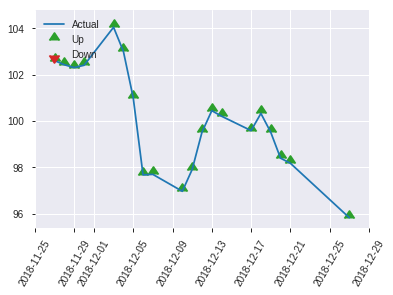


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25733338042208426
RMSE: 0.507280376539527
LogLoss: 0.7081685481058
Mean Per-Class Error: 0.451055787278415
AUC: 0.5407977059436914
pr_auc: 0.5836103647786676
Gini: 0.08159541188738273
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30598345398902893: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    137  0        (0.0/137.0)
Total  0    249  0.4498   (112.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.305983     0.709845  248
max f2                       0.305983     0.859473  248
max f0point5                 0.403846     0.616062  192
max accuracy                 0.404379     0.574297  190
max precision                0.606761     1         0
max recall                   0.305983     1         248
max specificity              0.606761     1         0
max absolute_mcc             0.404379     0.112904  190
max min_per_class_accuracy   0.445391     0.5       124
max mean_per_class_accuracy  0.464307     0.548944  88

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 44.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.564602           1.21168   1.21168            0.666667         0.580907  0.666667                    0.580907            0.0145985       0.0145985                  21.1679   21.1679
    2        0.0200803                   0.553356           0.908759  1.09051            0.5              0.560206  0.6                         0.572626            0.00729927      0.0218978                  -9.12409  9.05109
    3        0.0321285                   0.542568           1.81752   1.36314            1                0.548579  0.75                        0.563609            0.0218978       0.0437956                  81.7518   36.3139
    4        0.0401606                   0.538442           0.908759  1.27226            0.5              0.539949  0.7                         0.558877            0.00729927      0.0510949                  -9.12409  27.2263
    5        0.0522088                   0.535193           1.21168   1.25828            0.666667         0.536683  0.692308                    0.553755            0.0145985       0.0656934                  21.1679   25.8282
    6        0.100402                    0.522011           0.908759  1.09051            0.5              0.530243  0.6                         0.542469            0.0437956       0.109489                   -9.12409  9.05109
    7        0.15261                     0.502749           0.978664  1.05225            0.538462         0.509911  0.578947                    0.531331            0.0510949       0.160584                   -2.13363  5.22474
    8        0.200803                    0.487777           1.21168   1.09051            0.666667         0.495164  0.6                         0.522651            0.0583942       0.218978                   21.1679   9.05109
    9        0.301205                    0.473447           1.01781   1.06628            0.56             0.479376  0.586667                    0.508226            0.10219         0.321168                   1.78102   6.62774
    10       0.401606                    0.459253           1.01781   1.05416            0.56             0.465325  0.58                        0.497501            0.10219         0.423358                   1.78102   5.41606
    11       0.502008                    0.445391           0.799708  1.00327            0.44             0.45088   0.552                       0.488177            0.080292        0.50365                    -20.0292  0.327007
    12       0.598394                    0.430597           1.28741   1.04904            0.708333         0.438203  0.577181                    0.480127            0.124088        0.627737                   28.7409   4.90374
    13       0.698795                    0.417934           1.09051   1.055              0.6              0.424554  0.58046                     0.472142            0.109489        0.737226                   9.05109   5.49962
    14       0.799197                    0.400067           0.872409  1.03206            0.48             0.407085  0.567839                    0.463969            0.0875912       0.824818                   -12.7591  3.20581
    15       0.899598                    0.380651           0.872409  1.01424            0.48             0.390743  0.558036                    0.455797            0.0875912       0.912409                   -12.7591  1.42401
    16       1                           0.305983           0.872409  1                  0.48             0.355698  0.550201                    0.445747        

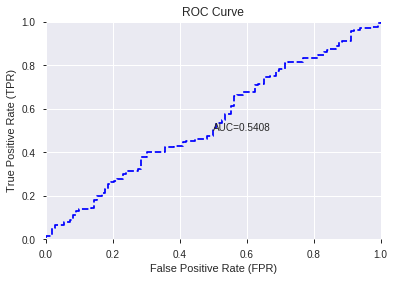

This function is available for GLM models only


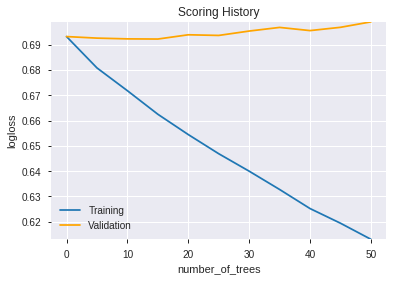

--2019-08-28 16:00:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_155920_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_155920_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['TAN',
 'SIN',
 'BETA_12',
 'HT_PHASOR_quadrature',
 'STOCHF_fastk',
 'DIV',
 'DX_14',
 'CORREL_8',
 'BETA_30',
 'DX_8',
 'STOCH_slowd',
 'TRIX_14',
 'CCI_8',
 'aroonup_30',
 'BETA_14',
 'STDDEV_8',
 'BOP',
 'DX_24',
 'MINUS_DM_8',
 'ADX_8',
 'PLUS_DM_30',
 'dayofyear',
 'MFI_30',
 'STOCH_slowk',
 'aroondown_30',
 'ADXR_12',
 'day',
 'STDDEV_14',
 'DX_12',
 'LINEARREG_INTERCEPT_20',
 'KAMA_24',
 'Volume',
 'MACDFIX_signal_12',
 'MFI_14',
 'ADXR_8',
 'MOM_24',
 'MFI_8',
 'ULTOSC',
 'COS',
 'ADX_24',
 'MACDFIX_signal_24',
 'TRANGE',
 'BETA_8',
 'STDDEV_20',
 'MINUS_DI_20',
 'MINUS_DM_12',
 'STDDEV_12',
 'dayofweek',
 'BETA_24',
 'BETA_20',
 'ATR_8',
 'MFI_12',
 'aroonup_8',
 'MACDFIX_signal_14',
 'MACDEXT_hist',
 'WILLR_14',
 'aroonup_14',
 'LINEARREG_ANGLE_8',
 'CORREL_14',
 'OBV',
 'AROONOSC_20',
 'NATR_24',
 'MACDFIX_signal_20',
 'MOM_14',
 'ADX_14',
 'PLUS_DI_14',
 'HT_PHASOR_inphase',
 'PLUS_DM_14',
 'PLUS_DI_20',
 'MINUS_DI_12',
 'STDDEV_24',
 'aroondown_20',
 'CMO_24',
 'PLUS_DM_

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

235

['DEMA_14',
 'EMA_14',
 'KAMA_14',
 'MIDPOINT_14',
 'MIDPRICE_14',
 'SAR_0.14',
 'SMA_14',
 'TEMA_14',
 'TRIMA_14',
 'WMA_14',
 'MAVP_14_0',
 'BBANDS_upperband_14_0_2',
 'BBANDS_lowerband_14_0_2',
 'BBANDS_middleband_14_0_3',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_upperband_14_0_4',
 'BBANDS_middleband_14_0_4',
 'BBANDS_lowerband_14_0_4',
 'BBANDS_upperband_14_0_5',
 'BBANDS_middleband_14_0_5',
 'BBANDS_lowerband_14_0_5',
 'MAVP_14_1',
 'BBANDS_upperband_14_1_2',
 'BBANDS_middleband_14_1_2',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_upperband_14_1_3',
 'BBANDS_middleband_14_1_3',
 'BBANDS_lowerband_14_1_4',
 'BBANDS_upperband_14_1_5',
 'BBANDS_lowerband_14_1_5',
 'MA_14_2',
 'MAVP_14_2',
 'BBANDS_middleband_14_2_2',
 'BBANDS_lowerband_14_2_2',
 'BBANDS_upperband_14_2_3',
 'BBANDS_upperband_14_2_4',
 'BBANDS_middleband_14_2_4',
 'BBANDS_upperband_14_3_2',
 'BBANDS_upperband_14_3_4',
 'BBANDS_lowerband_14_3_5',
 'BBANDS_lowerband_14_4_3',
 'BBANDS_middleband_14_4_4',
 'BBANDS_lowerband_14_4_4',

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190828_160140  0.539429  0.703406              0.494721  0.504449  0.254469
1  DeepLearning_grid_1_AutoML_20190828_160140_model_5  0.521572  0.688806              0.500000  0.497834  0.247838
2  DeepLearning_grid_1_AutoML_20190828_160140_model_7  0.516391  0.755185              0.485792  0.522772  0.273290
3  DeepLearning_grid_1_AutoML_20190828_160140_model_1  0.514468  3.374949              0.495536  0.674892  0.455479
4  DeepLearning_grid_1_AutoML_20190828_160140_model_3  0.511144  1.514183              0.495536  0.640191  0.409845
5  DeepLearning_grid_1_AutoML_20190828_160140_model_8  0.505931  0.692804              0.495536  0.499828  0.249828
6  DeepLearning_grid_1_AutoML_20190828_160140_model_9  0.504855  0.693203              0.495536  0.500028  0.250028
7  DeepLearning_grid_1_AutoML_20190828_160140_model_4  0.493483  1.428442              0.500000  0.630339  0.397328
8  DeepLearning_grid_1_AutoML_20190828_160140_model_6  0.485890  0.698636              0.491071  0.502722  0.252730
9  DeepLearning_grid_1_AutoML_20190828_160140_model_2  0.481426  2.241526              0.500000  0.674055  0.454350

variable  relative_importance  scaled_importance  percentage
0                   STDDEV_8             1.000000           1.000000    0.006405
1                     ATR_14             0.996719           0.996719    0.006384
2                 PLUS_DM_20             0.960161           0.960161    0.006150
3                     SMA_14             0.944354           0.944354    0.006049
4    BBANDS_upperband_14_5_3             0.940769           0.940769    0.006026
..                       ...                  ...                ...         ...
230                   ROC_12             0.427040           0.427040    0.002735
231  BBANDS_lowerband_14_0_2             0.408771           0.408771    0.002618
232                      PPO             0.402861           0.402861    0.002581
233  BBANDS_upperband_14_0_5             0.389002           0.389002    0.002492
234              HT_DCPERIOD             0.367659           0.367659    0.002355

[235 rows x 4 columns]

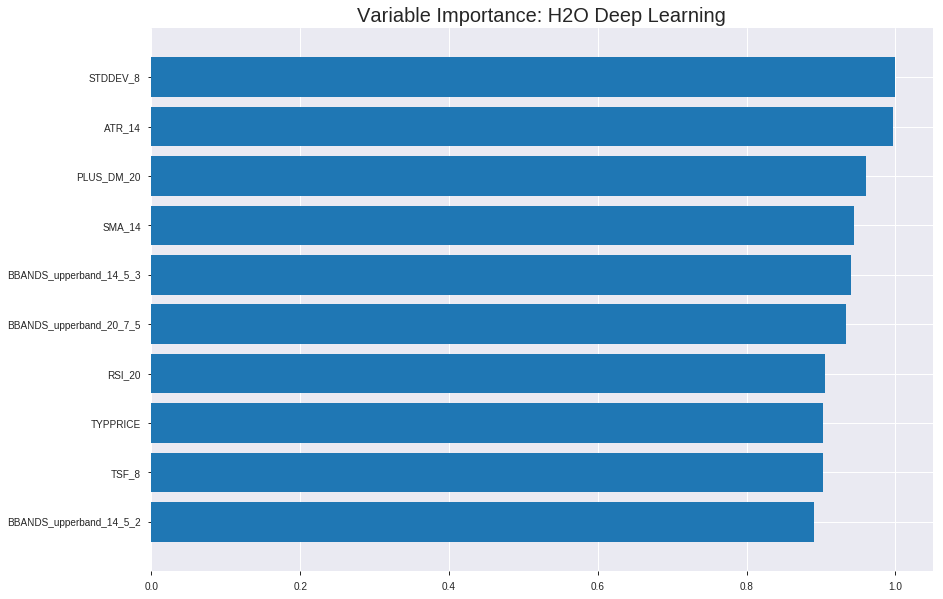

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190828_160140


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2402307688853703
RMSE: 0.49013341947409617
LogLoss: 0.6731279466284693
Mean Per-Class Error: 0.40838913321975245
AUC: 0.6169664672398537
pr_auc: 0.6317723212718988
Gini: 0.23393293447970742
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24368176096569044: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      35   811   0.9586   (811.0/846.0)
1      12   883   0.0134   (12.0/895.0)
Total  47   1694  0.4727   (823.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.243682     0.682117  373
max f2                       0.18821      0.841808  391
max f0point5                 0.460236     0.603113  233
max accuracy                 0.460236     0.589891  233
max precision                0.965893     1         0
max recall                   0.162386     1         396
max specificity              0.965893     1         0
max absolute_mcc             0.524386     0.18864   177
max min_per_class_accuracy   0.481618     0.580378  213
max mean_per_class_accuracy  0.524386     0.591611  177

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 49.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.850291           1.72911   1.72911            0.888889         0.896563  0.888889                    0.896563            0.0178771       0.0178771                  72.9112   72.9112
    2        0.0201034                   0.802436           1.7164    1.72294            0.882353         0.822276  0.885714                    0.860481            0.0167598       0.0346369                  71.6398   72.2937
    3        0.0304423                   0.771695           1.29683   1.57822            0.666667         0.786463  0.811321                    0.835343            0.0134078       0.0480447                  29.6834   57.8223
    4        0.0402068                   0.748747           1.48755   1.5562             0.764706         0.758325  0.8                         0.816638            0.0145251       0.0625698                  48.7545   55.6201
    5        0.0505457                   0.734836           1.51297   1.54736            0.777778         0.740542  0.795455                    0.801073            0.0156425       0.0782123                  51.2973   54.7359
    6        0.100517                    0.676708           1.2074    1.37835            0.62069          0.704855  0.708571                    0.753239            0.0603352       0.138547                   20.7397   37.835
    7        0.150488                    0.632672           1.36391   1.37356            0.701149         0.653271  0.706107                    0.720043            0.0681564       0.206704                   36.3912   37.3555
    8        0.20046                     0.606107           1.05088   1.29312            0.54023          0.61871   0.664756                    0.694783            0.052514        0.259218                   5.08829   29.3118
    9        0.300402                    0.554744           1.17386   1.25344            0.603448         0.57842   0.644359                    0.656069            0.117318        0.376536                   17.3859   25.3441
    10       0.400345                    0.517751           1.07324   1.20846            0.551724         0.535642  0.621234                    0.626006            0.107263        0.483799                   7.32421   20.8456
    11       0.500287                    0.481736           0.939087  1.15464            0.482759         0.501346  0.593571                    0.601102            0.0938547       0.577654                   -6.09131  15.4644
    12       0.60023                     0.450512           1.01734   1.13178            0.522989         0.466923  0.581818                    0.57876             0.101676        0.67933                    1.73441   13.1783
    13       0.700172                    0.415341           0.816111  1.08672            0.41954          0.431739  0.558655                    0.557775            0.0815642       0.760894                   -18.3889  8.67237
    14       0.800115                    0.375647           0.883189  1.0613             0.454023         0.395949  0.545585                    0.537561            0.0882682       0.849162                   -11.6811  6.13001
    15       0.900057                    0.329749           0.771393  1.02911            0.396552         0.353999  0.529036                    0.517178            0.077095        0.926257                   -22.8607  2.91087
    16       1                           0.135913           0.737854  1                  0.37931          0.269121  0.514072                    0.492387          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2642779183880092
RMSE: 0.5140796809717432
LogLoss: 0.7238951382610042
Mean Per-Class Error: 0.4738001129305477
AUC: 0.5058481890780028
pr_auc: 0.5150997873168432
Gini: 0.011696378156005549
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21456452601026205: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    244  0.9959   (244.0/245.0)
1      0    253  0        (0.0/253.0)
Total  1    497  0.49     (244.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.214565     0.674667   398
max f2                       0.214565     0.838304   398
max f0point5                 0.214565     0.56448    398
max accuracy                 0.59767      0.524096   133
max precision                0.684924     0.615385   12
max recall                   0.214565     1          398
max specificity              0.764352     0.995918   0
max absolute_mcc             0.717358     0.0791107  2
max min_per_class_accuracy   0.565727     0.497959   182
max mean_per_class_accuracy  0.59767      0.5262     133

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 53.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.695432           0.393676  0.393676           0.2              0.726001  0.2                         0.726001            0.00395257      0.00395257                 -60.6324  -60.6324
    2        0.0200803                   0.687382           1.5747    0.98419            0.8              0.692718  0.5                         0.709359            0.0158103       0.0197628                  57.4704   -1.58103
    3        0.0301205                   0.680884           1.5747    1.18103            0.8              0.68414   0.6                         0.700953            0.0158103       0.0355731                  57.4704   18.1028
    4        0.0401606                   0.675934           0.393676  0.98419            0.2              0.678582  0.5                         0.69536             0.00395257      0.0395257                  -60.6324  -1.58103
    5        0.0502008                   0.669816           0.787352  0.944822           0.4              0.672907  0.48                        0.69087             0.00790514      0.0474308                  -21.2648  -5.51779
    6        0.100402                    0.655638           1.25976   1.10229            0.64             0.661821  0.56                        0.676345            0.0632411       0.110672                   25.9763   10.2292
    7        0.150602                    0.645886           1.10229   1.10229            0.56             0.651084  0.56                        0.667925            0.055336        0.166008                   10.2292   10.2292
    8        0.200803                    0.637992           0.944822  1.06292            0.48             0.641834  0.54                        0.661402            0.0474308       0.213439                   -5.51779  6.29249
    9        0.301205                    0.618291           1.06292   1.06292            0.54             0.63045   0.54                        0.651085            0.106719        0.320158                   6.29249   6.29249
    10       0.399598                    0.590675           0.883762  1.01881            0.44898          0.604482  0.517588                    0.63961             0.0869565       0.407115                   -11.6238  1.88095
    11       0.5                         0.565045           0.905455  0.996047           0.46             0.578704  0.506024                    0.62738             0.0909091       0.498024                   -9.45455  -0.395257
    12       0.600402                    0.519338           0.98419   0.994065           0.5              0.542611  0.505017                    0.613204            0.0988142       0.596838                   -1.58103  -0.593546
    13       0.698795                    0.478176           1.08462   1.00681            0.55102          0.497231  0.511494                    0.596875            0.106719        0.703557                   8.46172   0.681477
    14       0.799197                    0.423398           0.905455  0.994081           0.46             0.450701  0.505025                    0.578511            0.0909091       0.794466                   -9.45455  -0.591892
    15       0.899598                    0.360888           0.944822  0.988583           0.48             0.392398  0.502232                    0.55774             0.0948617       0.889328                   -5.51779  -1.14166
    16       1                           0.185525           1.10229   1                  0.56             0.3085    0.508032                    0.532


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:01:41  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 16:01:41  0.111 sec   34137 obs/sec     1         1             1741       0.590316         1.08301             -0.394996      0.547926        0.553505           1.0807           0.483056                         0.625499           1.40531               -0.565398        0.514794          0.538035             1.96838            0.491968
    2019-08-28 16:01:41  0.628 sec   32664 obs/sec     10        10            17410      0.490133         0.673128            0.0383151      0.616966        0.631772           1.72911          0.472717                         0.51408            0.723895              -0.0573845       0.505848          0.5151               0.393676           0.48996

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
STDDEV_8                 1.0                    1.0                  0.0064054553933154896
ATR_14                   0.9967189431190491     0.9967189431190491   0.006384438729821628
PLUS_DM_20               0.9601613283157349     0.9601613283157349   0.006150270558912988
SMA_14                   0.9443541169166565     0.9443541169166565   0.006049018171403483
BBANDS_upperband_14_5_3  0.9407687783241272     0.9407687783241272   0.006026052444979104
---                      ---                    ---                  ---
ROC_12                   0.4270397424697876     0.4270397424697876   0.002735384021563159
BBANDS_lowerband_14_0_2  0.40877148509025574    0.40877148509025574  0.0026183675138049607
PPO                      0.40286117792129517    0.40286117792129517  0.0025805093048733912
BBANDS_upperband_14_0_5  0.38900160789489746    0.38900160789489746  0.0024917324472987683
HT_DCPERIOD              0.3676586151123047     0.3676586151123047   0.002355020859070016


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5783132530120482)

('F1', 0.710182767624021)

('auc', 0.5394290928050053)

('logloss', 0.7034058345340531)

('mean_per_class_error', 0.4279197080291971)

('rmse', 0.5044492573788063)

('mse', 0.25446905327002917)

deeplearning prediction progress: |███████████████████████████████████████| 100%


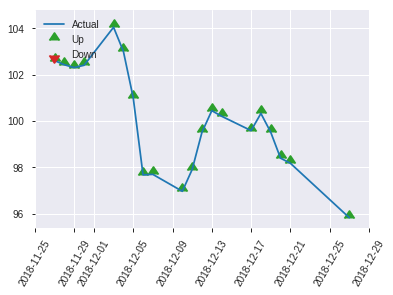


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25446905327002917
RMSE: 0.5044492573788063
LogLoss: 0.7034058345340531
Mean Per-Class Error: 0.4279197080291971
AUC: 0.5394290928050053
pr_auc: 0.5800190635469228
Gini: 0.07885818561001057
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24340164165392705: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    110  0.9821   (110.0/112.0)
1      1    136  0.0073   (1.0/137.0)
Total  3    246  0.4458   (111.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.243402     0.710183  245
max f2                       0.168155     0.859473  248
max f0point5                 0.385737     0.619335  213
max accuracy                 0.389152     0.578313  211
max precision                0.727283     1         0
max recall                   0.168155     1         248
max specificity              0.727283     1         0
max absolute_mcc             0.616251     0.152599  81
max min_per_class_accuracy   0.557113     0.49635   122
max mean_per_class_accuracy  0.616251     0.57208   81

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 52.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.710465           1.21168   1.21168            0.666667         0.721529  0.666667                    0.721529            0.0145985       0.0145985                  21.1679   21.1679
    2        0.0200803                   0.701785           0.908759  1.09051            0.5              0.704428  0.6                         0.714689            0.00729927      0.0218978                  -9.12409  9.05109
    3        0.0321285                   0.693554           1.21168   1.13595            0.666667         0.699142  0.625                       0.708859            0.0145985       0.0364964                  21.1679   13.5949
    4        0.0401606                   0.683835           0.908759  1.09051            0.5              0.691822  0.6                         0.705451            0.00729927      0.0437956                  -9.12409  9.05109
    5        0.0522088                   0.679196           0.605839  0.978664           0.333333         0.68256   0.538462                    0.700169            0.00729927      0.0510949                  -39.4161  -2.13363
    6        0.100402                    0.6657             1.06022   1.01781            0.583333         0.671037  0.56                        0.686185            0.0510949       0.10219                    6.0219    1.78102
    7        0.15261                     0.655474           1.25828   1.10008            0.692308         0.660129  0.605263                    0.677271            0.0656934       0.167883                   25.8282   10.0077
    8        0.200803                    0.647067           1.36314   1.16321            0.75             0.651199  0.64                        0.671014            0.0656934       0.233577                   36.3139   16.3212
    9        0.301205                    0.626968           1.16321   1.16321            0.64             0.636717  0.64                        0.659582            0.116788        0.350365                   16.3212   16.3212
    10       0.401606                    0.579553           0.727007  1.05416            0.4              0.60372   0.58                        0.645616            0.0729927       0.423358                   -27.2993  5.41606
    11       0.502008                    0.551915           0.727007  0.98873            0.4              0.563134  0.544                       0.62912             0.0729927       0.49635                    -27.2993  -1.12701
    12       0.598394                    0.502734           1.13595   1.01244            0.625            0.529423  0.557047                    0.613061            0.109489        0.605839                   13.5949   1.24431
    13       0.698795                    0.452778           1.23591   1.04455            0.68             0.478204  0.574713                    0.593685            0.124088        0.729927                   23.5912   4.45507
    14       0.799197                    0.412722           0.799708  1.01379            0.44             0.43098   0.557789                    0.573245            0.080292        0.810219                   -20.0292  1.37916
    15       0.899598                    0.334291           1.01781   1.01424            0.56             0.384905  0.558036                    0.552225            0.10219         0.912409                   1.78102   1.42401
    16       1                           0.168155           0.872409  1                  0.48             0.302054  0.550201                    0.527107       

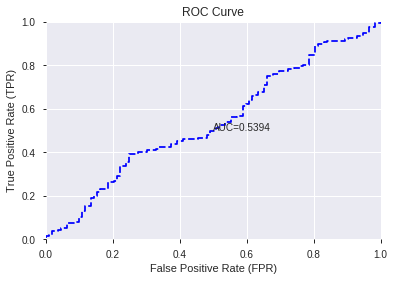

This function is available for GLM models only


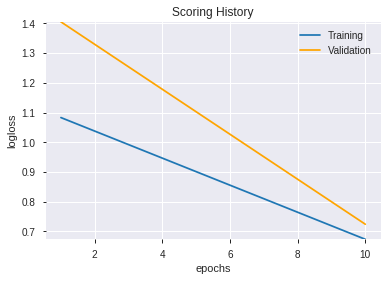

--2019-08-28 16:13:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190828_160140',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190828_160140',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_98_sid_9e85'

['STDDEV_8',
 'ATR_14',
 'PLUS_DM_20',
 'SMA_14',
 'BBANDS_upperband_14_5_3',
 'BBANDS_upperband_20_7_5',
 'RSI_20',
 'TYPPRICE',
 'TSF_8',
 'BBANDS_upperband_14_5_2',
 'ROCP_20',
 'MINUS_DM_8',
 'BBANDS_middleband_20_0_2',
 'MOM_8',
 'BBANDS_middleband_20_0_4',
 'BBANDS_middleband_14_2_4',
 'STOCHRSI_fastk',
 'BETA_12',
 'BBANDS_lowerband_14_6_3',
 'BBANDS_lowerband_20_2_5',
 'ROCR_24',
 'BBANDS_lowerband_14_0_5',
 'BBANDS_middleband_20_3_4',
 'AROONOSC_20',
 'DX_20',
 'BBANDS_lowerband_24_1_3',
 'CDLLONGLEGGEDDOJI',
 'LINEARREG_8',
 'WILLR_12',
 'STOCH_slowd',
 'BBANDS_lowerband_24_0_4',
 'aroonup_30',
 'BBANDS_upperband_20_0_5',
 'CORREL_12',
 'PLUS_DI_24',
 'ROCR_12',
 'CDLSHORTLINE',
 'MACD',
 'DX_14',
 'BBANDS_middleband_20_5_5',
 'DX_24',
 'BBANDS_upperband_20_2_4',
 'BBANDS_lowerband_20_5_5',
 'STOCHF_fastk',
 'NATR_8',
 'MACDEXT',
 'BBANDS_middleband_14_4_5',
 'BBANDS_lowerband_20_0_4',
 'MINUS_DI_12',
 'BBANDS_upperband_14_6_5',
 'BBANDS_lowerband_20_3_4',
 'ROCP_12',
 'AROON

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_161308_model_1  0.519095  0.701024              0.481328  0.503904  0.253919

variable  relative_importance  scaled_importance  percentage
0                 aroonup_30             0.006448           1.000000    0.022167
1         CDLCLOSINGMARUBOZU             0.005299           0.821767    0.018216
2                 PLUS_DM_30             0.004635           0.718806    0.015934
3                CDLMARUBOZU             0.004540           0.704118    0.015608
4                 PLUS_DM_20             0.004068           0.630873    0.013984
..                       ...                  ...                ...         ...
230  BBANDS_upperband_20_6_4             0.000063           0.009699    0.000215
231       LINEARREG_ANGLE_12             0.000048           0.007398    0.000164
232  BBANDS_upperband_20_1_4             0.000045           0.006956    0.000154
233                   ADX_24             0.000008           0.001247    0.000028
234  BBANDS_upperband_20_2_5             0.000007           0.001030    0.000023

[235 rows x 4 columns]

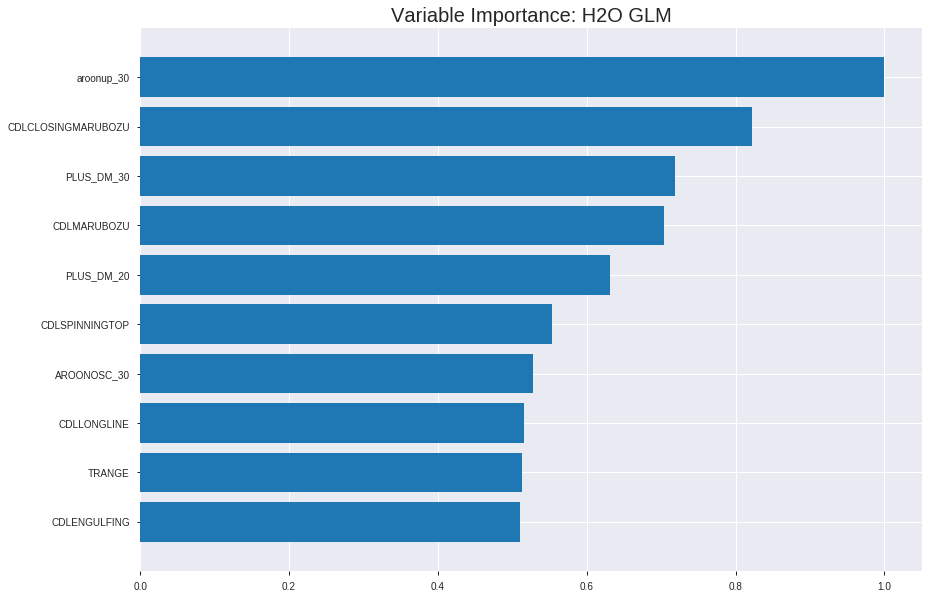

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_161308_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2477573821097315
RMSE: 0.4977523300897059
LogLoss: 0.6886538981954253
Null degrees of freedom: 1740
Residual degrees of freedom: 1505
Null deviance: 2412.159208107115
Residual deviance: 2397.892873516471
AIC: 2869.892873516471
AUC: 0.5581230106845226
pr_auc: 0.5562381339293253
Gini: 0.11624602136904527
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4584585065247646: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      15   831   0.9823   (831.0/846.0)
1      2    893   0.0022   (2.0/895.0)
Total  17   1724  0.4785   (833.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.458459     0.68194    387
max f2                       0.458459     0.841817   387
max f0point5                 0.479654     0.576619   334
max accuracy                 0.505119     0.54911    240
max precision                0.551286     0.613757   77
max recall                   0.447286     1          397
max specificity              0.608241     0.998818   0
max absolute_mcc             0.516786     0.0972037  194
max min_per_class_accuracy   0.512432     0.540782   211
max mean_per_class_accuracy  0.516786     0.548346   194

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 51.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.584682           0.972626  0.972626           0.5              0.592088  0.5                         0.592088            0.0100559       0.0100559                  -2.73743  -2.73743
    2        0.0201034                   0.577019           1.14427   1.05599            0.588235         0.580435  0.542857                    0.586428            0.0111732       0.0212291                  14.4266   5.59936
    3        0.0304423                   0.570181           1.29683   1.13779            0.666667         0.573245  0.584906                    0.581951            0.0134078       0.0346369                  29.6834   13.7789
    4        0.0402068                   0.566906           0.686559  1.0282             0.352941         0.568264  0.528571                    0.578627            0.00670391      0.0413408                  -31.3441  2.82043
    5        0.0505457                   0.565107           1.51297   1.12736            0.777778         0.565957  0.579545                    0.576035            0.0156425       0.0569832                  51.2973   12.7362
    6        0.100517                    0.552593           1.18504   1.15604            0.609195         0.558208  0.594286                    0.567173            0.0592179       0.116201                   18.5038   15.6035
    7        0.150488                    0.545206           1.18504   1.16567            0.609195         0.548431  0.599237                    0.560949            0.0592179       0.175419                   18.5038   16.5666
    8        0.20046                     0.539169           1.0956    1.1482             0.563218         0.542004  0.590258                    0.556226            0.0547486       0.230168                   9.56014   14.82
    9        0.300402                    0.529827           1.11796   1.13814            0.574713         0.534581  0.585086                    0.549025            0.111732        0.341899                   11.7961   13.8139
    10       0.400345                    0.521414           1.00616   1.10519            0.517241         0.525673  0.568149                    0.543196            0.100559        0.442458                   0.616452  10.5193
    11       0.500287                    0.512419           0.983805  1.08094            0.505747         0.516658  0.555683                    0.537894            0.098324        0.540782                   -1.61947  8.09434
    12       0.60023                     0.504594           1.01734   1.07035            0.522989         0.5088    0.550239                    0.53305             0.101676        0.642458                   1.73441   7.03536
    13       0.700172                    0.496506           0.872009  1.04204            0.448276         0.500133  0.535685                    0.528351            0.0871508       0.729609                   -12.7991  4.2042
    14       0.800115                    0.487811           0.961446  1.03197            0.494253         0.492013  0.53051                     0.523812            0.0960894       0.825698                   -3.85539  3.19747
    15       0.900057                    0.476702           0.905548  1.01794            0.465517         0.482306  0.523293                    0.519203            0.0905028       0.916201                   -9.44519  1.79363
    16       1                           0.440989           0.83847   1                  0.431034         0.467864  0.514072                    0.514072           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24988894481402668
RMSE: 0.49988893247803223
LogLoss: 0.6929162621431728
Null degrees of freedom: 497
Residual degrees of freedom: 262
Null deviance: 690.3187923549906
Residual deviance: 690.1445970946002
AIC: 1162.1445970946002
AUC: 0.5592159393401629
pr_auc: 0.5754908009879761
Gini: 0.11843187868032579
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4175294319839066: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      22   223  0.9102   (223.0/245.0)
1      5    248  0.0198   (5.0/253.0)
Total  27   471  0.4578   (228.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417529     0.685083  374
max f2                       0.403675     0.839973  395
max f0point5                 0.427545     0.584053  339
max accuracy                 0.471276     0.558233  163
max precision                0.53741      1         0
max recall                   0.403675     1         395
max specificity              0.53741      1         0
max absolute_mcc             0.417529     0.154616  374
max min_per_class_accuracy   0.46533      0.521739  189
max mean_per_class_accuracy  0.471276     0.55941   163

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 46.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.519279           1.96838   1.96838            1                0.528519  1                           0.528519            0.0197628       0.0197628                  96.8379   96.8379
    2        0.0200803                   0.512235           1.18103   1.5747             0.6              0.515091  0.8                         0.521805            0.0118577       0.0316206                  18.1028   57.4704
    3        0.0301205                   0.509554           1.18103   1.44348            0.6              0.510608  0.733333                    0.518073            0.0118577       0.0434783                  18.1028   44.3478
    4        0.0401606                   0.50444            1.5747    1.47628            0.8              0.50804   0.75                        0.515565            0.0158103       0.0592885                  57.4704   47.6285
    5        0.0502008                   0.50256            0.787352  1.3385             0.4              0.503488  0.68                        0.513149            0.00790514      0.0671937                  -21.2648  33.8498
    6        0.100402                    0.496649           1.41723   1.37787            0.72             0.499239  0.7                         0.506194            0.0711462       0.13834                    41.7233   37.7866
    7        0.150602                    0.491408           0.787352  1.18103            0.4              0.494321  0.6                         0.502236            0.0395257       0.177866                   -21.2648  18.1028
    8        0.200803                    0.48732            1.10229   1.16134            0.56             0.489587  0.59                        0.499074            0.055336        0.233202                   10.2292   16.1344
    9        0.301205                    0.479714           0.98419   1.10229            0.5              0.482746  0.56                        0.493631            0.0988142       0.332016                   -1.58103  10.2292
    10       0.399598                    0.473601           1.2453    1.13751            0.632653         0.476415  0.577889                    0.489392            0.12253         0.454545                   24.5301   13.7506
    11       0.5                         0.465278           0.669249  1.04348            0.34             0.4694    0.53012                     0.485377            0.0671937       0.521739                   -33.0751  4.34783
    12       0.600402                    0.451049           0.905455  1.0204             0.46             0.458105  0.518395                    0.480817            0.0909091       0.612648                   -9.45455  2.03974
    13       0.698795                    0.440527           0.883762  1.00116            0.44898          0.445537  0.508621                    0.475849            0.0869565       0.699605                   -11.6238  0.115851
    14       0.799197                    0.432282           1.41723   1.05343            0.72             0.436474  0.535176                    0.470903            0.142292        0.841897                   41.7233   5.34292
    15       0.899598                    0.424632           0.944822  1.04131            0.48             0.428511  0.529018                    0.466171            0.0948617       0.936759                   -5.51779  4.13079
    16       1                           0.395797           0.629881  1                  0.32             0.415468  0.508032                    0.461081        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 16:13:09  0.000 sec   2            4.3       236           1.37731           1.38583
    2019-08-28 16:13:09  0.141 sec   4            3.1       236           1.37624           1.3869
    2019-08-28 16:13:09  0.287 sec   6            2.3       236           1.37505           1.38759
    2019-08-28 16:13:09  0.432 sec   8            1.6       236           1.37371           1.38841
    2019-08-28 16:13:10  0.590 sec   10           1.2       236           1.37222           1.38931
    2019-08-28 16:13:10  0.731 sec   12           0.87      236           1.37056           1.39015

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5662650602409639)

('F1', 0.7157894736842105)

('auc', 0.5190954118873827)

('logloss', 0.7010235408147378)

('mean_per_class_error', 0.4620046923879041)

('rmse', 0.503903793264601)

('mse', 0.25391903286645373)

glm prediction progress: |████████████████████████████████████████████████| 100%


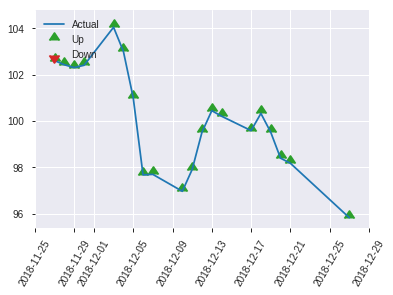


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25391903286645373
RMSE: 0.503903793264601
LogLoss: 0.7010235408147378
Null degrees of freedom: 248
Residual degrees of freedom: 13
Null deviance: 343.9770046454541
Residual deviance: 349.10972332573937
AIC: 821.1097233257394
AUC: 0.5190954118873827
pr_auc: 0.5709540190639332
Gini: 0.03819082377476546
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4202361908287799: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    107  0.9554   (107.0/112.0)
1      1    136  0.0073   (1.0/137.0)
Total  6    243  0.4337   (108.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.420236     0.715789  242
max f2                       0.41701      0.861635  246
max f0point5                 0.420236     0.613165  242
max accuracy                 0.433485     0.566265  210
max precision                0.512789     0.8       9
max recall                   0.41701      1         246
max specificity              0.522633     0.991071  0
max absolute_mcc             0.420236     0.121145  242
max min_per_class_accuracy   0.480955     0.508929  124
max mean_per_class_accuracy  0.489843     0.537995  85

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 47.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.517597           0.605839  0.605839           0.333333         0.521455  0.333333                    0.521455            0.00729927      0.00729927                 -39.4161  -39.4161
    2        0.0200803                   0.514812           1.81752   1.09051            1                0.515019  0.6                         0.518881            0.0145985       0.0218978                  81.7518   9.05109
    3        0.0321285                   0.51378            1.81752   1.36314            1                0.514355  0.75                        0.517183            0.0218978       0.0437956                  81.7518   36.3139
    4        0.0401606                   0.511526           1.81752   1.45401            1                0.513201  0.8                         0.516387            0.0145985       0.0583942                  81.7518   45.4015
    5        0.0522088                   0.509083           0         1.11847            0                0.510623  0.615385                    0.515057            0               0.0583942                  -100      11.8473
    6        0.100402                    0.502993           1.36314   1.23591            0.75             0.505458  0.68                        0.510449            0.0656934       0.124088                   36.3139   23.5912
    7        0.15261                     0.498348           0.838855  1.10008            0.461538         0.500765  0.605263                    0.507136            0.0437956       0.167883                   -16.1145  10.0077
    8        0.200803                    0.496535           0.757299  1.01781            0.416667         0.497483  0.56                        0.50482             0.0364964       0.20438                    -24.2701  1.78102
    9        0.301205                    0.490986           1.16321   1.06628            0.64             0.493778  0.586667                    0.501139            0.116788        0.321168                   16.3212   6.62774
    10       0.401606                    0.486438           0.945109  1.03599            0.52             0.489301  0.57                        0.498179            0.0948905       0.416058                   -5.48905  3.59854
    11       0.502008                    0.480955           0.945109  1.01781            0.52             0.484458  0.56                        0.495435            0.0948905       0.510949                   -5.48905  1.78102
    12       0.598394                    0.46598            0.681569  0.963651           0.375            0.476283  0.530201                    0.49235             0.0656934       0.576642                   -31.8431  -3.63494
    13       0.698795                    0.452478           1.30861   1.01321            0.72             0.459019  0.557471                    0.487561            0.131387        0.708029                   30.8613   1.32142
    14       0.799197                    0.439715           1.09051   1.02292            0.6              0.447472  0.562814                    0.482525            0.109489        0.817518                   9.05109   2.29248
    15       0.899598                    0.427712           1.01781   1.02235            0.56             0.432693  0.5625                      0.476963            0.10219         0.919708                   1.78102   2.2354
    16       1                           0.411994           0.799708  1                  0.44             0.421944  0.550201                    0.471439        

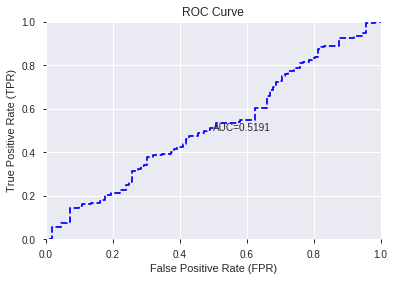

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


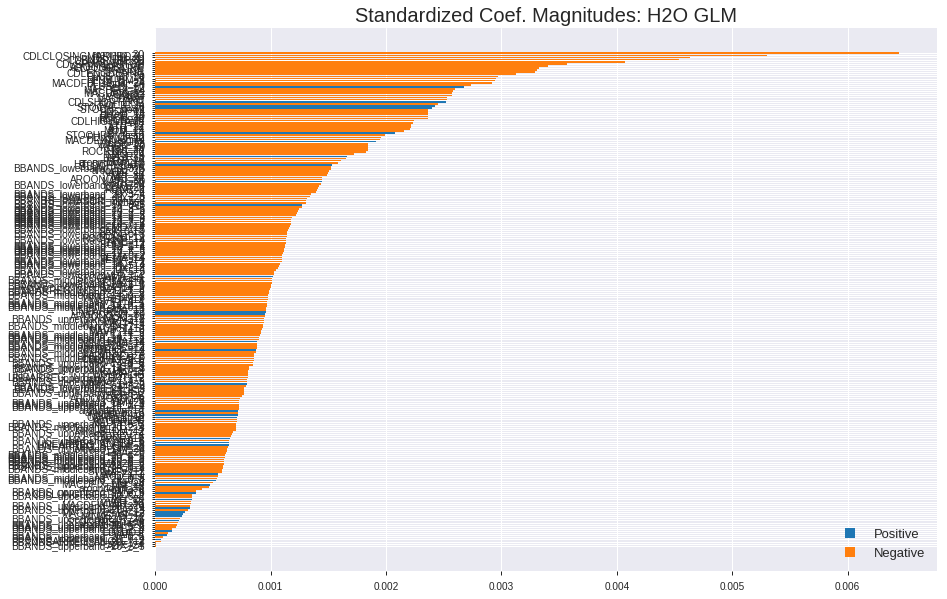

'log_likelihood'
--2019-08-28 16:13:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.228
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.228|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_161308_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_161308_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['aroonup_30',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DM_30',
 'CDLMARUBOZU',
 'PLUS_DM_20',
 'CDLSPINNINGTOP',
 'AROONOSC_30',
 'CDLLONGLINE',
 'TRANGE',
 'CDLENGULFING',
 'PLUS_DI_30',
 'aroonup_14',
 'PLUS_DM_8',
 'PLUS_DI_24',
 'MACDFIX_signal_24',
 'PLUS_DI_20',
 'CCI_12',
 'MACDFIX_24',
 'MACDFIX_12',
 'ADOSC',
 'MACD',
 'MACDEXT',
 'APO',
 'CDLSHORTLINE',
 'ROCR_24',
 'STOCHF_fastd',
 'STOCH_slowk',
 'ROCP_14',
 'MOM_14',
 'ROCP_30',
 'ROCR_30',
 'ROCR_14',
 'CDLHIGHWAVE',
 'PPO',
 'ATR_12',
 'ATR_24',
 'MOM_24',
 'ATR_14',
 'STOCHRSI_fastd',
 'PLUS_DI_12',
 'CMO_30',
 'MACDEXT_signal',
 'WILLR_12',
 'ROC_20',
 'ROCP_20',
 'MFI_24',
 'ROCR100_20',
 'CMO_24',
 'NATR_8',
 'BETA_12',
 'RSI_20',
 'aroondown_12',
 'HT_DCPERIOD',
 'STOCH_slowd',
 'BBANDS_lowerband_20_3_5',
 'aroonup_20',
 'NATR_12',
 'MFI_30',
 'MFI_14',
 'AROONOSC_24',
 'NATR_30',
 'CCI_20',
 'BBANDS_lowerband_20_7_4',
 'MOM_20',
 'ROCR_8',
 'DX_24',
 'BBANDS_lowerband_20_3_4',
 'BBANDS_lowerband_20_2_5',
 'DX_20',
 'BBANDS_l

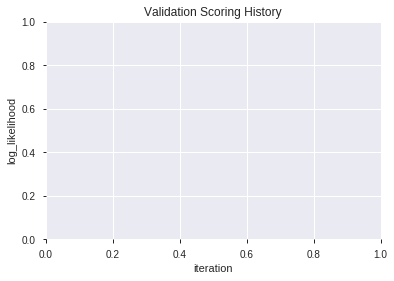

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_161325_model_2  0.552529  0.702525              0.494721  0.504500  0.254520
1               XGBoost_3_AutoML_20190828_161325  0.528154  0.718179              0.500000  0.511351  0.261480
2  XGBoost_grid_1_AutoML_20190828_161325_model_1  0.519943  0.723385              0.500000  0.512393  0.262546
3  XGBoost_grid_1_AutoML_20190828_161325_model_3  0.517401  0.730431              0.495536  0.516404  0.266674
4               XGBoost_2_AutoML_20190828_161325  0.513816  0.711434              0.491071  0.508798  0.258875
5  XGBoost_grid_1_AutoML_20190828_161325_model_5  0.512969  0.757507              0.500000  0.527789  0.278561
6  XGBoost_grid_1_AutoML_20190828_161325_model_7  0.512513  0.736254              0.480514  0.519757  0.270147
7               XGBoost_1_AutoML_20190828_161325  0.512057  0.734658              0.495536  0.519088  0.269453
8  XGBoost_grid_1_AutoML_20190828_161325_model_6  0.493874  0.736030              0.500000  0.518885  0.269241
9  XGBoost_grid_1_AutoML_20190828_161325_model_4  0.483511  0.715581              0.477679  0.510893  0.261012

variable  relative_importance  scaled_importance  percentage
0          MACDFIX_signal_24           128.128708           1.000000    0.023848
1                    BETA_12           126.182442           0.984810    0.023486
2                   STDDEV_8           119.047218           0.929122    0.022158
3                    BETA_14           107.185883           0.836549    0.019950
4                  PLUS_DM_8           107.025536           0.835297    0.019920
..                       ...                  ...                ...         ...
190              MIDPOINT_14             0.450663           0.003517    0.000084
191  BBANDS_upperband_20_2_5             0.423999           0.003309    0.000079
192  BBANDS_upperband_20_6_2             0.322253           0.002515    0.000060
193              MIDPRICE_14             0.199043           0.001553    0.000037
194  BBANDS_upperband_14_5_2             0.141094           0.001101    0.000026

[195 rows x 4 columns]

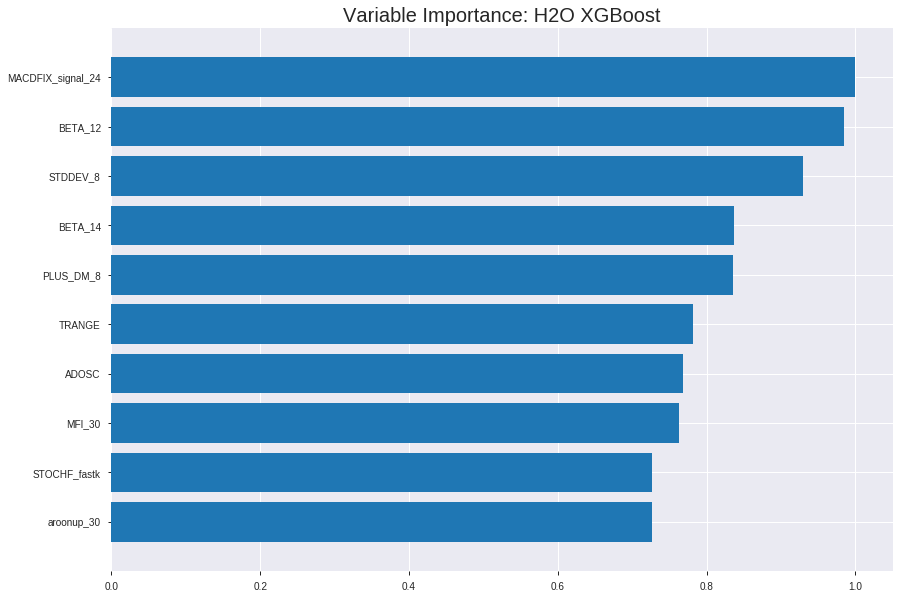

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_161325_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1917749378793558
RMSE: 0.4379211548662108
LogLoss: 0.5742765681971835
Mean Per-Class Error: 0.15783773789241518
AUC: 0.9180243538439188
pr_auc: 0.9267614296163296
Gini: 0.8360487076878376
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5082583427429199: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      711  135  0.1596   (135.0/846.0)
1      140  755  0.1564   (140.0/895.0)
Total  851  890  0.158    (275.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.508258     0.845938  207
max f2                       0.447236     0.892599  278
max f0point5                 0.539771     0.870029  171
max accuracy                 0.510318     0.842045  205
max precision                0.729377     1         0
max recall                   0.358869     1         366
max specificity              0.729377     1         0
max absolute_mcc             0.510318     0.684094  205
max min_per_class_accuracy   0.50927      0.841341  206
max mean_per_class_accuracy  0.510318     0.842162  205

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 51.29 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.694481           1.94525    1.94525            1                0.706421  1                           0.706421            0.0201117       0.0201117                  94.5251   94.5251
    2        0.0201034                   0.687508           1.94525    1.94525            1                0.691373  1                           0.699112            0.0189944       0.0391061                  94.5251   94.5251
    3        0.0304423                   0.673045           1.94525    1.94525            1                0.679655  1                           0.692504            0.0201117       0.0592179                  94.5251   94.5251
    4        0.0402068                   0.667973           1.94525    1.94525            1                0.670481  1                           0.687156            0.0189944       0.0782123                  94.5251   94.5251
    5        0.0505457                   0.660998           1.94525    1.94525            1                0.664638  1                           0.68255             0.0201117       0.098324                   94.5251   94.5251
    6        0.100517                    0.636811           1.94525    1.94525            1                0.648744  1                           0.665743            0.0972067       0.195531                   94.5251   94.5251
    7        0.150488                    0.618219           1.92289    1.93783            0.988506         0.627979  0.996183                    0.653203            0.0960894       0.29162                    92.2892   93.7827
    8        0.20046                     0.603048           1.83346    1.91181            0.942529         0.611334  0.982808                    0.642766            0.0916201       0.38324                    83.3455   91.1809
    9        0.300402                    0.573856           1.74402    1.85599            0.896552         0.588605  0.954111                    0.624747            0.174302        0.557542                   74.4018   85.5986
    10       0.400345                    0.54389            1.55397    1.78059            0.798851         0.558173  0.915352                    0.608127            0.155307        0.712849                   55.3965   78.0589
    11       0.500287                    0.511431           1.18504    1.66162            0.609195         0.52722   0.854191                    0.591964            0.118436        0.831285                   18.5038   66.1615
    12       0.60023                     0.483785           0.737854   1.5078             0.37931          0.496977  0.77512                     0.576148            0.073743        0.905028                   -26.2146  50.7803
    13       0.700172                    0.454806           0.447184   1.35641            0.229885         0.469944  0.697293                    0.560989            0.0446927       0.949721                   -55.2816  35.641
    14       0.800115                    0.421455           0.346568   1.23027            0.178161         0.438895  0.632448                    0.545738            0.0346369       0.984358                   -65.3432  23.027
    15       0.900057                    0.385873           0.134155   1.10856            0.0689655        0.404366  0.569879                    0.53004             0.0134078       0.997765                   -86.5845  10.8557
    16       1                           0.276856           0.0223592  1                  0.0114943        0.358214  0.514072                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2499351067218095
RMSE: 0.4999351025101253
LogLoss: 0.6930358244811162
Mean Per-Class Error: 0.45247237234814874
AUC: 0.551076873437122
pr_auc: 0.5580116372680625
Gini: 0.10215374687424394
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32039570808410645: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    242  0.9878   (242.0/245.0)
1      0    253  0        (0.0/253.0)
Total  3    495  0.4859   (242.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.320396     0.676471  396
max f2                       0.320396     0.839416  396
max f0point5                 0.379719     0.573045  353
max accuracy                 0.449212     0.548193  219
max precision                0.655241     1         0
max recall                   0.320396     1         396
max specificity              0.655241     1         0
max absolute_mcc             0.562583     0.114019  38
max min_per_class_accuracy   0.454493     0.534694  205
max mean_per_class_accuracy  0.449212     0.547528  219

Gains/Lift Table: Avg response rate: 50.80 %, avg score: 46.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.629129           1.5747    1.5747             0.8              0.640067  0.8                         0.640067            0.0158103       0.0158103                  57.4704   57.4704
    2        0.0200803                   0.61602            1.18103   1.37787            0.6              0.624193  0.7                         0.63213             0.0118577       0.027668                   18.1028   37.7866
    3        0.0301205                   0.604499           1.18103   1.31225            0.6              0.612406  0.666667                    0.625555            0.0118577       0.0395257                  18.1028   31.2253
    4        0.0401606                   0.591113           1.96838   1.47628            1                0.599272  0.75                        0.618984            0.0197628       0.0592885                  96.8379   47.6285
    5        0.0502008                   0.586624           0.787352  1.3385             0.4              0.590671  0.68                        0.613322            0.00790514      0.0671937                  -21.2648  33.8498
    6        0.100402                    0.559079           1.18103   1.25976            0.6              0.572598  0.64                        0.59296             0.0592885       0.126482                   18.1028   25.9763
    7        0.150602                    0.540037           0.708617  1.07605            0.36             0.548014  0.546667                    0.577978            0.0355731       0.162055                   -29.1383  7.60474
    8        0.200803                    0.523139           1.25976   1.12198            0.64             0.53183   0.57                        0.566441            0.0632411       0.225296                   25.9763   12.1976
    9        0.301205                    0.499763           1.10229   1.11542            0.56             0.511605  0.566667                    0.548162            0.110672        0.335968                   10.2292   11.5415
    10       0.399598                    0.473819           1.00428   1.08805            0.510204         0.485304  0.552764                    0.532685            0.0988142       0.434783                   0.427523  8.80489
    11       0.5                         0.454637           0.98419   1.06719            0.5              0.46443   0.542169                    0.518979            0.0988142       0.533597                   -1.58103  6.71937
    12       0.600402                    0.438124           1.02356   1.0599             0.52             0.446708  0.538462                    0.506894            0.102767        0.636364                   2.35573   5.98966
    13       0.698795                    0.422376           0.964104  1.04641            0.489796         0.430335  0.531609                    0.496114            0.0948617       0.731225                   -3.58958  4.64086
    14       0.799197                    0.40293            0.866087  1.02376            0.44             0.412446  0.520101                    0.485603            0.0869565       0.818182                   -13.3913  2.37551
    15       0.899598                    0.377455           1.02356   1.02373            0.52             0.39229   0.520089                    0.475188            0.102767        0.920949                   2.35573   2.37331
    16       1                           0.30627            0.787352  1                  0.4              0.356818  0.508032                    0.463304         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 16:13:32  1.158 sec   0                  0.5              0.693147            0.5             0                  1                0.485928                         0.5                0.693147              0.5               0                    1                  0.491968
    2019-08-28 16:13:32  1.459 sec   5                  0.491936         0.677133            0.738743        0.730589           1.63401          0.34463                          0.499413           0.691972              0.531887          0.537382             1.18103            0.491968
    2019-08-28 16:13:33  1.550 sec   10                 0.485254         0.664008            0.782845        0.796031           1.83718          0.306146                         0.49832            0.68979               0.562297          0.57484              1.5747             0.491968
    2019-08-28 16:13:33  1.639 sec   15                 0.47862          0.651087            0.808519        0.82049            1.94525          0.282596                         0.498359           0.689859              0.56116           0.56425              1.5747             0.487952
    2019-08-28 16:13:33  1.735 sec   20                 0.471895         0.638101            0.8328          0.844817           1.94525          0.266513                         0.499215           0.691584              0.549625          0.555717             1.5747             0.47992
    2019-08-28 16:13:33  1.832 sec   25                 0.465018         0.624962            0.857749        0.867698           1.94525          0.230327                         0.499191           0.691533              0.554578          0.55631              1.5747             0.485944
    2019-08-28 16:13:33  1.933 sec   30                 0.458959         0.613448            0.869101        0.879274           1.94525          0.22286                          0.498949           0.691042              0.560265          0.563052             1.5747             0.481928
    2019-08-28 16:13:33  2.035 sec   35                 0.453341         0.602884            0.883617        0.893714           1.94525          0.199311                         0.499278           0.691704              0.555288          0.561768             1.5747             0.47992
    2019-08-28 16:13:33  2.146 sec   40                 0.44791          0.59274             0.896426        0.907165           1.94525          0.184377                         0.499734           0.692629              0.548851          0.55788              1.5747             0.48996
    2019-08-28 16:13:33  2.247 sec   45                 0.442538         0.582753            0.907535        0.918111           1.94525          0.168868                         0.499154           0.69145               0.555659          0.562899             1.5747             0.463855
    2019-08-28 16:13:33  2.347 sec   50                 0.437921         0.574277            0.918024        0.926761           1.94525          0.157955                         0.499935           0.693036              0.551077          0.558012             1.5747             0.485944

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
MACDFIX_signal_24        128.1287078857422      1.0                    0.023848189236839967
BETA_12                  126.18244171142578     0.9848100694494478     0.023485936898575942
STDDEV_8                 119.0472183227539      0.929122132636453      0.022157880443250455
BETA_14                  107.18588256835938     0.8365485326203522     0.01995016771173095
PLUS_DM_8                107.0255355834961      0.8352970801745329     0.019920322836982144
---                      ---                    ---                    ---
MIDPOINT_14              0.4506632685661316     0.0035172700638486667  8.388052207973519e-05
BBANDS_upperband_20_2_5  0.4239985942840576     0.003309161555442791   7.891751098947536e-05
BBANDS_upperband_20_6_2  0.3222534656524658     0.0025150762149247063  5.9980013518599575e-05
MIDPRICE_14              0.1990433782339096     0.0015534643369025858  3.704731147913498e-05
BBANDS_upperband_14_5_2  0.14109407365322113    0.001101190170270356   2.626139156635547e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5783132530120482)

('F1', 0.710182767624021)

('auc', 0.5525286757038582)

('logloss', 0.7025252126415559)

('mean_per_class_error', 0.435968456725756)

('rmse', 0.5044998007010459)

('mse', 0.2545200489073951)

xgboost prediction progress: |████████████████████████████████████████████| 100%


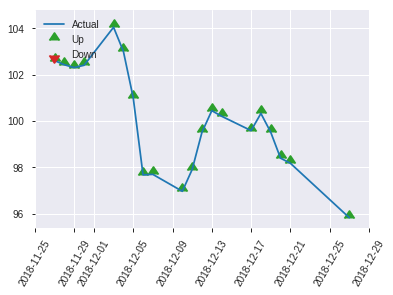


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2545200489073951
RMSE: 0.5044998007010459
LogLoss: 0.7025252126415559
Mean Per-Class Error: 0.435968456725756
AUC: 0.5525286757038582
pr_auc: 0.6106191832795911
Gini: 0.10505735140771644
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3191090226173401: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    110  0.9821   (110.0/112.0)
1      1    136  0.0073   (1.0/137.0)
Total  3    246  0.4458   (111.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.319109     0.710183  245
max f2                       0.298282     0.859473  248
max f0point5                 0.371656     0.619469  219
max accuracy                 0.371656     0.578313  219
max precision                0.610788     1         0
max recall                   0.298282     1         248
max specificity              0.610788     1         0
max absolute_mcc             0.524222     0.170131  41
max min_per_class_accuracy   0.452819     0.535714  125
max mean_per_class_accuracy  0.524222     0.564032  41

Gains/Lift Table: Avg response rate: 55.02 %, avg score: 45.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.580067           1.21168   1.21168            0.666667         0.592799  0.666667                    0.592799            0.0145985       0.0145985                  21.1679   21.1679
    2        0.0200803                   0.570533           1.81752   1.45401            1                0.576476  0.8                         0.58627             0.0145985       0.0291971                  81.7518   45.4015
    3        0.0321285                   0.566195           1.81752   1.59033            1                0.568813  0.875                       0.579723            0.0218978       0.0510949                  81.7518   59.0328
    4        0.0401606                   0.561028           1.81752   1.63577            1                0.564021  0.9                         0.576583            0.0145985       0.0656934                  81.7518   63.5766
    5        0.0522088                   0.554779           0.605839  1.39809            0.333333         0.558614  0.769231                    0.572436            0.00729927      0.0729927                  -39.4161  39.8091
    6        0.100402                    0.541111           0.908759  1.16321            0.5              0.546237  0.64                        0.559861            0.0437956       0.116788                   -9.12409  16.3212
    7        0.15261                     0.527803           1.5379    1.29139            0.846154         0.533382  0.710526                    0.550802            0.080292        0.19708                    53.79     29.1395
    8        0.200803                    0.519914           0.605839  1.12686            0.333333         0.523227  0.62                        0.544184            0.0291971       0.226277                   -39.4161  12.6861
    9        0.301205                    0.504173           1.16321   1.13898            0.64             0.511411  0.626667                    0.53326             0.116788        0.343066                   16.3212   13.8978
    10       0.401606                    0.482935           0.727007  1.03599            0.4              0.492966  0.57                        0.523186            0.0729927       0.416058                   -27.2993  3.59854
    11       0.502008                    0.454499           1.16321   1.06143            0.64             0.465909  0.584                       0.511731            0.116788        0.532847                   16.3212   6.14307
    12       0.598394                    0.437584           0.908759  1.03684            0.5              0.446609  0.57047                     0.501241            0.0875912       0.620438                   -9.12409  3.68393
    13       0.698795                    0.41193            0.945109  1.02366            0.52             0.42359   0.563218                    0.490085            0.0948905       0.715328                   -5.48905  2.36597
    14       0.799197                    0.399656           1.16321   1.04119            0.64             0.406185  0.572864                    0.479544            0.116788        0.832117                   16.3212   4.11914
    15       0.899598                    0.362514           0.872409  1.02235            0.48             0.384038  0.5625                      0.468885            0.0875912       0.919708                   -12.7591  2.2354
    16       1                           0.298282           0.799708  1                  0.44             0.341774  0.550201                    0.456123          

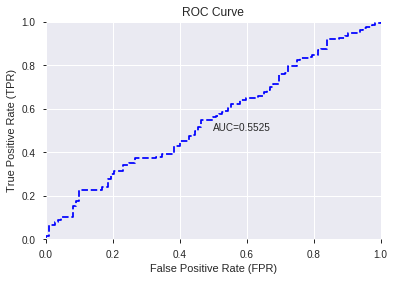

This function is available for GLM models only


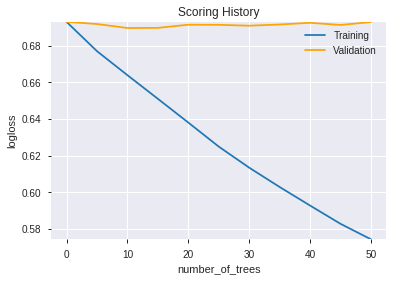

--2019-08-28 16:13:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_161325_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_161325_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9e85',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['MACDFIX_signal_24',
 'BETA_12',
 'STDDEV_8',
 'BETA_14',
 'PLUS_DM_8',
 'TRANGE',
 'ADOSC',
 'MFI_30',
 'STOCHF_fastk',
 'aroonup_30',
 'CCI_12',
 'STOCH_slowd',
 'WILLR_14',
 'ULTOSC',
 'MFI_8',
 'ADXR_12',
 'PLUS_DM_30',
 'AD',
 'ATR_24',
 'MFI_12',
 'HT_DCPERIOD',
 'LINEARREG_ANGLE_12',
 'STDDEV_12',
 'MINUS_DI_20',
 'PLUS_DI_30',
 'DX_14',
 'PPO',
 'CORREL_12',
 'HT_PHASOR_inphase',
 'ADX_24',
 'MOM_8',
 'ROCP_30',
 'MOM_12',
 'PLUS_DI_20',
 'DX_24',
 'AROONOSC_24',
 'NATR_8',
 'STOCH_slowk',
 'PLUS_DI_12',
 'MOM_24',
 'MINUS_DM_8',
 'AROONOSC_20',
 'WILLR_20',
 'BBANDS_upperband_20_3_5',
 'BBANDS_lowerband_14_4_5',
 'aroonup_20',
 'ROCR_24',
 'WILLR_12',
 'MFI_20',
 'MINUS_DI_12',
 'MOM_14',
 'ROC_12',
 'BBANDS_middleband_20_6_2',
 'CMO_24',
 'DX_12',
 'ROCR_8',
 'MFI_24',
 'MFI_14',
 'MACDFIX_hist_12',
 'aroondown_20',
 'LINEARREG_ANGLE_8',
 'DX_20',
 'CCI_20',
 'STOCHRSI_fastd',
 'MOM_20',
 'aroondown_30',
 'MACDEXT_signal',
 'CMO_30',
 'CMO_8',
 'BBANDS_lowerband_20_3_5',
 'P

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.578
GLM             0.566
XGBoost         0.578
dtype: float64

DeepLearning    GLM  XGBoost
All          0.570  0.550    0.574
DLF          0.558  0.550    0.554
Fwe          0.558  0.550    0.574
RFE          0.578  0.566    0.578
XGBF         0.578  0.550    0.554





F1


DeepLearning    0.718
GLM             0.716
XGBoost         0.710
dtype: float64

DeepLearning    GLM  XGBoost
All          0.714  0.710     0.71
DLF          0.710  0.710     0.71
Fwe          0.712  0.710     0.71
RFE          0.710  0.716     0.71
XGBF         0.718  0.710     0.71





auc


DeepLearning    0.541
GLM             0.519
XGBoost         0.553
dtype: float64

DeepLearning    GLM  XGBoost
All          0.518  0.489    0.541
DLF          0.506  0.486    0.535
Fwe          0.520  0.489    0.541
RFE          0.539  0.519    0.553
XGBF         0.541  0.486    0.535





logloss


DeepLearning     8.176
GLM             10.680
XGBoost          0.708
dtype: float64

DeepLearning     GLM  XGBoost
All          7.882   9.856    0.708
DLF          0.694  10.680    0.702
Fwe          8.176   9.856    0.708
RFE          0.703   0.701    0.703
XGBF         0.691  10.680    0.702





mean_per_class_error


DeepLearning    0.487
GLM             0.484
XGBoost         0.451
dtype: float64

DeepLearning    GLM  XGBoost
All          0.453  0.484    0.451
DLF          0.487  0.480    0.451
Fwe          0.472  0.484    0.451
RFE          0.428  0.462    0.436
XGBF         0.465  0.480    0.451





rmse


DeepLearning    0.623
GLM             0.665
XGBoost         0.507
dtype: float64

DeepLearning    GLM  XGBoost
All          0.623  0.662    0.507
DLF          0.500  0.665    0.504
Fwe          0.612  0.662    0.507
RFE          0.504  0.504    0.504
XGBF         0.499  0.665    0.504





mse


DeepLearning    0.388
GLM             0.442
XGBoost         0.257
dtype: float64

DeepLearning    GLM  XGBoost
All          0.388  0.438    0.257
DLF          0.250  0.442    0.254
Fwe          0.374  0.438    0.257
RFE          0.254  0.254    0.255
XGBF         0.249  0.442    0.254

{'F1':       DeepLearning    GLM  XGBoost
 All          0.714    NaN      NaN
 DLF          0.710    NaN      NaN
 DLF            NaN  0.710      NaN
 DLF            NaN    NaN     0.71
 All            NaN  0.710      NaN
 All            NaN    NaN     0.71
 XGBF         0.718    NaN      NaN
 XGBF           NaN  0.710      NaN
 XGBF           NaN    NaN     0.71
 Fwe          0.712    NaN      NaN
 Fwe            NaN  0.710      NaN
 Fwe            NaN    NaN     0.71
 RFE          0.710    NaN      NaN
 RFE            NaN  0.716      NaN
 RFE            NaN    NaN     0.71,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.570    NaN      NaN
 DLF          0.558    NaN      NaN
 DLF            NaN  0.550      NaN
 DLF            NaN    NaN    0.554
 All            NaN  0.550      NaN
 All            NaN    NaN    0.574
 XGBF         0.578    NaN      NaN
 XGBF           NaN  0.550      NaN
 XGBF           NaN    NaN    0.554
 Fwe          0.558    NaN      NaN
 Fwe     